In [1]:
import sys
sys.path.insert(0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')

import sys
sys.path.insert(0, '/home/563/esh563/TINT')

# Core
import datetime
import os
import glob

import tempfile
import pickle
import copy
import math

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
from matplotlib import cm

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
# import tint.animate
# from tint.visualisation import animate

import CPOL_func as cf
import classification_AURA as cl
import caine_func as caf
import analysis
from windrose import WindroseAxes

from pyart.core.transforms import geographic_to_cartesian



# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport classification_AURA
%aimport tint.visualisation.figures
%aimport tint.visualisation.animate
%aimport tint.visualisation.horizontal_helpers
%aimport tint.visualisation.vertical_helpers
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport tint.matching
%aimport tint.rain
%aimport tint.cells
%aimport tint.tracks_helpers
%aimport tint.process_ERA5
%aimport tint.process_WRF
%aimport windrose

# %pdb


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/graphml.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.int, "int"), (np.int8, "int"),
/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/gexf.py:220: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to us

In [2]:
def nice_number(value, round_=False):
    '''nice_number(value, round_=False) -> float'''
    exponent = math.floor(math.log(value, 10))
    fraction = value / 10 ** exponent

    if round_:
        if fraction < 1.5:
            nice_fraction = 1.
        elif fraction < 2.5:
            nice_fraction = 2.
        elif fraction < 6:
            nice_fraction = 5.
        else:
            nice_fraction = 10.
    else:
        if fraction <= 1:
            nice_fraction = 1.
        elif fraction <= 2:
            nice_fraction = 2.
        elif fraction <= 5:
            nice_fraction = 5.
        else:
            nice_fraction = 10.

    return nice_fraction * 10 ** exponent


def nice_bounds(axis_start, axis_end, num_ticks=10):
    '''
    nice_bounds(axis_start, axis_end, num_ticks=10) -> tuple
    @return: tuple as (nice_axis_start, nice_axis_end, nice_tick_width)
    '''
    axis_width = axis_end - axis_start
    if axis_width == 0:
        nice_tick = 0
    else:
        nice_range = nice_number(axis_width)
        nice_tick = nice_number(nice_range / (num_ticks - 1), round_=True)
        axis_start = math.floor(axis_start / nice_tick) * nice_tick
        axis_end = math.ceil(axis_end / nice_tick) * nice_tick

    return axis_start, axis_end, nice_tick

In [3]:
base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/ACCESS_radar_base/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'

In [4]:
base_dir = '/g/data/hj10/cpol/cpol_level_1b/v2020/gridded/grid_150km_2500m/'
save_dir = '/home/563/esh563/TINT_tracks/'
fig_dir = '/home/563/esh563/TINT_figures/'
ERA5_dir = '/g/data/rt52/era5/pressure-levels/reanalysis/'

In [5]:
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Liberation Serif'})
rcParams.update({'mathtext.fontset': 'dejavuserif'})
rcParams.update({'font.size': 12})

# Create Samples

In [6]:
class_thresh = {
    'OFFSET_MAG': 5000,  # metres
    'SHEAR_MAG': 2,  # m/s
    'VEL_MAG': 5,  # m/s
    'REL_VEL_MAG': 2,  # m/s
    'ANGLE_BUFFER': 5}

excl_thresh = {
    'SMALL_AREA': 200,  # km^2
    'LARGE_AREA': 50000,  # km^2
    'BORD_THRESH': 0.001,  # Ratio border pixels to total pixels
    'MAJOR_AXIS_LENGTH': 25,  # km
    'AXIS_RATIO': 2,
    'DURATION': 30}  # minutes

exclusions = [
    'small_area', 'large_area', 'intersect_border',
    'intersect_border_convective', 'duration_cond',
    'small_velocity', 'small_offset']

In [6]:
tracks_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/national/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/national/'

In [7]:
storms = pd.read_csv('bom_storms_archive.csv')
storms['Date/Time'] = pd.to_datetime(storms['Date/Time'])
radar_info = pd.read_csv('./../phd/AURA_analysis/radar_site_list.csv', index_col=0)

In [8]:
radar_info

id_long            WIGOS short_name           location     radar_type  \
id                                                                          
1     001_1  0-20000-0-94867     CampRd       Broadmeadows        DWSR81C   
1     001_2  0-20000-0-94867     CampRd       Broadmeadows  Wurrung-2502C   
2     002_1  0-20000-0-94865       Melb          Melbourne        DWSR81C   
2     002_2  0-20000-0-94865       Melb          Melbourne    Meteor1500S   
2     002_3  0-20000-0-94865       Melb          Melbourne  Meteor1500SDP   
..      ...              ...        ...                ...            ...   
96    096_1              NaN     Yeoval             Yeoval   Meteor735CDP   
97    097_1              NaN    Mild_DP            Mildura   Meteor735CDP   
98    098_1              NaN     Taroom             Taroom  Meteor1700SDP   
105   105_1              NaN     BrisAP  Meteopress C-band    MeteoPressC   
107   107_1              NaN    Rchmond           Richmond  Meteor1700SDP   

    postchange_start prechange_end  site_lat  site_lon  site_alt band doppler  \
id                                                                              
1         28/11/2003    13/08/2010  -37.6910  144.9460   127.300    C     NaN   
1         25/07/2017             -  -37.6910  144.9460   127.300    C     Yes   
2         07/09/1993    30/07/2007  -37.8553  144.7554    45.000    C     NaN   
2         31/07/2007    25/08/2017  -37.8553  144.7555    45.000    S     Yes   
2         11/10/2017             -  -37.8553  144.7555    45.000    S     Yes   
..               ...           ...       ...       ...       ...  ...     ...   
96        26/05/2022             -  -32.7444  148.7081   486.824    C     Yes   
97        15/03/2021             -  -34.2780  141.5890    58.680    C     Yes   
98        20/05/2022             -  -25.6962  149.8982   312.443    S     Yes   
105       29/09/2022             -  -27.3915  153.1300    12.066    C     Yes   
107       29/09/2022             -  -20.7518  143.1414   245.443    S     Yes   

      dp  eth_dhz_threshold  beamwidth state            notes  
id                                                             
1    NaN                 18        1.7   VIC  not operational  
1    Yes                 18        1.7   VIC  not operational  
2    NaN                 18        1.0   VIC              NaN  
2    NaN                 18        1.0   VIC              NaN  
2    Yes                 18        1.0   VIC              NaN  
..   ...                ...        ...   ...              ...  
96   Yes                  0        1.0   NSW              NaN  
97   Yes                  0        1.0   VIC              NaN  
98   Yes                  0        1.0   QLD              NaN  
105  Yes                  0        1.7   QLD              NaN  
107  Yes                  0        1.0   QLD              NaN  

[111 rows x 17 columns]

In [8]:
len(storms[storms['Longitude'] > 145])/len(storms)

0.5080971659919028

In [9]:
np.min(storms['Date/Time'])

Timestamp('2012-01-03 07:11:00')

In [10]:
storms = storms.set_index('Event ID')
storms = storms.drop(labels=['Comments', 'Unnamed: 9'], axis=1).fillna(-9999)

midnight_cond = np.logical_or(storms['Date/Time'].dt.hour != 0, storms['Date/Time'].dt.minute != 0)
storms = storms[midnight_cond]
# Restrict to data period
storms = storms[storms['Date/Time'] >= np.datetime64('2012-06-01')] 
storms_LST = storms['Date/Time'] + np.array([np.timedelta64(np.round(storms['Longitude'].values[i]*12*3600/180).astype(int), 's') for i in range(len(storms))])

In [11]:
len(storms[storms['Longitude'] > 145])/len(storms)

0.6329203539823008

In [13]:
len(list(set(radar_info.index.values)))

81

In [12]:
included_radar = [
    2, 3, 4, 5, 6, 8, 9, 14, 16, 17,
    19, 22, 23, 24, 25, 27, 28, 29, 31, 32,
    33, 36, 37, 40, 41, 42, 44, 46, 48,
    49, 50, 52, 53, 54, 55, 56, 63, 64,
    66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77]

In [13]:
radar_info['location'].unique()

array(['Broadmeadows', 'Melbourne', 'Sydney', 'Wollongong', 'Newcastle',
       'Carnarvon', 'Geraldton', 'Wyndham', 'Gympie', 'Gove', 'DarwinAP',
       'AdelaideAP', 'Perth', 'Mt Gambier', 'Dampier', 'Port Hedland',
       'Broome', 'Weipa', 'Cairns', 'TownsvilleAP', 'Townsville',
       'Mackay', 'Gladstone', 'Bowen', 'Alice Springs', 'Perth AP',
       'Woomera', 'Grafton', 'Learmouth', 'Mildura', 'Albany',
       'Esperence', 'Ceduna', 'Cairns AP',
       'Gulf of Carpentaria (Mornington Island)', 'Hobart Airport',
       'Charleville', 'Newdegate', 'Halls Creek',
       'Canberra (Captains Flat)', 'Willis Island', 'Katherine (Tindal)',
       'Brisbane Airport', 'Giles', 'Eucla', 'Adelaide (Sellicks Hill)',
       'Rockhampton', 'Kalgoorlie', 'Yarrawonga', 'Brisbane (Marburg)',
       'Melbourne Airport', 'N.W. Tasmania (West Takone)', 'Moree',
       'Sydney (Kurnell)', 'Wagga Wagga', 'Longreach', 'East Sale',
       'South Doodlakine', 'Darwin (Berrimah)',
       'Adelaide (Buc

In [15]:
radar_info_paper = radar_info.loc[included_radar][[
    'location', 'radar_type', 'postchange_start', 
    'prechange_end', 'site_lat', 'site_lon', 
    'site_alt', 'band']]
radar_info_paper = radar_info_paper.rename({
    'location': 'Location', 
    'radar_type': 'Type', 
    'postchange_start': 'Start', 
    'prechange_end': 'End', 
    'site_lat': 'Latitude',
    'site_lon': 'Longitude',
    'site_alt': 'Altitude',
    'band': 'Band',
    'state': 'State'}, axis=1)

In [16]:
radar_info_paper['End'][radar_info_paper['End'] == '-'] = np.nan
radar_info_paper['Start'][radar_info_paper['Start'] == '-'] = np.nan

radar_info_paper['Start'] = pd.to_datetime(radar_info_paper['Start'])
radar_info_paper['End'] = pd.to_datetime(radar_info_paper['End'])

radar_info_paper = radar_info_paper[(radar_info_paper['End'] >= np.datetime64('2012-06-01')) | (pd.isnull(radar_info_paper['End'].values))]

radar_info_paper['Start'] = radar_info_paper['Start'].dt.strftime('%b %Y')
radar_info_paper['End'] = radar_info_paper['End'].dt.strftime('%b %Y')
radar_info_paper['End'] = radar_info_paper['End'].fillna('')

radar_info_paper['Period'] = radar_info_paper['Start'] + ' - ' + radar_info_paper['End']
radar_info_paper = radar_info_paper[['Location', 'Type', 'Period', 'Latitude', 'Longitude', 'Altitude', 'Band']] 
radar_info_paper['Altitude'] = np.round(radar_info_paper['Altitude'].values).astype(int)

/tmp/ipykernel_20222/1616154771.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  radar_info_paper['End'][radar_info_paper['End'] == '-'] = np.nan
/tmp/ipykernel_20222/1616154771.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  radar_info_paper['Start'][radar_info_paper['Start'] == '-'] = np.nan


In [17]:
locs = radar_info_paper['Location'].values

import re
locs_new = []
for l in locs:
    l = l.replace('Mount ', r'Mt.~')
    l = l.replace('Mt ', r'Mt. ')
    new = re.findall(r'\(.*?\)', l)
    if new == []:
        locs_new.append(l)
    else: 
        locs_new.append(new[0][1:-1])
        
radar_info_paper['Location'] = locs_new

In [18]:
types_list = radar_info_paper['Type'].unique()
types_dict = {types_list[i]: i+1 for i in range(len(types_list))}
types_num = [types_dict[radar_info_paper['Type'].values[i]] for i in range(len(radar_info_paper))]
radar_info_paper['Type'] = types_num

print(radar_info_paper.to_latex(index=True, float_format="{:.2f}".format))

\begin{tabular}{llrlrrrl}
\toprule
{} &            Location &  Type &               Period &  Latitude &  Longitude &  Altitude & Band \\
id &                     &       &                      &           &            &           &      \\
\midrule
2  &           Melbourne &     1 &  Jul 2007 - Aug 2017 &    -37.86 &     144.76 &        45 &    S \\
2  &           Melbourne &     2 &          Nov 2017 -  &    -37.86 &     144.76 &        45 &    S \\
3  &          Wollongong &     3 &          Sep 2011 -  &    -34.26 &     150.88 &       472 &    S \\
4  &           Newcastle &     4 &  Jul 1999 - Apr 2013 &    -32.73 &     152.03 &        84 &    S \\
4  &           Newcastle &     4 &          Jan 2013 -  &    -32.73 &     152.03 &        84 &    S \\
5  &           Carnarvon &     5 &          Jul 2004 -  &    -24.89 &     113.67 &        12 &    C \\
6  &           Geraldton &     5 &  Aug 2003 - Mar 2019 &    -28.80 &     114.70 &        46 &    C \\
6  &           Geraldton &   

In [217]:
types_dict.keys()

dict_keys(['Meteor1500S', 'Meteor1500SDP', 'DWSR8502S', 'DWSR74S', 'DWSR2502C', 'Meteor735CDP', 'TVDR2500', 'WF100-6C', 'WSR81C', 'WSR74S', 'WF100C', 'WF100-5C', 'Wurrung-2502C'])

In [20]:
def great_circle(lon1, lat1, lon2, lat2):
    lon1 = lon1*np.pi/180
    lat1 = lat1*np.pi/180
    lon2 = lon2*np.pi/180
    lat2 = lat2*np.pi/180
    return 6371e3 * (
        np.arccos(np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(lon1 - lon2))
    )

In [21]:
coverage_df = pd.read_csv('/home/student.unimelb.edu.au/shorte1/Documents/CPOL_analysis/coverage.csv', index_col=0, header=0)
coverage_df.columns = coverage_df.columns.astype(int)
coverage_df.index = pd.to_datetime(coverage_df.index)
coverage_df = coverage_df[included_radar]

In [22]:
# Restrict archive to relevant time period
potential_for_match = []

lats = radar_info_sub['site_lat'].values
lons = radar_info_sub['site_lon'].values

for i in range(len(storms)):
#     import pdb; pdb.set_trace()

    storm = storms.iloc[i]
    distances = great_circle(storm['Longitude'], storm['Latitude'], lons, lats)
#     import pdb; pdb.set_trace()
    date = storm['Date/Time'].date()
    coverage_i = coverage_df.loc[np.datetime64(date)].values.astype(bool)
    if np.any(coverage_i & (distances<150e3)):
        potential_for_match.append(True)
    else: 
        potential_for_match.append(False)
    # work out distance to radars
    # if exists a radar within 150 km, AND radar data exists
    # put a one in potential_for_match
    # otherwise put a zero
# restrict storms based on potential_for_match

In [23]:
len(np.array(potential_for_match)[potential_for_match])/len(potential_for_match)

0.7256637168141593

In [24]:
storms_raw = copy.deepcopy(storms)
storms = storms.loc[potential_for_match]
storms_LST = storms_LST.loc[potential_for_match]

In [21]:
len(storms_raw)

2825

<BarContainer object of 24 artists>

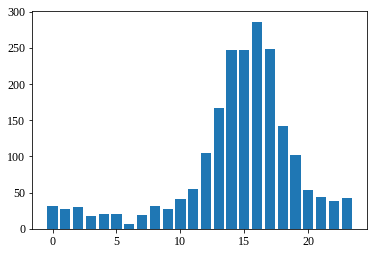

In [22]:
unique, counts = np.unique(storms_LST.dt.hour, return_counts=True)
plt.bar(unique, counts)

<BarContainer object of 12 artists>

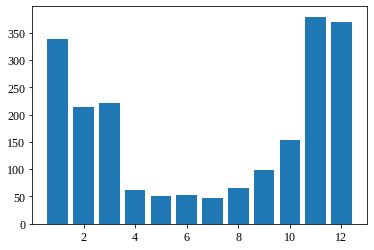

In [20]:
unique, counts = np.unique(storms_LST.dt.month, return_counts=True)
plt.bar(unique, counts)

In [25]:
cats = set(storms['Database'])
# cats = list(cats)

In [26]:
def get_matches(sub_tracks_lower, sub_tracks_higher, storms, radar_info, radar, year, month):
    storms_lat = storms['Latitude'].values
    storms_lon = storms['Longitude'].values

    radar_info_i = radar_info.loc[[radar]].iloc[0]
    lat = radar_info_i[['site_lat']].values[0]
    lon = radar_info_i[['site_lon']].values[0]

    # 1.8 longitude should be sufficient for matching
    radar_dis = np.sqrt((storms_lat-lat)**2 + (storms_lon-lon)**2)
    loc_cond = (radar_dis < 1.8)
    
    storms_i = storms.iloc[loc_cond]
    time_cond = np.logical_and(
        storms_i['Date/Time'].dt.year == year, 
        storms_i['Date/Time'].dt.month == month)
    storms_i = storms_i[time_cond]

    if len(storms_i) == 0:
        print('No reports near this radar this month!')
    else:
        print('Storm reports this month.')

    semi_minor_lower = sub_tracks_lower['semi_minor'].values*tracks_obj.record.grid_size[1]/2
    semi_major_lower = sub_tracks_lower['semi_major'].values*tracks_obj.record.grid_size[1]/2
    orientation_lower = sub_tracks_lower['orientation'].values
    x_lower = sub_tracks_lower['grid_x'].values
    y_lower = sub_tracks_lower['grid_y'].values
    
    semi_minor_upper = sub_tracks_upper['semi_minor'].values*tracks_obj.record.grid_size[1]/2
    semi_major_upper = sub_tracks_upper['semi_major'].values*tracks_obj.record.grid_size[1]/2
    orientation_upper = sub_tracks_upper['orientation'].values
    x_upper = sub_tracks_upper['grid_x'].values
    y_upper = sub_tracks_upper['grid_y'].values

    times = sub_tracks_lower.index.get_level_values('time').values
    reports = ['' for i in range(len(times))]
    report_IDs = ['' for i in range(len(times))]
    
    for i in range(len(storms_i)):
        time_check = np.zeros_like(times).astype(bool)
        storm = storms_i.iloc[i]
#         import pdb; pdb.set_trace()
        storm_x, storm_y = geographic_to_cartesian(
            storm['Longitude'], storm['Latitude'], 
            tracks_obj.reference_grid.get_projparams())
        time_diff = (
            np.datetime64(storm['Date/Time'])-times).astype('timedelta64[s]').astype(float)
        min_dt = np.min(np.abs(time_diff/3600))
        argmin_dt = np.argmin(np.abs(time_diff/3600))
        if min_dt <= 1:
            time_check[argmin_dt] = True
        
        loc_a_lower = (
            np.cos(orientation_lower*np.pi/180)*(storm_x-x_lower)
            + np.sin(orientation_lower*np.pi/180)*(storm_y-y_lower))**2/semi_major_lower**2
        loc_b_lower = (
            np.sin(orientation_lower*np.pi/180)*(storm_x-x_lower)
            - np.cos(orientation_lower*np.pi/180)*(storm_y-y_lower))**2/semi_minor_lower**2
        loc_check_lower = (loc_a_lower+loc_b_lower <= 1)

        loc_a_upper = (
            np.cos(orientation_upper*np.pi/180)*(storm_x-x_upper)
            + np.sin(orientation_upper*np.pi/180)*(storm_y-y_upper))**2/semi_major_upper**2
        loc_b_upper = (
            np.sin(orientation_upper*np.pi/180)*(storm_x-x_upper)
            - np.cos(orientation_upper*np.pi/180)*(storm_y-y_upper))**2/semi_minor_upper**2
        loc_check_upper = (loc_a_upper+loc_b_upper <= 1)

        matches = time_check & (loc_check_lower | loc_check_upper)
        
        if np.any(matches):
            match_inds = np.argwhere(matches).flatten()
            if len(match_inds) == 1:
                print('Match!')
            else:
                print('Multiple matches - this should not occur.')
                import pdb; pdb.set_trace()
            for ind in match_inds:
                reports[ind] += copy.deepcopy(storm['Database'] + ', ')
                report_IDs[ind] += copy.deepcopy(
                    str(storm.name) + '_' + str(storm['ID']) + ', ')
        else: 
            print('No match.')
    return reports, report_IDs

In [27]:
pope_regimes = pd.read_csv('fake_pope_regimes.csv', index_col=0, header=None, names=['Date', 'Regime'])
pope_regimes.index = pd.DatetimeIndex(pope_regimes.index)

In [28]:
r = 2 
y = 2012
m = 1

dir_ry = tracks_dir + '/radar_{}/{}/'.format(r, y)
filename = dir_ry + '/{:02}_{:04}_{:02}.pkl'.format(r, y, m)

with open(filename, 'rb') as f:
    tracks_obj = pickle.load(f)
    
sub_tracks_lower = tracks_obj.tracks.xs(0, level='level')
    
front_info = get_front_info(sub_tracks_lower, r=r, y=y, m=m)

NameError: name 'get_front_info' is not defined

In [24]:
# for y in np.arange(2012, 2024):
#     for m in np.arange(1, 13):
#         dir_ry = '/home/student.unimelb.edu.au/shorte1/Documents/phd/AUS_MCS_paper/AUS_fronts/'
#         filename = dir_ry + '/{:04}/AUS_fronts_{:04}_{:02}.pkl'.format(y, y, m)
#         with open(filename, 'rb') as f:
#             fronts = pickle.load(f)
        
#         if m == 12:
#             end_y = y+1
#             end_m = 1
#         else:
#             end_y = y
#             end_m = m+1
        
#         start_date = np.datetime64('{:04}-{:02}-01'.format(y, m))
#         end_date = np.datetime64('{:04}-{:02}-01'.format(end_y, end_m))
#         fronts = fronts.loc[slice(start_date, end_date)]
        
#         dir_ry = '/home/student.unimelb.edu.au/shorte1/Documents/phd/AUS_MCS_paper/AUS_fronts/'
#         alt_filename = dir_ry + '/{:04}/AUS_fronts_{:04}_{:02}_fix.pkl'.format(y, y, m)
        
# #         import pdb; pdb.set_trace()
        
#         with open(filename, 'wb') as f:
#             pickle.dump(fronts, f)
        
        

In [25]:
dir_ry = '/home/student.unimelb.edu.au/shorte1/Documents/phd/AUS_MCS_paper/AUS_fronts/'

front_counts = np.zeros(12)

for y in np.arange(2012, 2024):
    for m in np.arange(1, 13):

        filename = dir_ry + '/{:04}/AUS_fronts_{:04}_{:02}.pkl'.format(y, y, m)
        with open(filename, 'rb') as f:
            fronts = pickle.load(f)
            
        front_counts[m-1] += len(fronts)

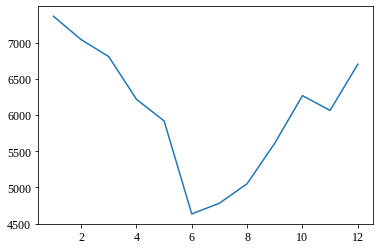

In [26]:
plt.plot(np.arange(1, 13), front_counts)

In [27]:
np.min(front_counts)

4634.0

In [29]:
def get_front_info(sub_tracks_lower, r=63, y=2012, m=1):

    dir_ry = '/home/student.unimelb.edu.au/shorte1/Documents/phd/AUS_MCS_paper/AUS_fronts/'

    if m == 12:
        end_y = y+1
        end_m = 1
    else:
        end_y = y
        end_m = m+1
    
    filename = dir_ry + '/{:04}/AUS_fronts_{:04}_{:02}.pkl'.format(y, y, m)
    with open(filename, 'rb') as f:
        fronts_a = pickle.load(f)
        
    filename = dir_ry + '/{:04}/AUS_fronts_{:04}_{:02}.pkl'.format(
        end_y, end_y, end_m)
    with open(filename, 'rb') as f:
        fronts_b = pickle.load(f)
        
    fronts = pd.concat([fronts_a, fronts_b])
        
#     import pdb; pdb.set_trace()

    distance = []
    direction = []
    MCS_lat = []
    MCS_lon = []
    front_lat = []
    front_lon = []

    for i in range(len(sub_tracks_lower)):
        sub_tracks_lower_i = sub_tracks_lower.iloc[i]

        time = np.datetime64(sub_tracks_lower_i.name[1])
        lon, lat = sub_tracks_lower_i[['lon', 'lat']]
        
        times = np.arange(
            np.datetime64('{:04}-{:02}-01T00:00:00'.format(y, m)), 
            np.datetime64('{:04}-{:02}-01T03:00:00'.format(end_y, end_m)), 
            np.timedelta64(3, 'h'))
        front_time = times[np.argmin(np.abs(time - times))]
       
        try:
            fronts_i = fronts.xs(front_time, level='time')
        except KeyError:
#             import pdb; pdb.set_trace()
#             print('No fronts at {}.'.format(front_time))
            distance.append(np.nan)
            direction.append(np.nan)
            MCS_lat.append(np.nan)
            MCS_lon.append(np.nan)
            front_lat.append(np.nan)
            front_lon.append(np.nan)
            continue
            
        min_distance = []
        argmin_distance = []
        for j in range(len(fronts_i)):
            front = fronts_i.iloc[j]
            distances = great_circle(np.array(front['lon']), np.array(front['lat']), lon, lat)
            min_distance.append(np.min(distances))
            argmin_distance.append(np.argmin(distances))
        nearest_front_ind = np.argmin(min_distance)
        nearest_front = fronts_i.iloc[nearest_front_ind]
        nearest_point_ind = argmin_distance[nearest_front_ind]
        distance_i = min_distance[nearest_front_ind] 
        nearest_lat = nearest_front['lat'][nearest_point_ind]
        nearest_lon = nearest_front['lon'][nearest_point_ind]
        disp_lat = nearest_lat - lat
        disp_lon = nearest_lon - lon
        angle = np.arctan2(disp_lat, disp_lon)*180/np.pi % 360

        distance.append(distance_i)
        direction.append(angle)
        MCS_lat.append(lat)
        MCS_lon.append(lon)
        front_lat.append(nearest_lat)
        front_lon.append(nearest_lon)
    return distance, direction, MCS_lat, MCS_lon, front_lat, front_lon

No handles with labels found to put in legend.


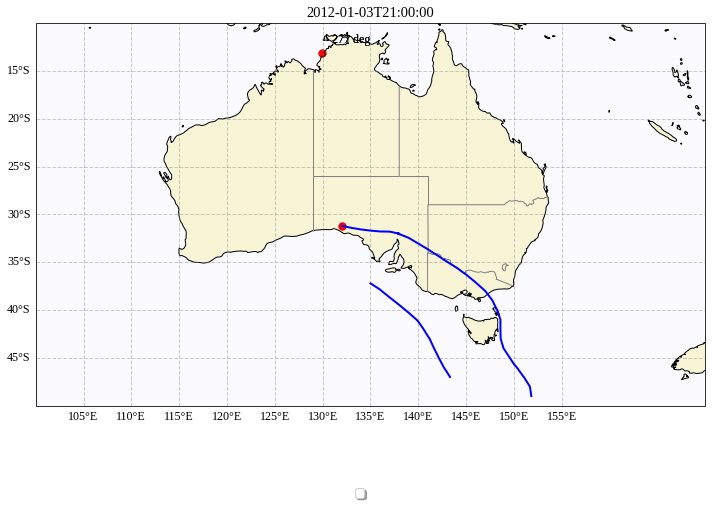

In [130]:
cl.init_fonts()
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(projection=ccrs.PlateCarree())
#     ax.set_title('Severe Storms')
ax.coastlines(resolution='50m', zorder=1)

grid = ax.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.4, linestyle='--')

grid.xlocator = mticker.FixedLocator(np.arange(105, 160, 5))
grid.ylocator = mticker.FixedLocator(np.arange(-50, -5, 5))

states_provinces_50m = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces_50m, edgecolor='grey', zorder=1)

c_land = tuple(np.array([249.0, 246.0, 216.0])/256)
c_water = tuple(np.array([252.0, 252.0, 256.0])/256)

land_50m = cfeature.NaturalEarthFeature(
    'physical', 'land', '50m',
    edgecolor='face',
    facecolor=c_land)
ax.add_feature(land_50m, zorder=0)

ocean_50m = cfeature.NaturalEarthFeature(
    'physical', 'ocean', '50m',
    edgecolor='face',
    facecolor=c_water)
ax.add_feature(ocean_50m, zorder=0)

grid.right_labels = False
grid.top_labels = False

fronts_t = fronts.xs(front_time, level='time')

ax.set_title(front_time)

for k in range(len(fronts_t)):
    front_k = fronts_t.iloc[k]
    plt.plot(front_k['lon'], front_k['lat'], '-b', linewidth=2)
    plt.scatter(lon, lat, marker='o', color='red', linewidth=2)
    plt.scatter(nearest_lon, nearest_lat, marker='o', color='red', linewidth=2)
    plt.text(lon+1, lat+1, r'{:.0f} deg'.format(angle))
    
ax.set_extent([100, 170, -10, -50], crs=ccrs.PlateCarree())

fig.legend(
    loc='lower center',
    bbox_to_anchor=(.5, 0),
    ncol=6, fancybox=True, shadow=True)

In [45]:
included_radar = [
    2, 3, 4, 5, 6, 8, 9, 14, 16, 17,
    19, 22, 23, 24, 25, 27, 28, 29, 31, 32,
    33, 36, 37, 40, 41, 42, 44, 46, 48,
    49, 50, 52, 53, 54, 55, 56, 63, 64,
    66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77]

years = range(2012, 2024)

DTs = []

for r in included_radar:
    print('Getting radar {}.'.format(r))
    for y in years:
        print('Getting year {}.'.format(y))
        if y == 2023:
            end_month = 6
        else: 
            end_month = 13
        if y == 2012:
            start_month = 6
        else:
            start_month = 1
        for m in range(start_month, end_month):
            dir_ry = tracks_dir + '/radar_{}/{}/'.format(r, y)
                                  
            try:               
                filename = dir_ry + '/{:02}_{:04}_{:02}.pkl'.format(r, y, m)
                filename_proxies = dir_ry + '/{:02}_{:04}_{:02}_proxies.pkl'.format(r, y, m)
                with open(filename, 'rb') as f:
                    tracks_obj = pickle.load(f)
            except FileNotFoundError:
                print('File not found.')
                continue
            DTs.append(tracks_obj.params['DT'])
#             import pdb; pdb.set_trace()

Getting radar 2.
Getting year 2012.
Getting year 2013.
Getting year 2014.
Getting year 2015.
Getting year 2016.
Getting year 2017.
File not found.
Getting year 2018.
Getting year 2019.
Getting year 2020.
Getting year 2021.
Getting year 2022.
Getting year 2023.
Getting radar 3.
Getting year 2012.
Getting year 2013.
Getting year 2014.
Getting year 2015.
Getting year 2016.
Getting year 2017.
Getting year 2018.
Getting year 2019.


KeyboardInterrupt: 

<BarContainer object of 8 artists>

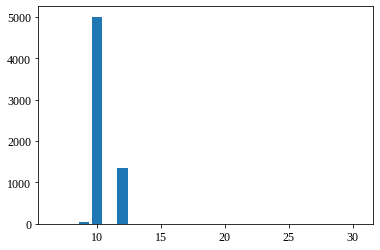

In [33]:
unique, counts = np.unique(np.array(DTs), return_counts=True)
plt.bar(unique, counts)

In [36]:
counts[1]
counts_tot = counts[1] + counts[2] + counts[4]
print(counts[1]/counts_tot)
print(counts[2]/counts_tot)
print(counts[4]/counts_tot)

0.007495315427857589
0.7818550905683948
0.21064959400374766


In [34]:
unique, counts 

(array([ 7,  9, 10, 11, 12, 18, 20, 30]),
 array([   1,   48, 5007,    2, 1349,    1,    1,    1]))

In [114]:
included_radar = [
    2, 3, 4, 5, 6, 8, 9, 14, 16, 17,
    19, 22, 23, 24, 25, 27, 28, 29, 31, 32,
    33, 36, 37, 40, 41, 42, 44, 46, 48,
    49, 50, 52, 53, 54, 55, 56, 63, 64,
    66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77]

years = range(2012, 2024)

front_info_names = [
    'distance', 'direction', 'MCS_lat', 
    'MCS_lon', 'front_lat', 'front_lon']
class_names = [
    'inflow_type', 'propagation_type', 'tilt_type', 
    'offset_type', 'rel_offset_type']
tracks_names = [
    'u_trop_shear', 'v_trop_shear', 'av_rh', 'av_rh_bfl', 
    'av_ee', 'av_ee_bfl', 'orientation', 'u_relative', 'v_relative', 
    'u_shift', 'v_shift', 'u_shear', 'v_shear', 'CAPE', 
    'semi_major', 'semi_minor', 'trop_height', 'u_ambient_mean', 'v_ambient_mean']
proxy_names = [
    'MLCAPE100', 'u06', 'v06', 'MUCAPE', 'MLCIN100']

data_names = [
    'radar', 'time', 'report', 'pope_regime',
    'report_ID', 'raw_sample', 'restricted_sample', 'so_x', 'so_y']
data_names += class_names + tracks_names + proxy_names + front_info_names

data_dic = dict(zip(data_names, [[] for i in range(len(data_names))]))

exclusions = [
    'small_area', 'large_area', 'intersect_border',
    'intersect_border_convective', 'duration_cond',
    'small_velocity', 'small_offset']

non_linear = False

for r in included_radar:
    print('Getting radar {}.'.format(r))
    for y in years:
        print('Getting year {}.'.format(y))
        if y == 2023:
            end_month = 6
        else: 
            end_month = 13
        if y == 2012:
            start_month = 6
        else:
            start_month = 1
        for m in range(start_month, end_month):
            dir_ry = tracks_dir + '/radar_{}/{}/'.format(r, y)
                                  
            try:               
                filename = dir_ry + '/{:02}_{:04}_{:02}.pkl'.format(r, y, m)
                filename_proxies = dir_ry + '/{:02}_{:04}_{:02}_proxies.pkl'.format(r, y, m)
                with open(filename, 'rb') as f:
                    tracks_obj = pickle.load(f)
                with open(filename_proxies, 'rb') as f:
                    proxies = pickle.load(f)
            except FileNotFoundError:
                print('File not found.')
                continue

            if len(tracks_obj.tracks) < 4:
                print('Small tracks.')
                continue

            exclusions_raw = ['simple_duration_cond']
            try:
                excluded_raw = tracks_obj.exclusions[exclusions_raw]
            except AttributeError:
                print('Attribute error.')
                continue     
            excluded_raw = np.any(excluded_raw, 1)
            raw_sample = np.logical_not(excluded_raw)
            raw_sample = raw_sample.xs(0, level='level').values
                
            exclusions = [
                'small_area', 'large_area', 'intersect_border',
                'intersect_border_convective', 'duration_cond',
                'small_velocity', 'small_offset']
            try:
                excluded = tracks_obj.exclusions[exclusions]
            except AttributeError:
                print('Attribute error.')
                continue                
            excluded = np.any(excluded, 1)
            restricted_sample = np.logical_not(excluded)
            restricted_sample = restricted_sample.xs(0, level='level').values
                        
            sub_class = tracks_obj.tracks_class.fillna(-9999)
            sub_tracks = tracks_obj.tracks.fillna(-9999)
            sub_proxies = proxies.fillna(-9999)
            
            if len(sub_tracks) == 0:
                sub_tracks_lower = None
            else:
                try:
                    sub_class = sub_class.xs(0, level='level')
                    sub_tracks_lower = sub_tracks.xs(0, level='level')
                    sub_tracks_upper = sub_tracks.xs(2, level='level')
                except KeyError:
                    sub_tracks_lower = None
                    sub_class = None
            
            if sub_tracks_lower is None:
                continue
            else:
                if (len(sub_proxies) != len(sub_class)) or (len(sub_proxies) != len(sub_tracks_lower)):
                    print('Sizes do not match: skipping.')
                    continue
                data_dic['raw_sample'] += raw_sample.tolist()
                data_dic['restricted_sample'] += restricted_sample.tolist()
                data_dic['radar'] += [r]*len(sub_tracks_lower)
                data_dic['time'] += list(
                    sub_tracks_lower.index.get_level_values(1).values)
        
                reports, report_IDs = get_matches(
                    sub_tracks_lower, sub_tracks_upper, storms, 
                    radar_info, r, y, m)

                data_dic['report'] += reports
                data_dic['report_ID'] += report_IDs
        
                front_info = get_front_info(sub_tracks_lower, r=r, y=y, m=m)

                dates_i = sub_tracks_lower.index.get_level_values('time').date
                regimes_i = pope_regimes.loc[dates_i]
                data_dic['pope_regime'] += regimes_i.values.flatten().tolist()
                
                so_x = sub_tracks_upper['grid_x'] - sub_tracks_lower['grid_x']
                so_y = sub_tracks_upper['grid_y'] - sub_tracks_lower['grid_y']
                
                data_dic['so_x'] += list(so_x.values)
                data_dic['so_y'] += list(so_y.values)
                
#                 import pdb; pdb.set_trace()
            
                for n in range(len(front_info_names)):
                    data_dic[front_info_names[n]] += list(front_info[n])
                for n in class_names:
                    data_dic[n] += list(sub_class[n].values)
                for n in tracks_names:
                    data_dic[n] += list(sub_tracks_lower[n].values)
                for n in proxy_names:
                    data_dic[n] += list(sub_proxies[n].replace(-9999, np.nan).values)

Getting radar 2.
Getting year 2012.
No reports near this radar this month!
File not found.
File not found.
No reports near this radar this month!
File not found.
Storm reports this month.
No match.
No match.
Storm reports this month.
Match!
Getting year 2013.
No reports near this radar this month!
Storm reports this month.
No match.
Match!
No match.
No match.
No match.
No reports near this radar this month!
Small tracks.
File not found.
File not found.
Storm reports this month.
No match.
No reports near this radar this month!
No reports near this radar this month!
Storm reports this month.
No match.
Storm reports this month.
No match.
Storm reports this month.
No match.
No match.
No match.
Getting year 2014.
Storm reports this month.
No match.
No match.
No match.
Storm reports this month.
No match.
Storm reports this month.
No match.
No match.
Match!
Match!
No match.
Small tracks.
Storm reports this month.
No match.
No reports near this radar this month!
File not found.
File not found.

Getting year 2016.
Storm reports this month.
No match.
No match.
No match.
No match.
No match.
No match.
No match.
No match.
No match.
No match.
No match.
Match!
No match.
No match.
No match.
No match.
No match.
No match.
Match!
No match.
No match.
No match.
No match.
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Storm reports this month.
No match.
Match!
Match!
Match!
Match!
Storm reports this month.
No match.
Match!
Match!
No match.
Storm reports this month.
No match.
No match.
No match.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
File not found.
No reports near this radar this month!
Small tracks.
Storm reports this month.
No match.
Storm reports this month.
No match.
Match!
Match!
No match.
No match.
No match.
No match.
No match.
Getting year 2017.
Storm reports this month.
No match.
Storm reports this month.
Match!
No match.
No match.
Match!
Match!
Match!
Match!
Match!
No match.
Match!
No match.
No match.


Storm reports this month.
No match.
Storm reports this month.
No match.
No match.
Match!
No match.
No match.
Storm reports this month.
No match.
No match.
No match.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Storm reports this month.
No match.
Storm reports this month.
No match.
No match.
Storm reports this month.
No match.
No match.
No match.
Getting year 2017.
Storm reports this month.
Match!
No match.
Match!
No match.
No match.
Storm reports this month.
No match.
No match.
No match.
No match.
No match.
Match!
Match!
Match!
No match.
No match.
No match.
No match.
No match.
No match.
No match.
No match.
No match.
No match.
No match.
Storm reports this month.
No match.
No match.
Match!
No match.
No match.
No match.
Storm reports this month.
No match.
No match.
No match.
No reports near this radar this month!
File not found.
No reports n

No reports near this radar this month!
Getting year 2021.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting year 2022.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar

Storm reports this month.
No match.
No match.
No match.
No match.
No match.
No match.
No match.
Match!
No match.
No match.
No match.
No match.
No match.
No match.
No match.
No match.
No match.
No match.
No match.
Match!
Match!
Match!
Getting year 2015.
Storm reports this month.
Match!
Match!
No match.
No match.
No match.
No match.
No match.
Storm reports this month.
Match!
No match.
No match.
Match!
Storm reports this month.
No match.
No match.
No match.
No match.
No match.
No match.
No match.
No reports near this radar this month!
Storm reports this month.
Match!
Match!
Match!
Match!
No match.
Match!
No match.
No match.
No match.
No match.
No reports near this radar this month!
File not found.
No reports near this radar this month!
Storm reports this month.
No match.
No match.
No match.
No match.
No match.
No match.
Storm reports this month.
No match.
No match.
No match.
No match.
No match.
No match.
No match.
No match.
Match!
Match!
Match!
Match!
Match!
Match!
No match.
No match.
Sto

Getting year 2020.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
File not found.
File not found.
File not found.
File not found.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting year 2021.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
File not found.
File not found.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting year 2022.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar t

No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
File not found.
File not found.
Small tracks.
Small tracks.
No reports near this radar this month!
No reports near this radar this month!
Storm reports this month.
Match!
Getting year 2016.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Storm reports this month.
No match.
Storm reports this month.
No match.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting year 2017.
No reports near this radar this month!
Storm reports this month.
No match.
Storm reports this month.
Match!
No reports near this radar this month!
No reports near this radar this month!
File not found.
Small trac

No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting year 2023.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting radar 19.
Getting year 2012.
File not found.
File not found.
File not found.
File not found.
File not found.
No reports near this radar this month!
No reports near this radar this month!
Getting year 2013.
No reports near this radar this month!
No reports near this radar this month!
Storm reports this month.
No match.
No reports near this radar this month!
File not found.
File not found.
File not found.
File not found.
File not found.
Storm reports this month.
Match!
Storm reports this month.
No match.
No match.
No reports near this radar this month!
Getting year 2014.
No reports near this radar this month!
Storm r

No reports near this radar this month!
Getting year 2021.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Storm reports this month.
Match!
No reports near this radar this month!
No reports near this radar this month!
Getting year 2022.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
File not found.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting year 202

No reports near this radar this month!
File not found.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting year 2017.
No reports near this radar this month!
Storm reports this month.
No match.
No reports near this radar this month!
File not found.
No reports near this radar this month!
No reports near this radar this month!
File not found.
No reports near this radar this month!
Small tracks.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting year 2018.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
File not found.
File not found.
No reports near this radar this month!
File not found.
Small tracks.
No reports near this radar this month!
No reports near this radar this month!
No reports near this r

No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting year 2016.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting year 2017.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar

Storm reports this month.
No match.
No match.
No match.
Match!
Match!
No match.
Match!
Match!
Match!
Match!
Match!
No match.
Match!
Match!
No match.
No match.
Getting year 2018.
Storm reports this month.
No match.
No match.
Match!
Match!
No match.
No match.
No match.
Match!
No match.
No match.
No match.
No match.
No match.
Storm reports this month.
No match.
No match.
No match.
Match!
Match!
Match!
Match!
Match!
Storm reports this month.
No match.
No match.
Storm reports this month.
No match.
File not found.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Storm reports this month.
No match.
No match.
No reports near this radar this month!
Storm reports this month.
No match.
No match.
No match.
Storm reports this month.
No match.
No match.
No match.
No match.
Getting year 2019.
No reports near this radar this month!
Storm reports this month.
Match!
Storm reports this month.
No match.
Match!
Match!
Match!
No reports nea

File not found.
File not found.
Getting year 2015.
File not found.
No reports near this radar this month!
No reports near this radar this month!
File not found.
File not found.
File not found.
File not found.
File not found.
File not found.
Small tracks.
File not found.
File not found.
Getting year 2016.
No reports near this radar this month!
Storm reports this month.
No match.
No reports near this radar this month!
No reports near this radar this month!
Small tracks.
No reports near this radar this month!
File not found.
File not found.
File not found.
File not found.
No reports near this radar this month!
No reports near this radar this month!
Getting year 2017.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
File not found.
No reports near this radar this month!
No reports near this radar this month!
Storm reports this month.
No match.
File not found.
Small tracks.
File not found.
No reports near this radar this mo

No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting year 2023.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting radar 33.
Getting year 2012.
No reports near this radar this month!
No reports near this radar this month!
File not found.
File not found.
File not found.
No reports near this radar this month!
File not found.
Getting year 2013.
File not found.
Storm reports this month.
No match.
No reports near this radar this month!
File not found.
File not found.
No reports near this radar this month!
Small tracks.
No reports near this radar this month!
File not found.
Small tracks.
File not found.
No reports near this radar this month!
Getting year 2014.
File not found.
No reports near this radar this month!
File not found.
Fil

No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting year 2022.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
File not found.
File not found.
File not found.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting year 2023.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
File not found.
Getting radar 37.
Getting year 2012.
File not found.
File not found.
File not found.
File not found.
File not found.
File not found.
File not found.
Getting year 2013.
File not found.
File not found.
File not found.
File not found.
Fil

No reports near this radar this month!
File not found.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting year 2020.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting year 2021.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports

File not found.
File not found.
File not found.
No reports near this radar this month!
Storm reports this month.
No match.
Storm reports this month.
No match.
No match.
Getting year 2018.
No reports near this radar this month!
Storm reports this month.
No match.
No match.
No reports near this radar this month!
No reports near this radar this month!
File not found.
File not found.
File not found.
File not found.
File not found.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting year 2019.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
File not found.
File not found.
File not found.
File not found.
No reports near this radar this month!
No reports near this radar this month!
Storm reports this month.
No match.
Getting year 2020.
Storm reports this month.
No match.
Match

Getting year 2017.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
File not found.
Small tracks.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting year 2018.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
File not found.
File not found.
File not found.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting year 2019.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No repo

Storm reports this month.
No match.
No match.
No match.
File not found.
File not found.
File not found.
Storm reports this month.
No match.
No reports near this radar this month!
No reports near this radar this month!
Storm reports this month.
Match!
Match!
No reports near this radar this month!
Storm reports this month.
No match.
Getting year 2014.
Small tracks.
Storm reports this month.
No match.
Storm reports this month.
No match.
No match.
No match.
No match.
File not found.
File not found.
File not found.
File not found.
File not found.
No reports near this radar this month!
Storm reports this month.
No match.
No match.
No match.
No match.
Storm reports this month.
Match!
No match.
Storm reports this month.
Match!
No match.
No match.
No match.
No match.
Match!
Match!
No match.
No match.
No match.
Getting year 2015.
Storm reports this month.
No match.
No match.
Storm reports this month.
No match.
No match.
Match!
No reports near this radar this month!
No reports near this radar thi

Storm reports this month.
No match.
Match!
No match.
Match!
Match!
No match.
Match!
Match!
Match!
No match.
Getting year 2016.
Storm reports this month.
No match.
No match.
No match.
No match.
No match.
Match!
Match!
No match.
Match!
No match.
No match.
No match.
Storm reports this month.
No match.
Match!
No match.
No match.
No match.
No match.
Match!
Match!
No match.
No match.
Match!
Match!
Match!
Storm reports this month.
No match.
No match.
No match.
No match.
No match.
No match.
Match!
Match!
No reports near this radar this month!
No reports near this radar this month!
Storm reports this month.
Match!
No match.
No match.
No match.
No match.
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
Match!
No reports near this radar this month!
Storm reports this month.
No match.
Storm reports this month.
No match.
No reports near this radar this month!
Storm reports this month.
No match.
No match.
No match.
No match.
Storm reports this month.


Storm reports this month.
Match!
Match!
No reports near this radar this month!
Small tracks.
No reports near this radar this month!
Storm reports this month.
No match.
No match.
Getting year 2013.
Storm reports this month.
Match!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
File not found.
No reports near this radar this month!
File not found.
Small tracks.
No reports near this radar this month!
No reports near this radar this month!
Storm reports this month.
No match.
No match.
No match.
No reports near this radar this month!
Getting year 2014.
No reports near this radar this month!
No reports near this radar this month!
Storm reports this month.
No match.
Small tracks.
Small tracks.
File not found.
File not found.
File not found.
File not found.
Storm reports this month.
No match.
Storm reports this month.
No match.
No match.
Storm reports this month.
No match.
Getting year 2015.
Storm reports this month.
Match!


Storm reports this month.
No match.
No match.
No match.
Match!
Match!
No match.
Match!
File not found.
File not found.
File not found.
File not found.
File not found.
File not found.
File not found.
File not found.
Storm reports this month.
No match.
No match.
No match.
Getting year 2018.
Storm reports this month.
No match.
No match.
Match!
Match!
Match!
Match!
No match.
No match.
No match.
Storm reports this month.
No match.
Storm reports this month.
No match.
No match.
No match.
No match.
No match.
No match.
Match!
No match.
Storm reports this month.
No match.
No match.
No match.
No match.
File not found.
File not found.
No reports near this radar this month!
No reports near this radar this month!
Storm reports this month.
No match.
Match!
Match!
Match!
No match.
Storm reports this month.
No match.
Match!
Storm reports this month.
No match.
Match!
Match!
Match!
Match!
Match!
Match!
Match!
No match.
Storm reports this month.
No match.
Match!
No match.
No match.
No match.
No match.
Mat

No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting year 2013.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
File not found.
File not found.
File not found.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting year 2014.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
File not found.
File not found.
No reports near this radar this month!
Small tracks.
No reports near this radar this month!
No reports near this radar this month!
Storm reports this month.
No match.
Storm reports this month.
No match.
No match.
Getting year 2015.
No reports near this radar

Storm reports this month.
Match!
Match!
Storm reports this month.
Match!
No reports near this radar this month!
File not found.
File not found.
File not found.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting year 2022.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
File not found.
File not found.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting year 2023.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
File not found.
Getting radar

Storm reports this month.
No match.
Match!
Match!
No match.
No match.
No match.
No match.
No match.
No match.
No match.
Getting year 2014.
Storm reports this month.
Match!
Match!
Match!
Match!
No match.
Match!
No match.
No match.
Match!
No reports near this radar this month!
Storm reports this month.
Match!
Match!
No match.
No match.
No match.
Match!
Storm reports this month.
No match.
Match!
No match.
Match!
Match!
Match!
File not found.
No reports near this radar this month!
File not found.
No reports near this radar this month!
Storm reports this month.
No match.
Match!
No match.
No match.
No match.
No match.
Match!
Storm reports this month.
No match.
No match.
Storm reports this month.
No match.
Match!
No match.
Match!
Match!
Match!
Match!
No match.
Match!
Match!
Match!
Match!
Match!
No match.
No match.
No match.
No match.
No match.
No match.
No match.
No match.
Storm reports this month.
No match.
No match.
No match.
Match!
Match!
No match.
Match!
No match.
No match.
No match.
No m

No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting year 2016.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Storm reports this month.
No match.
Match!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting year 2017.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
File not found.
No reports near this radar this month!
File not found.
File not found.
File not found.
File not found.
No reports near this

No reports near this radar this month!
No reports near this radar this month!
Storm reports this month.
No match.
Storm reports this month.
Match!
Match!
Match!
Match!
Match!
No match.
No match.
Match!
Match!
Match!
Match!
Match!
Getting year 2013.
Storm reports this month.
No match.
No match.
No match.
No match.
Match!
Storm reports this month.
Match!
Match!
No match.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Storm reports this month.
Match!
Match!
No match.
Match!
Storm reports this month.
No match.
Match!
Match!
Match!
Match!
Match!
Match!
No match.
Storm reports this month.
No match.
Getting year 2014.
No reports near this radar this month!
Storm reports this month.
No match.
Match!
Storm reports this month.
No match.
Match!
Match!
Match!
No match.
No mat

Small tracks.
File not found.
File not found.
File not found.
No reports near this radar this month!
Getting year 2017.
No reports near this radar this month!
Storm reports this month.
No match.
No match.
Storm reports this month.
No match.
No reports near this radar this month!
File not found.
No reports near this radar this month!
Storm reports this month.
No match.
No match.
No match.
No match.
No match.
No match.
Storm reports this month.
No match.
No match.
No match.
No match.
File not found.
Storm reports this month.
No match.
No match.
No match.
No match.
No match.
No reports near this radar this month!
No reports near this radar this month!
Getting year 2018.
Storm reports this month.
Match!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Storm reports this month.
No match.
No match.
No match.
No match.
No match.
No match.
Storm reports this month.
No match.
No match.
No match.
No match.
Storm reports this mon

No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Storm reports this month.
No match.
Match!
Match!
No match.
No match.
Storm reports this month.
No match.
No match.
Storm reports this month.
No match.
No match.
No match.
No match.
No match.
No match.
No match.
No match.
Match!
Storm reports this month.
No match.
Match!
No match.
No match.
No match.
No match.
No match.
No match.
No match.
Match!
Match!
No match.
No match.
Match!
Match!
No match.
No match.
No match.
No match.
No match.
No match.
No match.
Match!
Match!
Match!
Match!
Match!
Match!
No match.
Getting year 2019.
Storm reports this month.
Match!
No match.
No match.
No match.
No match.
No match.
No match.
No match.
No match.
No match.
No match.
Match!
Match!
No match.
Match!
No match.
Storm reports this month.
Match!
No match.
No match.
No match.
No match.
No match.
No match.
Match!
Storm reports this month.
No match.
No match.
No match.
No match.
Match!
No ma

No reports near this radar this month!
Getting year 2013.
Storm reports this month.
Match!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
File not found.
File not found.
File not found.
File not found.
File not found.
No reports near this radar this month!
Storm reports this month.
No match.
No reports near this radar this month!
Getting year 2014.
No reports near this radar this month!
Storm reports this month.
No match.
No reports near this radar this month!
Storm reports this month.
No match.
No reports near this radar this month!
No reports near this radar this month!
File not found.
File not found.
File not found.
No reports near this radar this month!
File not found.
Storm reports this month.
No match.
Getting year 2015.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
File not found.
File not found.
File not found.
File not found.
File not fou

No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
Getting year 2023.
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
No reports near this radar this month!
File not found.
Getting radar 76.
Getting year 2012.
File not found.
File not found.
File not found.
File not found.
File not found.
File not found.
File not found.
Getting year 2013.
No reports near this radar this month!
File not found.
File not found.
File not found.
File not found.
File not found.
File not found.
File not found.
File not found.
File not found.
File not found.
File not foun

# Analyse Samples

In [24]:
data_dic_array = {}
for k in data_dic.keys():
    data_dic_array[k] = np.array(data_dic[k])

NameError: name 'data_dic' is not defined

In [253]:
cond = (pd.DatetimeIndex(data_dic_array['time']).month == 6)
cond = cond | (pd.DatetimeIndex(data_dic_array['time']).month == 12)
cond = cond & (pd.DatetimeIndex(data_dic_array['time']).year == 2012)

In [255]:
len(data_dic_array['radar'][cond_res & cond])

850

In [256]:
15/805

0.018633540372670808

In [27]:
data_dic_array.keys()

dict_keys([])

In [118]:
dir_ry = '/home/student.unimelb.edu.au/shorte1/Documents/phd/AUS_MCS_paper/AUS_fronts/'
alt_filename = dir_ry + 'data_dic_array.pkl'
#         import pdb; pdb.set_trace()

with open(alt_filename, 'wb') as f:
    pickle.dump(data_dic_array, f)

In [30]:
dir_ry = '/home/student.unimelb.edu.au/shorte1/Documents/phd/AUS_MCS_paper/AUS_fronts/'
alt_filename = dir_ry + 'data_dic_array.pkl'
#         import pdb; pdb.set_trace()

with open(alt_filename, 'rb') as f:
    data_dic_array = pickle.load(f)

# Windrose

In [31]:
cond_report = (data_dic_array['report'] != '')
cond_raw = data_dic_array['raw_sample']
cond_res = data_dic_array['restricted_sample']
cond_rts = (data_dic_array['rel_offset_type'] == 'Relative Trailing Stratiform')
cond_rls = (data_dic_array['rel_offset_type'] == 'Relative Leading Stratiform')
cond_rles = (data_dic_array['rel_offset_type'] == 'Relative Parallel Stratiform (Left)')
cond_rrs = (data_dic_array['rel_offset_type'] == 'Relative Parallel Stratiform (Right)')

cond_ust = (data_dic_array['tilt_type'] == 'Up-Shear Tilted')
cond_dst = (data_dic_array['tilt_type'] == 'Down-Shear Tilted')

cond_usp = (data_dic_array['propagation_type'] == 'Up-Shear Propagating')
cond_dsp = (data_dic_array['propagation_type'] == 'Down-Shear Propagating')

<BarContainer object of 49 artists>

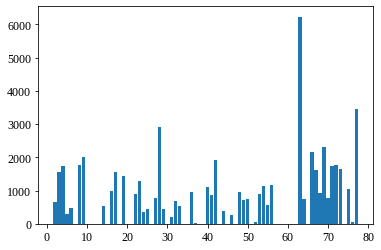

In [32]:
cc = np.unique(data_dic_array['radar'][cond_res], return_counts=True)
plt.bar(cc[0], cc[1])

In [329]:
np.argmin(cc[1][cc[1] > 50])

18

In [332]:
test2 = cc[0][cc[1]>50]
test2[18]

31

In [331]:
test = cc[1][cc[1] > 50]
test[18]

216

In [322]:
len(data_dic_array['radar'][cond_res & (data_dic_array['radar']==63)])

6229

In [33]:
cond_front = (data_dic_array['distance'] <= 1000e3)

In [34]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

In [35]:
cond_radar = (data_dic_array['radar'] == 77)
distance_r = data_dic_array['distance'][cond_res & cond_front & cond_radar]/1e3
direction_r = (90 - data_dic_array['direction'][cond_res & cond_front & cond_radar]) % 360

frontal_sample_size = len(distance_r)
res_sample_size = len(data_dic_array['distance'][cond_res & cond_radar])
print('Percentage Frontal:')
pct_frontal = frontal_sample_size/res_sample_size*100 
print(frontal_sample_size/res_sample_size*100)

Percentage Frontal:
0.28885037550548814


Percentage Frontal:
74.99181937172776
Percentage Frontal:
63.17459348973428
Percentage Frontal:
33.82910242433681
Percentage Frontal:
3.3056438655864357
Percentage Frontal:
0.61088203034973
Percentage Frontal:
7.545502738999824
Percentage Frontal:
48.480548657916515
Percentage Frontal:
68.76218323586744


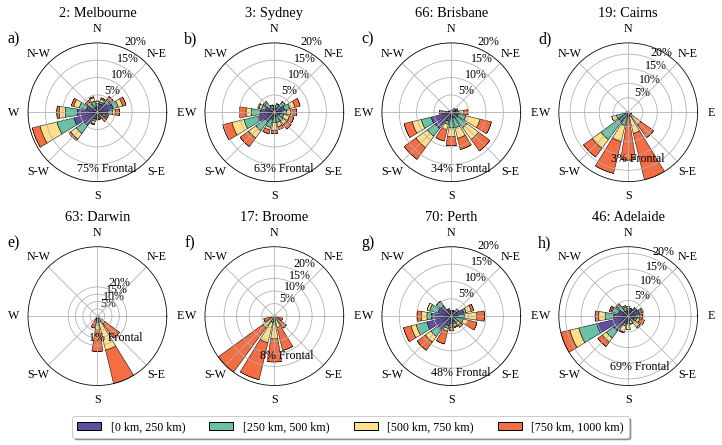

In [143]:
fig = plt.figure(figsize=(12, 7.5))

# Looking good - but redo front calculation using larger domain
# this will confirm the left-right asymettry not just an artifact of domain size

rose_radars = [2, 3, 66, 19, 63, 17, 70, 46]
radar_labels = [
    '2: Melbourne', '3: Sydney', '66: Brisbane', '19: Cairns',
    '63: Darwin', '17: Broome', '70: Perth', '46: Adelaide']

for i in range(len(rose_radars)):
    r = rose_radars[i]
    ax = fig.add_subplot(2, 4, i+1, projection="windrose")
    cond_radar = (data_dic_array['radar'] == r)
    distance_r = data_dic_array['distance'][cond_raw & cond_front & cond_radar]/1e3
    direction_r = (90 - data_dic_array['direction'][cond_raw & cond_front & cond_radar]) % 360

    frontal_sample_size = len(distance_r)
    raw_sample_size = len(data_dic_array['distance'][cond_raw & cond_radar])
    print('Percentage Frontal:')
    pct_frontal = frontal_sample_size/raw_sample_size*100 
    print(frontal_sample_size/raw_sample_size*100)
    
    cmap = cm.get_cmap('Spectral_r', 6)

    ax.bar(
        direction_r, distance_r, normed=True, 
        opening=0.8, edgecolor='k', linewidth=.5, blowto=False,
        bins=np.arange(0, 1250, 250), cmap=cmap)
    ax.set_yticks(np.arange(5, 25, step=5))
    tick_labels = np.arange(5, 25, step=5).astype(str)
    tick_labels = [t + '%' for t in tick_labels]
    ax.set_yticklabels(tick_labels)
    ax.set_rlabel_position(67.5)
    ax.set_title(radar_labels[i])
    ax.text(.93*3*np.pi/2, 18, '{:.0f}% Frontal'.format(pct_frontal), fontsize=12)

plt.subplots_adjust(hspace=0, wspace=.275)

# ax.set_legend()
leg = plt.legend(
    loc='lower center', over_label=False,
    bbox_to_anchor=(-1.5, -.42),
    ncol=5, fancybox=True, shadow=True)

labels = [
    '[0 km, 250 km)', '[250 km, 500 km)', '[500 km, 750 km)',
    '[750 km, 1000 km)']

[old.set_text(new) for (old, new) in zip(leg.texts, labels)]

cl.make_subplot_labels(fig.get_axes())

plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/phd/AUS_MCS_paper/wind_rose_raw_alt.png',
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

In [202]:
3 // 4

0

0.2988401755930262
0.31479783387255833
Percentage Frontal:
41.49484536082475
Percentage Frontal:
53.283302063789876
Percentage Frontal:
65.29850746268657
Percentage Frontal:
76.19047619047619
Percentage Frontal:
85.13323983169705
Percentage Frontal:
67.74809160305344
Percentage Frontal:
60.01730852444829
Percentage Frontal:
40.45412418906395


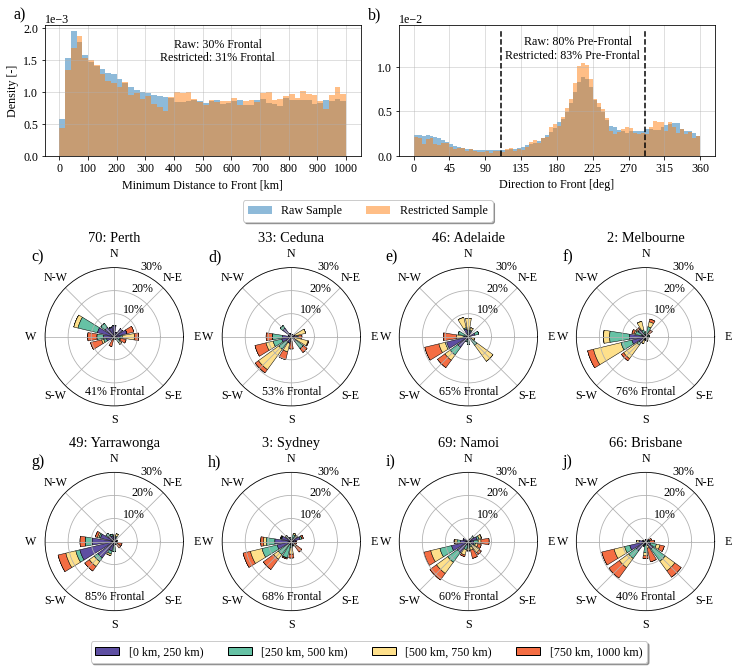

In [254]:
fig = plt.figure(figsize=(12, 11))

gs = fig.add_gridspec(4, 4, height_ratios=[.8, .1, 1, 1])

# fig = plt.subplots(figsize=(12, 3))

cl.init_fonts()

ax = fig.add_subplot(gs[0, :2])

dbin = 20
ax.hist(
    data_dic_array['distance'][cond_raw & cond_front]/1e3, 
    bins = np.arange(0, 1000+dbin, dbin), density=True, alpha=.5, label='Raw Sample')
ax.hist(
    data_dic_array['distance'][cond_res & cond_front]/1e3, 
    bins = np.arange(0, 1000+dbin, dbin), density=True, alpha=.5, label='Restricted Sample')

raw_pct_frontal = len(data_dic_array['distance'][cond_raw & cond_front])/len(data_dic_array['distance'][cond_raw])
res_pct_frontal = len(data_dic_array['distance'][cond_res & cond_front])/len(data_dic_array['distance'][cond_res])
print(raw_pct_frontal)
print(res_pct_frontal)

ax.text(
    400, 1.7e-3, 
    'Raw: {:02}% Frontal'.format(np.round(raw_pct_frontal*100).astype(int)), fontsize=12)
ax.text(
    350, 1.5e-3, 
    'Restricted: {:02}% Frontal'.format(np.round(res_pct_frontal*100).astype(int)), fontsize=12)

ax.set_xticks(np.arange(0, 1100, 100))
ax.ticklabel_format(
    axis='y', style='sci', scilimits=(0, 0))

ax.set_xlabel('Minimum Distance to Front [km]')
ax.set_ylabel('Density [-]')
ax.grid(which='both', alpha=0.5, axis='both')

ax = fig.add_subplot(gs[0, 2:])

counts_raw = ax.hist(
    data_dic_array['direction'][cond_raw & cond_front], 
    bins = np.arange(0, 365, 5), density=True, alpha=.5, label='Raw Sample')
counts_res = ax.hist(
    data_dic_array['direction'][cond_res & cond_front], 
    bins = np.arange(0, 365, 5), density=True, alpha=.5, label='Restricted Sample')

ax.set_xlabel('Direction to Front [deg]')
# ax.set_ylabel('Density [-]')

ax.set_xticks(np.arange(0, 360+5, 45))

ax.ticklabel_format(
    axis='y', style='sci', scilimits=(0, 0))

ax.grid(which='both', alpha=0.5, axis='both')

ax.plot([110, 110], [0, 1.4e-2], '--k')
ax.plot([290, 290], [0, 1.4e-2], '--k')

dens_raw = counts_raw[0]
dens_res = counts_res[0]
bins = counts_res[1]
raw_percent_pf = np.sum(dens_raw[23:23+45])*(bins[2]-bins[1]) 
res_percent_pf = np.sum(dens_res[23:23+45])*(bins[2]-bins[1]) 
ax.text(
    138, 1.25e-2, 
    'Raw: {:02}% Pre-Frontal'.format(np.round(raw_percent_pf*100).astype(int)), fontsize=12)
ax.text(
    115, 1.1e-2, 
    'Restricted: {:02}% Pre-Frontal'.format(np.round(res_percent_pf*100).astype(int)), fontsize=12)

ax.legend(
    loc='lower center', bbox_to_anchor=(-.1, -0.55),
    ncol=2, fancybox=True, shadow=True)

# cl.make_subplot_labels(axes.flatten())

# Looking good - but redo front calculation using larger domain
# this will confirm the left-right asymettry not just an artifact of domain size

rose_radars = [70, 33, 46, 2, 49, 3, 69, 66]

radar_labels = [
    '70: Perth', '33: Ceduna', '46: Adelaide', '2: Melbourne', 
    '49: Yarrawonga', '3: Sydney', '69: Namoi', '66: Brisbane']

for i in range(len(rose_radars)):
    r = rose_radars[i]
#     ax = fig.add_subplot(2, 4, i+1,)
    
    ax = fig.add_subplot(gs[i//4 + 2, i % 4],  projection="windrose")
    
    cond_radar = (data_dic_array['radar'] == r)
    distance_r = data_dic_array['distance'][cond_res & cond_front & cond_radar]/1e3
    direction_r = (90 - data_dic_array['direction'][cond_res & cond_front & cond_radar]) % 360

    frontal_sample_size = len(distance_r)
    res_sample_size = len(data_dic_array['distance'][cond_res & cond_radar])
    print('Percentage Frontal:')
    pct_frontal = frontal_sample_size/res_sample_size*100 
    print(frontal_sample_size/res_sample_size*100)
    
    cmap = cm.get_cmap('Spectral_r', 6)

    ax.bar(
        direction_r, distance_r, normed=True, 
        opening=0.8, edgecolor='k', linewidth=.5, blowto=False,
        bins=np.arange(0, 1250, 250), cmap=cmap)
    ax.set_yticks(np.arange(10, 35, step=10))
    tick_labels = np.arange(10, 35, step=10).astype(str)
    tick_labels = [t + '%' for t in tick_labels]
    ax.set_yticklabels(tick_labels)
    ax.set_rlabel_position(67.5)
    ax.set_title(radar_labels[i])
    ax.text(.90*3*np.pi/2, 28, '{:.0f}% Frontal'.format(pct_frontal), fontsize=12)

plt.subplots_adjust(hspace=.35, wspace=.28)

# ax.set_legend()
leg = ax.legend(
    loc='lower center', over_label=False,
    bbox_to_anchor=(-1.5, -.42),
    ncol=5, fancybox=True, shadow=True)

labels = [
    '[0 km, 250 km)', '[250 km, 500 km)', '[500 km, 750 km)',
    '[750 km, 1000 km)']

[old.set_text(new) for (old, new) in zip(leg.texts, labels)]

cl.make_subplot_labels(fig.get_axes(), x_shift=-.1, y_shift=.05)

plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/phd/AUS_MCS_paper/wind_rose_res_alt.png',
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

In [34]:
cond_radar = np.zeros_like(data_dic_array['radar']).astype(bool)

for r in [70, 31, 48, 32, 33, 27, 46, 64, 14, 49, 2, 68, 55, 69, 40, 3, 71, 54, 4]:
    cond_radar = cond_radar | (data_dic_array['radar'] == r)

direction_r = (90 - data_dic_array['direction']) % 360
pre_frontal = (direction_r >= 110) & (direction_r < 290)
post_frontal = np.logical_not(pre_frontal)

/tmp/ipykernel_28934/607864586.py:6: RuntimeWarning: invalid value encountered in remainder
  direction_r = (90 - data_dic_array['direction']) % 360


(array([1.47214906e-03, 4.87369390e-04, 2.25533854e-04, 1.13539303e-04,
        4.94320776e-05, 2.08541577e-05, 1.69922767e-05, 3.86188106e-06,
        2.31712864e-06, 1.54475242e-06]),
 array([-1.81898940e-12,  4.17781817e+02,  8.35563633e+02,  1.25334545e+03,
         1.67112727e+03,  2.08890908e+03,  2.50669090e+03,  2.92447272e+03,
         3.34225453e+03,  3.76003635e+03,  4.17781817e+03]),
 <BarContainer object of 10 artists>)

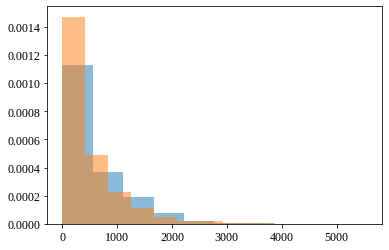

In [311]:
plt.hist(data_dic_array['CAPE'][cond_res & cond_front & cond_radar & pre_frontal], density=True, alpha=.5)
plt.hist(data_dic_array['CAPE'][cond_res & cond_front & cond_radar & post_frontal], density=True, alpha=.5)

(array([0.34579439, 0.18068536, 0.20560748, 0.32087227, 0.13707165,
        0.09034268, 0.07165109, 0.08722741, 0.07165109, 0.04361371,
        0.02492212, 0.01557632, 0.01869159, 0.04049844, 0.01246106,
        0.01869159, 0.01246106, 0.01246106, 0.02180685, 0.01869159,
        0.01246106, 0.02803738, 0.00311526, 0.01869159, 0.01557632,
        0.01557632, 0.02180685, 0.04049844, 0.02180685, 0.01246106,
        0.00623053, 0.00623053, 0.00623053, 0.00934579, 0.00311526,
        0.00311526, 0.00311526, 0.00623053, 0.01557632]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
        16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5]),
 <BarContainer object of 39 artists>)

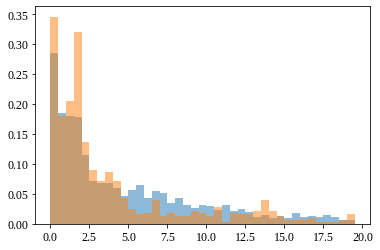

In [76]:
plt.hist(R[cond_res & cond_front & cond_radar_syd & pre_frontal], density=True, alpha=.5, bins=np.arange(0, 20, .5))
plt.hist(R[cond_res & cond_front & cond_radar_syd & post_frontal], density=True, alpha=.5, bins=np.arange(0, 20, .5))

In [75]:
print(np.median(R[cond_res & cond_front & cond_radar_syd & pre_frontal]))
print(np.median(R[cond_res & cond_front & cond_radar_syd & post_frontal]))

3.5020512517491387
2.0773412631605135


<BarContainer object of 6 artists>

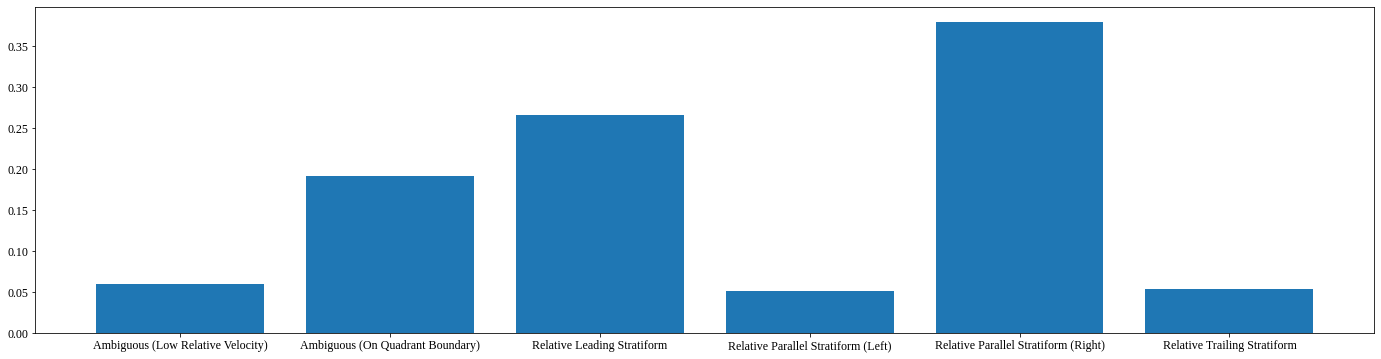

In [88]:
fig, ax = plt.subplots(figsize=(24, 6))

a, b = np.unique(data_dic_array['rel_offset_type'][cond_res & cond_front & cond_radar_syd & pre_frontal], return_counts=True)

ax.bar(a, b/np.sum(b))

<BarContainer object of 6 artists>

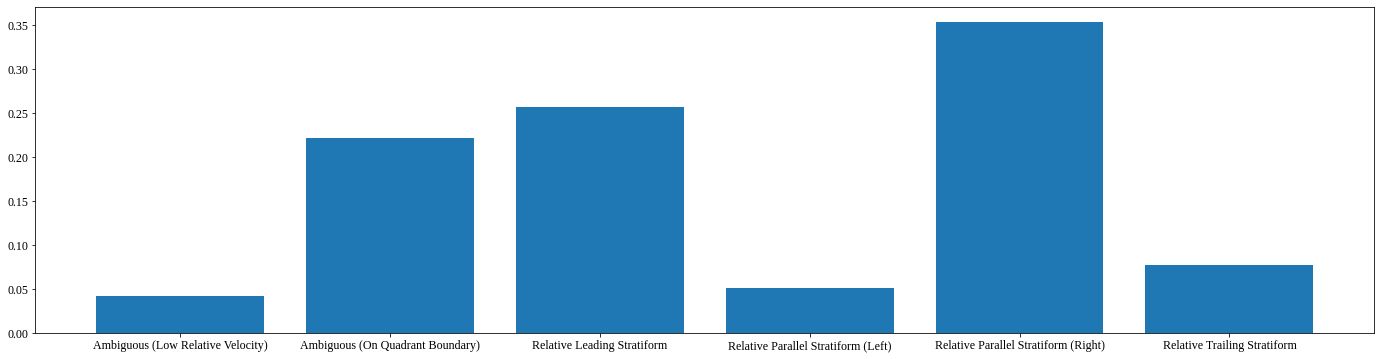

In [89]:
fig, ax = plt.subplots(figsize=(24, 6))

a, b = np.unique(data_dic_array['rel_offset_type'][cond_res & cond_front & cond_radar_syd & post_frontal], return_counts=True)

ax.bar(a, b/np.sum(b))

(array([2.39317077e-03, 1.41762130e-03, 6.61445809e-04, 3.58975615e-04,
        1.26306235e-04, 4.65338760e-05, 2.82527105e-05, 1.32953932e-05,
        6.64769658e-06, 9.97154487e-06]),
 array([   3.23878609,  200.78053923,  398.32229237,  595.86404551,
         793.40579864,  990.94755178, 1188.48930492, 1386.03105806,
        1583.57281119, 1781.11456433, 1978.65631747]),
 <BarContainer object of 10 artists>)

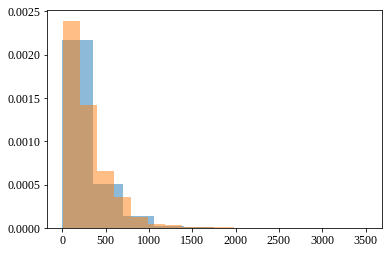

In [312]:
plt.hist(.5*delUsqrd[cond_res & cond_front & cond_radar & pre_frontal & AKE_cond], density=True, alpha=.5)
plt.hist(.5*delUsqrd[cond_res & cond_front & cond_radar & post_frontal & AKE_cond], density=True, alpha=.5)

(array([0.72877536, 0.29075883, 0.18707739, 0.19909842, 0.10217881,
        0.09842224, 0.07588279, 0.05860255, 0.05484598, 0.0353118 ,
        0.03681443, 0.02704733, 0.01577761, 0.0202855 , 0.01728024,
        0.0150263 , 0.01126972, 0.01352367, 0.01202104]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
        6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5]),
 <BarContainer object of 19 artists>)

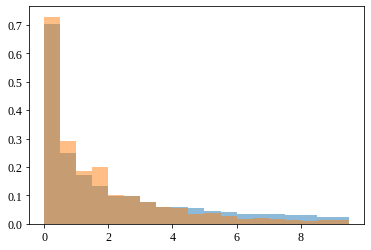

In [313]:
plt.hist(R[cond_res & cond_front & cond_radar & pre_frontal & AKE_cond], density=True, alpha=.5, bins=np.arange(0,10,.5))
plt.hist(R[cond_res & cond_front & cond_radar & post_frontal & AKE_cond], density=True, alpha=.5, bins=np.arange(0,10,.5))

In [315]:
print(np.median(R[cond_res & cond_front & cond_radar & pre_frontal & AKE_cond]))
print(np.median(R[cond_res & cond_front & cond_radar & post_frontal & AKE_cond]))

1.7527556244424736
1.2991948254262211


# Seasonal

In [134]:
months = pd.DatetimeIndex(data_dic_array['time']).month

sum_cond = np.zeros_like(months).astype(bool)
for m in [12, 1, 2]:
    sum_cond = sum_cond | (months == m)
    
aut_cond = np.zeros_like(months).astype(bool)
for m in [3, 4, 5]:
    aut_cond = aut_cond | (months == m)
    
win_cond = np.zeros_like(months).astype(bool)
for m in [6, 7, 8]:
    win_cond = win_cond | (months == m)
    
spr_cond = np.zeros_like(months).astype(bool)
for m in [9, 10, 11]:
    spr_cond = spr_cond | (months == m) 

In [135]:
# mid-lat
cond_radar_ml = np.zeros_like(data_dic_array['radar']).astype(bool)
for r in [70, 31, 48, 32, 33, 27, 46, 64, 14, 49, 2, 68, 55, 69, 40, 3, 71, 54, 4]:
    cond_radar_ml = cond_radar_ml | (data_dic_array['radar'] == r)

cond_radar_melb = np.zeros_like(data_dic_array['radar']).astype(bool)
for r in [2, 49, 68]:
    cond_radar_melb = cond_radar_melb | (data_dic_array['radar'] == r)
    
cond_radar_syd = np.zeros_like(data_dic_array['radar']).astype(bool)
for r in [3, 54, 71]:
    cond_radar_syd = cond_radar_syd | (data_dic_array['radar'] == r)
    
cond_radar_bris = np.zeros_like(data_dic_array['radar']).astype(bool)
for r in [50, 66, 8]:
    cond_radar_bris = cond_radar_bris | (data_dic_array['radar'] == r)
    
cond_radar_cairns = np.zeros_like(data_dic_array['radar']).astype(bool)
for r in [19, 73, 24]:
    cond_radar_cairns = cond_radar_cairns | (data_dic_array['radar'] == r)
    
cond_radar_darwin = np.zeros_like(data_dic_array['radar']).astype(bool)
for r in [63, 77, 42]:
    cond_radar_darwin = cond_radar_darwin | (data_dic_array['radar'] == r)
    
cond_radar_broome = np.zeros_like(data_dic_array['radar']).astype(bool)
for r in [29, 16, 17]:
    cond_radar_broome = cond_radar_broome | (data_dic_array['radar'] == r)
    
cond_radar_perth = np.zeros_like(data_dic_array['radar']).astype(bool)
for r in [70, 31, 32]:
    cond_radar_perth = cond_radar_perth | (data_dic_array['radar'] == r)
    
cond_radar_adelaide = np.zeros_like(data_dic_array['radar']).astype(bool)
for r in [46, 64, 27]:
    cond_radar_adelaide = cond_radar_adelaide | (data_dic_array['radar'] == r)

In [136]:
cond = cond_res & cond_radar_adelaide & sum_cond

distance_r = data_dic_array['distance'][cond & cond_front]/1e3
direction_r = (90 - data_dic_array['direction'][cond & cond_front]) % 360

frontal_sample_size = len(distance_r)
res_sample_size = len(data_dic_array['distance'][cond])
print('Percentage Frontal:')
pct_frontal = frontal_sample_size/res_sample_size*100 
print(frontal_sample_size/res_sample_size*100)

NameError: name 'cond_front' is not defined

In [137]:
print(len(R[cond_res & cond_radar & cond_rls & cond_dst & win_cond]))

print(np.median(R[cond_res & sum_cond & cond_radar]))
print(np.median(R[cond_res & aut_cond & cond_radar]))
print(np.median(R[cond_res & win_cond & cond_radar]))
print(np.median(R[cond_res & spr_cond & cond_radar]))

NameError: name 'R' is not defined

In [138]:
print(np.median(data_dic_array['distance'][cond_res & sum_cond & cond_radar_melb & cond_front])/1e3)
print(np.median(data_dic_array['distance'][cond_res & aut_cond & cond_radar_melb & cond_front])/1e3)
print(np.median(data_dic_array['distance'][cond_res & win_cond & cond_radar_melb & cond_front])/1e3)
print(np.median(data_dic_array['distance'][cond_res & spr_cond & cond_radar_melb & cond_front])/1e3)

NameError: name 'cond_front' is not defined

In [139]:
np.argwhere([1,23] == 44)

array([], shape=(0, 0), dtype=int64)

In [140]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
offset_c = [colors[i] for i in [0, 1, 2, 4]]
inflow_c = [colors[i] for i in [0, 1, 2, 4, 5]]
tilt_c = [colors[i] for i in [0, 1, 5]]

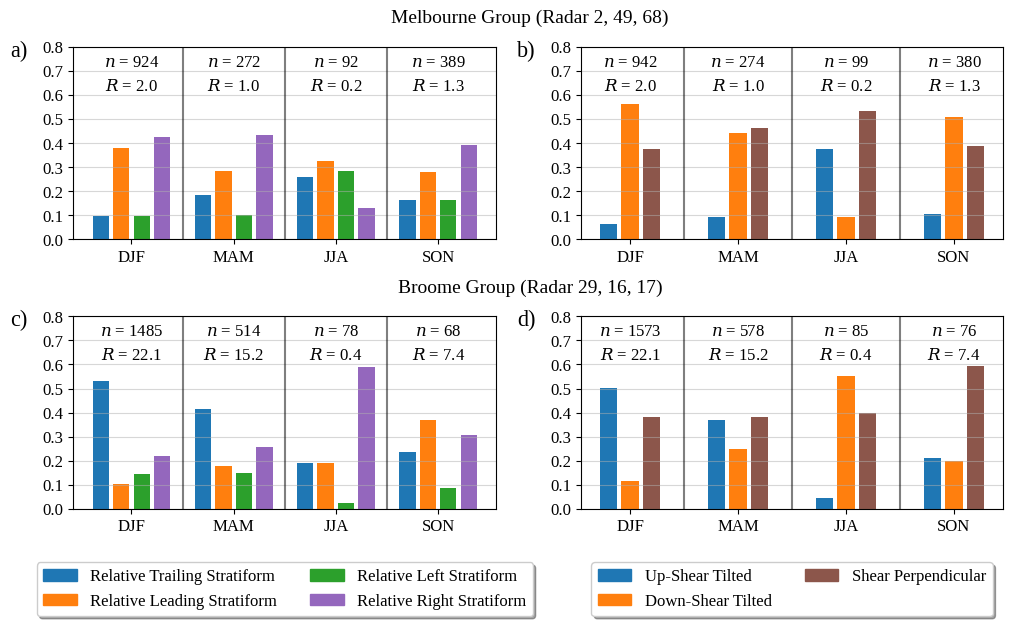

In [289]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

cl.init_fonts()

plot_seasonal_offset(fig, axes[0,0], cond_radar_melb, y_lim=.8)
plot_seasonal_tilt(fig, axes[0,1], cond_radar_melb, y_lim=.8)

plot_seasonal_offset(fig, axes[1,0], cond_radar_broome, y_lim=.8)
plot_seasonal_tilt(fig, axes[1,1], cond_radar_broome, y_lim=.8)

offset_types = [
    'Relative Trailing Stratiform', 'Relative Leading Stratiform', 'Relative Parallel Stratiform (Left)',
    'Relative Parallel Stratiform (Right)']
tilt_types = [
    'Up-Shear Tilted', 'Down-Shear Tilted', 'Ambiguous (Perpendicular Shear)']

offset_labels = ['Relative Trailing Stratiform', 'Relative Leading Stratiform', 'Relative Left Stratiform',
    'Relative Right Stratiform']
tilt_labels = [
    'Up-Shear Tilted', 'Down-Shear Tilted', 'Shear Perpendicular']

handles_off = [plt.Rectangle((0,0),1,1, color=offset_c[i]) for i in range(len(offset_types))]
handles_tilt = [plt.Rectangle((0,0),1,1, color=tilt_c[i]) for i in range(len(tilt_types))]
axes[1,0].legend(
    handles_off, offset_labels, loc='lower center',
    bbox_to_anchor=(.5, -.6),
    ncol=2, fancybox=True, shadow=True)
axes[1,1].legend(
    handles_tilt, tilt_labels, loc='lower center',
    bbox_to_anchor=(.5, -.6),
    ncol=2, fancybox=True, shadow=True)

axes[0,0].text(
    21, .9, 'Melbourne Group (Radar 2, 49, 68)', horizontalalignment='center', fontsize=14)
axes[1,0].text(
    21, .9, 'Broome Group (Radar 29, 16, 17)', horizontalalignment='center', fontsize=14)

plt.subplots_adjust(hspace=.4)

cl.make_subplot_labels(axes.flatten(), y_shift=-.05)

plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/phd/AUS_MCS_paper/seasonal.png',
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

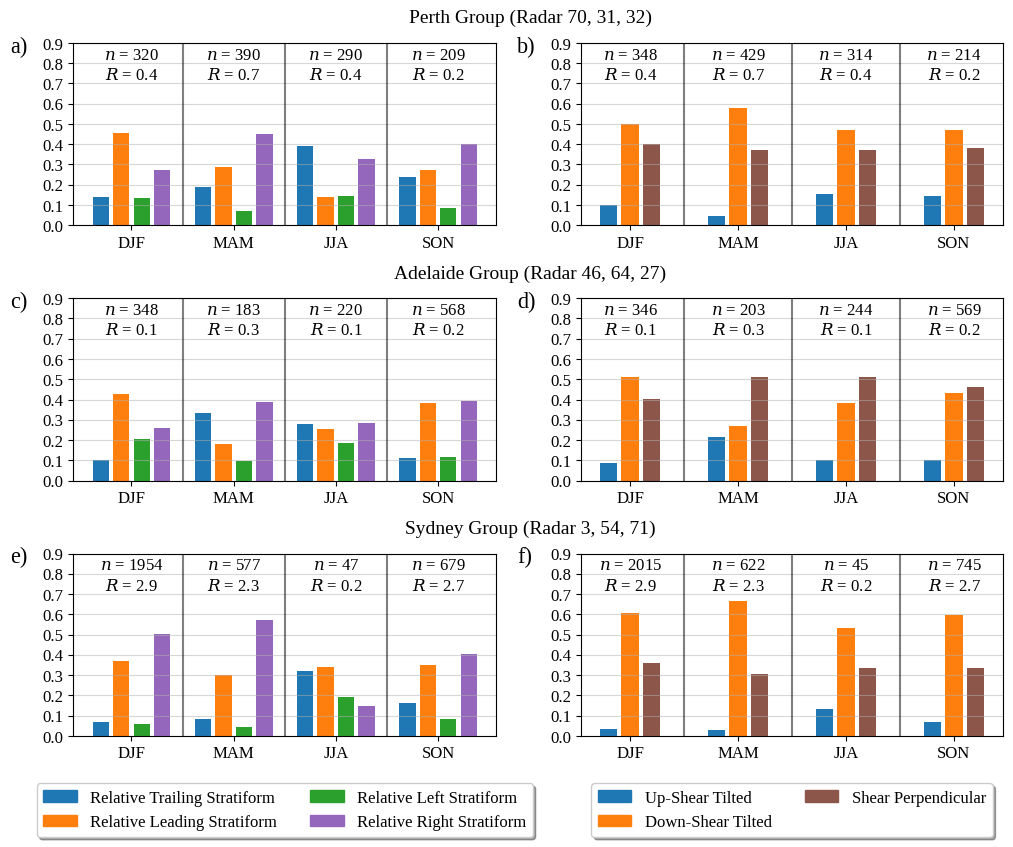

In [296]:
fig, axes = plt.subplots(3, 2, figsize=(12, 9))

y_lim=.9

plot_seasonal_offset(fig, axes[0,0], cond_radar_perth, y_lim)
plot_seasonal_tilt(fig, axes[0,1], cond_radar_perth, y_lim)

plot_seasonal_offset(fig, axes[1,0], cond_radar_adelaide, y_lim)
plot_seasonal_tilt(fig, axes[1,1], cond_radar_adelaide, y_lim)

plot_seasonal_offset(fig, axes[2,0], cond_radar_syd, y_lim)
plot_seasonal_tilt(fig, axes[2,1], cond_radar_syd, y_lim)

offset_types = [
    'Relative Trailing Stratiform', 'Relative Leading Stratiform', 'Relative Parallel Stratiform (Left)',
    'Relative Parallel Stratiform (Right)']
tilt_types = [
    'Up-Shear Tilted', 'Down-Shear Tilted', 'Ambiguous (Perpendicular Shear)']

offset_labels = ['Relative Trailing Stratiform', 'Relative Leading Stratiform', 'Relative Left Stratiform',
    'Relative Right Stratiform']
tilt_labels = [
    'Up-Shear Tilted', 'Down-Shear Tilted', 'Shear Perpendicular']

axes[0,0].text(
    21, 1, 'Perth Group (Radar 70, 31, 32)', horizontalalignment='center', fontsize=14)
axes[1,0].text(
    21, 1, 'Adelaide Group (Radar 46, 64, 27)', horizontalalignment='center', fontsize=14)
axes[2,0].text(
    21, 1, 'Sydney Group (Radar 3, 54, 71)', horizontalalignment='center', fontsize=14)

handles_off = [plt.Rectangle((0,0),1,1, color=offset_c[i]) for i in range(len(offset_types))]
handles_tilt = [plt.Rectangle((0,0),1,1, color=tilt_c[i]) for i in range(len(tilt_types))]
axes[2,0].legend(
    handles_off, offset_labels, loc='lower center',
    bbox_to_anchor=(.5, -.6),
    ncol=2, fancybox=True, shadow=True)
axes[2,1].legend(
    handles_tilt, tilt_labels, loc='lower center',
    bbox_to_anchor=(.5, -.6),
    ncol=2, fancybox=True, shadow=True)

plt.subplots_adjust(hspace=.4)

# plt.subplots_adjust(hspace=.5)

cl.make_subplot_labels(axes.flatten(), y_shift=-.05)

plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/phd/AUS_MCS_paper/seasonal_mid.png',
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

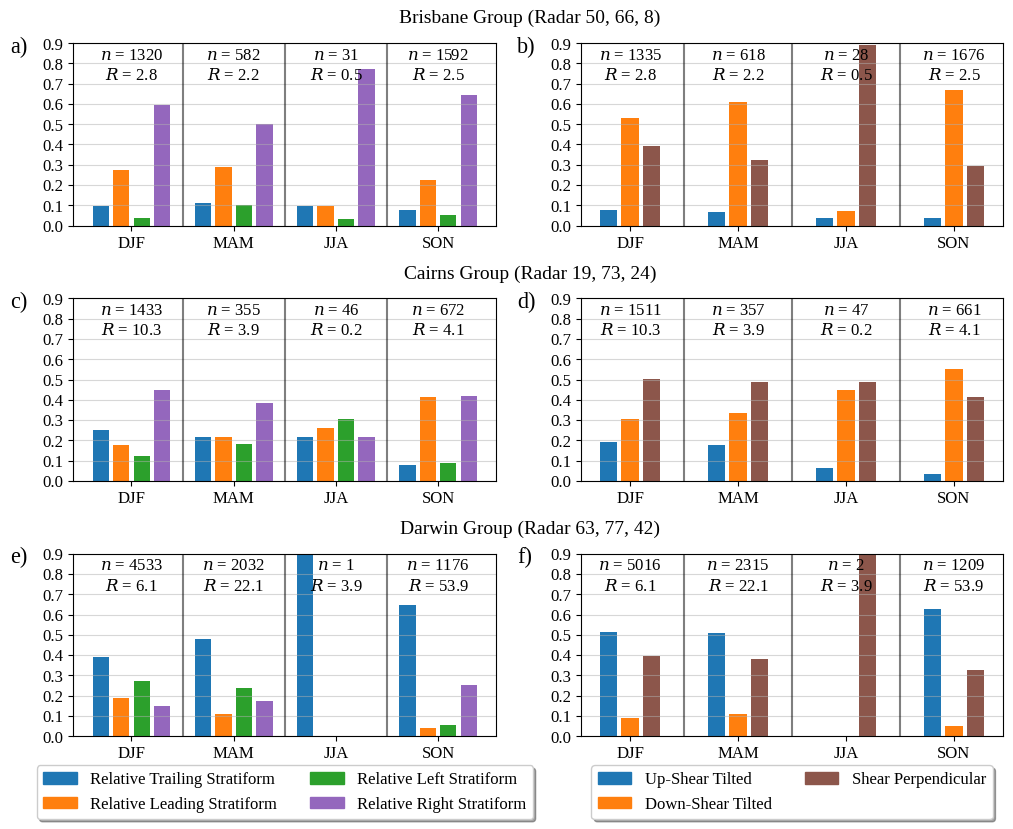

In [294]:
fig, axes = plt.subplots(3, 2, figsize=(12, 9))

y_lim=.9

plot_seasonal_offset(fig, axes[0,0], cond_radar_bris, y_lim)
plot_seasonal_tilt(fig, axes[0,1], cond_radar_bris, y_lim)

plot_seasonal_offset(fig, axes[1,0], cond_radar_cairns, y_lim)
plot_seasonal_tilt(fig, axes[1,1], cond_radar_cairns, y_lim)

plot_seasonal_offset(fig, axes[2,0], cond_radar_darwin, y_lim)
plot_seasonal_tilt(fig, axes[2,1], cond_radar_darwin, y_lim)

offset_types = [
    'Relative Trailing Stratiform', 'Relative Leading Stratiform', 'Relative Parallel Stratiform (Left)',
    'Relative Parallel Stratiform (Right)']
tilt_types = [
    'Up-Shear Tilted', 'Down-Shear Tilted', 'Ambiguous (Perpendicular Shear)']

offset_labels = ['Relative Trailing Stratiform', 'Relative Leading Stratiform', 'Relative Left Stratiform',
    'Relative Right Stratiform']
tilt_labels = [
    'Up-Shear Tilted', 'Down-Shear Tilted', 'Shear Perpendicular']

handles_off = [plt.Rectangle((0,0),1,1, color=offset_c[i]) for i in range(len(offset_types))]
handles_tilt = [plt.Rectangle((0,0),1,1, color=tilt_c[i]) for i in range(len(tilt_types))]
axes[2,0].legend(
    handles_off, offset_labels, loc='lower center',
    bbox_to_anchor=(.5, -.5),
    ncol=2, fancybox=True, shadow=True)
axes[2,1].legend(
    handles_tilt, tilt_labels, loc='lower center',
    bbox_to_anchor=(.5, -.5),
    ncol=2, fancybox=True, shadow=True)

axes[0,0].text(
    21, 1, 'Brisbane Group (Radar 50, 66, 8)', horizontalalignment='center', fontsize=14)
axes[1,0].text(
    21, 1, 'Cairns Group (Radar 19, 73, 24)', horizontalalignment='center', fontsize=14)
axes[2,0].text(
    21, 1, 'Darwin Group (Radar 63, 77, 42)', horizontalalignment='center', fontsize=14)

plt.subplots_adjust(hspace=.4)
cl.make_subplot_labels(axes.flatten(), y_shift=-.05)

plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/phd/AUS_MCS_paper/seasonal_trop.png',
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

In [35]:
def plot_seasonal_offset(fig, ax, cond_radar, y_lim=1):

    txt_height = y_lim - .08
    txt_height_2 = y_lim - .18
    
    types = [
        'Relative Trailing Stratiform', 'Relative Leading Stratiform', 'Relative Parallel Stratiform (Left)',
        'Relative Parallel Stratiform (Right)']
    a, b = np.unique(data_dic_array['rel_offset_type'][cond_res & sum_cond & cond_radar], return_counts=True)
    counts = []
    for t in types:
        ind = np.argwhere(a == t)
        if len(ind) == 0:
            counts.append(0)
        else:
            counts.append(b[ind[0,0]])
    ax.bar(np.arange(4), counts/sum(counts), color=offset_c)
    ax.text(1.5, txt_height, r'$n$ = {}'.format(np.sum(counts)), horizontalalignment='center')
    R_season = np.median(R[cond_res & sum_cond & cond_radar])
    ax.text(1.5, txt_height_2, r'$R$ = {:.1f}'.format(R_season), horizontalalignment='center')

    a, b = np.unique(data_dic_array['rel_offset_type'][cond_res & aut_cond & cond_radar], return_counts=True)
    counts = []
    for t in types:
        ind = np.argwhere(a == t)
        if len(ind) == 0:
            counts.append(0)
        else:
            counts.append(b[ind[0,0]])
    ax.bar(np.arange(4)+5, counts/sum(counts), color=offset_c)
    ax.text(6.5, txt_height, r'$n$ = {}'.format(np.sum(counts)),  horizontalalignment='center')
    R_season = np.median(R[cond_res & aut_cond & cond_radar])
    ax.text(6.5, txt_height_2, r'$R$ = {:.1f}'.format(R_season), horizontalalignment='center')

    a, b = np.unique(data_dic_array['rel_offset_type'][cond_res & win_cond & cond_radar], return_counts=True)
    counts = []
    for t in types:
        ind = np.argwhere(a == t)
        if len(ind) == 0:
            counts.append(0)
        else:
            counts.append(b[ind[0,0]])
    ax.bar(np.arange(4)+10, counts/sum(counts), color=offset_c)
    ax.text(11.5, txt_height, r'$n$ = {}'.format(np.sum(counts)), horizontalalignment='center')
    R_season = np.median(R[cond_res & win_cond & cond_radar])
    ax.text(11.5, txt_height_2, r'$R$ = {:.1f}'.format(R_season), horizontalalignment='center')

    a, b = np.unique(data_dic_array['rel_offset_type'][cond_res & spr_cond & cond_radar], return_counts=True)
    counts = []
    for t in types:
        ind = np.argwhere(a == t)
        if len(ind) == 0:
            counts.append(0)
        else:
            counts.append(b[ind[0,0]])
    ax.bar(np.arange(4)+15, counts/sum(counts), color=offset_c)
    ax.text(16.5, txt_height, r'$n$ = {}'.format(np.sum(counts)), horizontalalignment='center')
    R_season = np.median(R[cond_res & spr_cond & cond_radar])
    ax.text(16.5, txt_height_2, r'$R$ = {:.1f}'.format(R_season), horizontalalignment='center')

    ax.set_xticks(np.array([2.5, 7.5, 12.5, 17.5])-1)
    ax.set_xticklabels(['DJF', 'MAM', 'JJA', 'SON'])
#     ax.legend()
    
    ax.set_yticks(np.arange(0, y_lim+.1, .1))
    ax.set_ylim([0, y_lim])
    
    ax.grid(which='major', alpha=0.5, axis='y')
    ax.plot([4, 4], [0, y_lim], alpha=.5, color='k')
    ax.plot([9, 9], [0, y_lim], alpha=.5, color='k')
    ax.plot([14, 14], [0, y_lim], alpha=.5, color='k')
#     ax.plot([20, 20], [0, y_lim], alpha=.5, color='k')

#     print('R')
#     print(np.median(R[cond_res & sum_cond & cond_radar]))
#     print(np.median(R[cond_res & aut_cond & cond_radar]))
#     print(np.median(R[cond_res & win_cond & cond_radar]))
#     print(np.median(R[cond_res & spr_cond & cond_radar]))
    
#     print('RH')
#     print(np.median(data_dic_array['av_rh_bfl'][cond_res & sum_cond & cond_radar]))
#     print(np.median(data_dic_array['av_rh_bfl'][cond_res & aut_cond & cond_radar]))
#     print(np.median(data_dic_array['av_rh_bfl'][cond_res & win_cond & cond_radar]))
#     print(np.median(data_dic_array['av_rh_bfl'][cond_res & spr_cond & cond_radar]))

In [36]:
def plot_seasonal_tilt(fig, ax, cond_radar, y_lim=1):
    
    txt_height = y_lim - .08
    txt_height_2 = y_lim - .18
    
    types = [
        'Up-Shear Tilted', 'Down-Shear Tilted', 'Ambiguous (Perpendicular Shear)']
    a, b = np.unique(data_dic_array['tilt_type'][cond_res & sum_cond & cond_radar], return_counts=True)
    counts = []
    for t in types:
        ind = np.argwhere(a == t)
        if len(ind) == 0:
            counts.append(0)
        else:
            counts.append(b[ind[0,0]])
    ax.bar(np.arange(3), counts/sum(counts), color=tilt_c)
    ax.text(1, txt_height, r'$n$ = {}'.format(np.sum(counts)),  horizontalalignment='center')
    R_season = np.median(R[cond_res & sum_cond & cond_radar])
    ax.text(1, txt_height_2, r'$R$ = {:.1f}'.format(R_season), horizontalalignment='center')

    a, b = np.unique(data_dic_array['tilt_type'][cond_res & aut_cond & cond_radar], return_counts=True)
    counts = []
    for t in types:
        ind = np.argwhere(a == t)
        if len(ind) == 0:
            counts.append(0)
        else:
            counts.append(b[ind[0,0]])
    ax.bar(np.arange(3)+5, counts/sum(counts), color=tilt_c)
    ax.text(6, txt_height, r'$n$ = {}'.format(np.sum(counts)),  horizontalalignment='center')
    R_season = np.median(R[cond_res & aut_cond & cond_radar])
    ax.text(6, txt_height_2, r'$R$ = {:.1f}'.format(R_season), horizontalalignment='center')

    a, b = np.unique(data_dic_array['tilt_type'][cond_res & win_cond & cond_radar], return_counts=True)
    counts = []
    for t in types:
        ind = np.argwhere(a == t)
        if len(ind) == 0:
            counts.append(0)
        else:
            counts.append(b[ind[0,0]])
    ax.bar(np.arange(3)+10, counts/sum(counts), color=tilt_c)
    ax.text(11, txt_height, r'$n$ = {}'.format(np.sum(counts)),  horizontalalignment='center')
    R_season = np.median(R[cond_res & win_cond & cond_radar])
    ax.text(11, txt_height_2, r'$R$ = {:.1f}'.format(R_season), horizontalalignment='center')

    a, b = np.unique(data_dic_array['tilt_type'][cond_res & spr_cond & cond_radar], return_counts=True)
    counts = []
    for t in types:
        ind = np.argwhere(a == t)
        if len(ind) == 0:
            counts.append(0)
        else:
            counts.append(b[ind[0,0]])
    ax.bar(np.arange(3)+15, counts/sum(counts), color=tilt_c)
    ax.text(16, txt_height, r'$n$ = {}'.format(np.sum(counts)), horizontalalignment='center')
    R_season = np.median(R[cond_res & spr_cond & cond_radar])
    ax.text(16, txt_height_2, r'$R$ = {:.1f}'.format(R_season), horizontalalignment='center')
    
    ax.set_xticks(np.array([2.5, 7.5, 12.5, 17.5])-1.5)
    ax.set_xticklabels(['DJF', 'MAM', 'JJA', 'SON'])
    
    ax.set_yticks(np.arange(0, y_lim+.1, .1))
    ax.set_ylim([0, y_lim])
    
    ax.grid(which='major', alpha=0.5, axis='y')
    ax.plot([3.5, 3.5], [0, y_lim], alpha=.5, color='k')
    ax.plot([8.5, 8.5], [0, y_lim], alpha=.5, color='k')
    ax.plot([13.5, 13.5], [0, y_lim], alpha=.5, color='k')

In [37]:
cond_radar = (data_dic_array['radar'] == 17)
pope_cond = (data_dic_array['pope_regime'] == 1) 
plt.hist(data_dic_array[''][cond_res & cond_front & cond_radar])

KeyError: ''

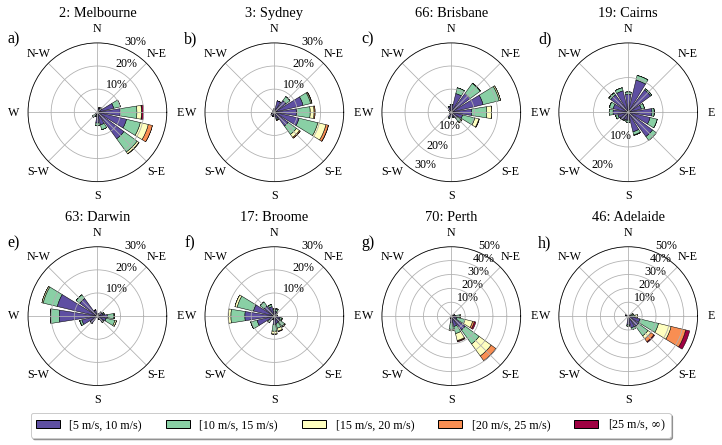

In [38]:
fig = plt.figure(figsize=(12, 7.5))

rose_radars = [2, 3, 66, 19, 63, 17, 70, 46]
radar_labels = [
    '2: Melbourne', '3: Sydney', '66: Brisbane', '19: Cairns',
    '63: Darwin', '17: Broome', '70: Perth', '46: Adelaide']
y_max = [35, 35, 35, 25, 35, 35, 55, 55]
r_pos = [67.5, 67.5, -122.5, -122.5, 67.5, 67.5, 67.5, 67.5]

for i in range(len(rose_radars)):
    r = rose_radars[i]
    ax = fig.add_subplot(2, 4, i+1, projection="windrose")
    cond_radar = (data_dic_array['radar'] == r)
    u_r =  data_dic_array['u_shift'][cond_res & cond_radar]
    v_r =  data_dic_array['v_shift'][cond_res & cond_radar]
    
    distance_r = np.sqrt(u_r**2 + v_r**2)
    direction_r = (90-np.arctan2(v_r, u_r)*180/np.pi) % 360
    
    cmap = cm.get_cmap('Spectral_r', 5)

    ax.bar(
        direction_r, distance_r, normed=True, 
        opening=0.8, edgecolor='k', linewidth=.5, blowto=False,
        bins=np.arange(5, 30, 5), cmap=cmap)
    ax.set_yticks(np.arange(10, y_max[i], step=10))
    tick_labels = np.arange(10, y_max[i], step=10).astype(str)
    tick_labels = [t + '%' for t in tick_labels]
    ax.set_yticklabels(tick_labels)
    ax.set_rlabel_position(r_pos[i])
    ax.set_title(radar_labels[i])

plt.subplots_adjust(hspace=0, wspace=.275)

# ax.set_legend()
leg = plt.legend(
    loc='lower center',
    bbox_to_anchor=(-1.5, -.42),
    ncol=5, fancybox=True, shadow=True, over_label=True)
labels = [
    '[5 m/s, 10 m/s)', '[10 m/s, 15 m/s)', '[15 m/s, 20 m/s)',
    '[20 m/s, 25 m/s)', r'[25 m/s, $\infty$)']
[old.set_text(new) for (old, new) in zip(leg.texts, labels)]

cl.make_subplot_labels(fig.get_axes())

plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/phd/AUS_MCS_paper/ground_rel_rose.png',
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

In [41]:
data_dic_array.keys()

dict_keys(['radar', 'time', 'report', 'pope_regime', 'report_ID', 'raw_sample', 'restricted_sample', 'so_x', 'so_y', 'inflow_type', 'propagation_type', 'tilt_type', 'offset_type', 'rel_offset_type', 'u_trop_shear', 'v_trop_shear', 'av_rh', 'av_rh_bfl', 'av_ee', 'av_ee_bfl', 'orientation', 'u_relative', 'v_relative', 'u_shift', 'v_shift', 'u_shear', 'v_shear', 'CAPE', 'semi_major', 'semi_minor', 'trop_height', 'u_ambient_mean', 'v_ambient_mean', 'MLCAPE100', 'u06', 'v06', 'MUCAPE', 'MLCIN100', 'distance', 'direction', 'MCS_lat', 'MCS_lon', 'front_lat', 'front_lon'])

In [48]:
len(data_dic_array['u' + dset][cond_res & cond_radar])

3462

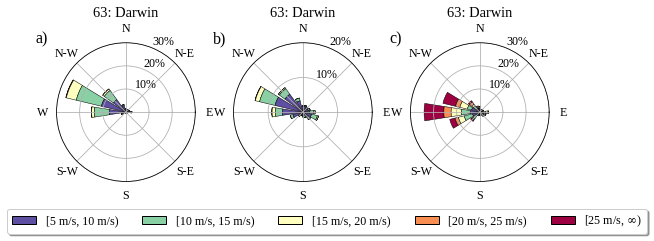

In [57]:
fig = plt.figure(figsize=(12, 7.5))

rose_radars = [63]
radar_labels = ['63: Darwin']
y_max = [35, 25, 35]
r_pos = [67.5]

rose_dset = ['_shear', '06', '_trop_shear']

for i in range(len(rose_dset)):
    r = rose_radars[0]
    dset = rose_dset[i]
    ax = fig.add_subplot(2, 4, i+1, projection="windrose")
    cond_radar = (data_dic_array['radar'] == r)
    u_r =  data_dic_array['u' + dset][cond_res & cond_radar]
    v_r =  data_dic_array['v' + dset][cond_res & cond_radar]
    
    distance_r = np.sqrt(u_r**2 + v_r**2)
    direction_r = (90-np.arctan2(v_r, u_r)*180/np.pi) % 360
    
    cmap = cm.get_cmap('Spectral_r', 5)

    ax.bar(
        direction_r, distance_r, normed=True, 
        opening=0.8, edgecolor='k', linewidth=.5, blowto=False,
        bins=np.arange(5, 30, 5), cmap=cmap)
    ax.set_yticks(np.arange(10, y_max[i], step=10))
    tick_labels = np.arange(10, y_max[i], step=10).astype(str)
    tick_labels = [t + '%' for t in tick_labels]
    ax.set_yticklabels(tick_labels)
    ax.set_rlabel_position(r_pos[0])
    ax.set_title(radar_labels[0])

plt.subplots_adjust(hspace=0, wspace=.275)

# ax.set_legend()
leg = plt.legend(
    loc='lower center',
    bbox_to_anchor=(-.6, -.42),
    ncol=5, fancybox=True, shadow=True, over_label=True)
labels = [
    '[5 m/s, 10 m/s)', '[10 m/s, 15 m/s)', '[15 m/s, 20 m/s)',
    '[20 m/s, 25 m/s)', r'[25 m/s, $\infty$)']
[old.set_text(new) for (old, new) in zip(leg.texts, labels)]

cl.make_subplot_labels(fig.get_axes())

plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/phd/AUS_MCS_paper/darwin_rose.png',
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

KeyError: 'u_ambient_mean'

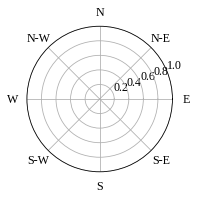

In [115]:
fig = plt.figure(figsize=(12, 7.5))

rose_radars = [2, 3, 66, 19, 63, 17, 70, 46]
radar_labels = [
    '2: Melbourne', '3: Sydney', '66: Brisbane', '19: Cairns',
    '63: Darwin', '17: Broome', '70: Perth', '46: Adelaide']
y_max = [35, 35, 35, 25, 35, 35, 55, 55]
r_pos = [67.5, 67.5, -122.5, -122.5, 67.5, 67.5, 67.5, 67.5]

for i in range(len(rose_radars)):
    r = rose_radars[i]
    ax = fig.add_subplot(2, 4, i+1, projection="windrose")
    cond_radar = (data_dic_array['radar'] == r)
    u_r =  data_dic_array['u_ambient_mean'][cond_res & cond_radar]
    v_r =  data_dic_array['v_ambient_mean'][cond_res & cond_radar]
    
    distance_r = np.sqrt(u_r**2 + v_r**2)
    direction_r = (90-np.arctan2(v_r, u_r)*180/np.pi) % 360
    
    cmap = cm.get_cmap('Spectral_r', 5)

    ax.bar(
        direction_r, distance_r, normed=True, 
        opening=0.8, edgecolor='k', linewidth=.5, blowto=False,
        bins=np.arange(5, 30, 5), cmap=cmap)
    ax.set_yticks(np.arange(10, y_max[i], step=10))
    tick_labels = np.arange(10, y_max[i], step=10).astype(str)
    tick_labels = [t + '%' for t in tick_labels]
    ax.set_yticklabels(tick_labels)
    ax.set_rlabel_position(r_pos[i])
    ax.set_title(radar_labels[i])

plt.subplots_adjust(hspace=0, wspace=.275)

# ax.set_legend()
leg = plt.legend(
    loc='lower center',
    bbox_to_anchor=(-1.5, -.42),
    ncol=5, fancybox=True, shadow=True, over_label=True)
labels = [
    '[5 m/s, 10 m/s)', '[10 m/s, 15 m/s)', '[15 m/s, 20 m/s)',
    '[20 m/s, 25 m/s)', r'[25 m/s, $\infty$)']
[old.set_text(new) for (old, new) in zip(leg.texts, labels)]

cl.make_subplot_labels(fig.get_axes())

plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/phd/AUS_MCS_paper/ground_rel_rose.png',
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

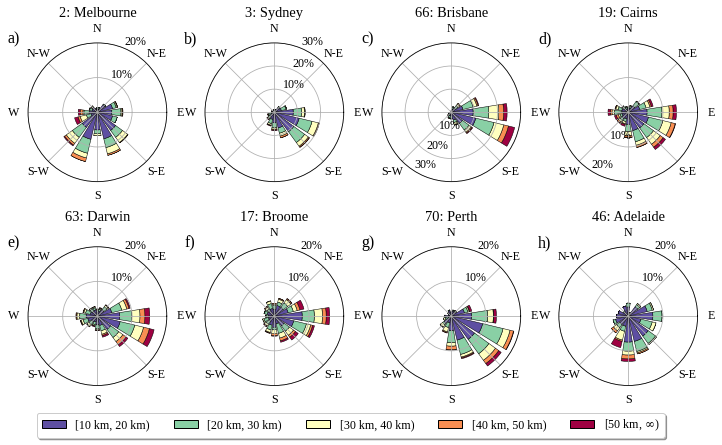

In [82]:
fig = plt.figure(figsize=(12, 7.5))

rose_radars = [2, 3, 66, 19, 63, 17, 70, 46]
radar_labels = [
    '2: Melbourne', '3: Sydney', '66: Brisbane', '19: Cairns',
    '63: Darwin', '17: Broome', '70: Perth', '46: Adelaide']
y_max = [25, 35, 35, 25, 25, 25, 25, 25]
r_pos = [67.5, 67.5, -122.5, -122.5, 67.5, 67.5, 67.5, 67.5]

for i in range(len(rose_radars)):
    r = rose_radars[i]
    ax = fig.add_subplot(2, 4, i+1, projection="windrose")
    cond_radar = (data_dic_array['radar'] == r)
    u_r =  data_dic_array['so_x'][cond_res & cond_radar]/1e3
    v_r =  data_dic_array['so_y'][cond_res & cond_radar]/1e3
    
    distance_r = np.sqrt(u_r**2 + v_r**2)
    direction_r = (90-np.arctan2(v_r, u_r)*180/np.pi) % 360
    
    cmap = cm.get_cmap('Spectral_r', 5)

    ax.bar(
        direction_r, distance_r, normed=True, 
        opening=0.8, edgecolor='k', linewidth=.5, blowto=False,
        bins=np.arange(10, 60, 10), cmap=cmap)
    ax.set_yticks(np.arange(10, y_max[i], step=10))
    tick_labels = np.arange(10, y_max[i], step=10).astype(str)
    tick_labels = [t + '%' for t in tick_labels]
    ax.set_yticklabels(tick_labels)
    ax.set_rlabel_position(r_pos[i])
    ax.set_title(radar_labels[i])

plt.subplots_adjust(hspace=0, wspace=.275)

# ax.set_legend()
leg = plt.legend(
    loc='lower center',
    bbox_to_anchor=(-1.5, -.42),
    ncol=5, fancybox=True, shadow=True, over_label=True)
labels = [
    '[10 km, 20 km)', '[20 km, 30 km)', '[30 km, 40 km)',
    '[40 km, 50 km)', r'[50 km, $\infty$)']
[old.set_text(new) for (old, new) in zip(leg.texts, labels)]

cl.make_subplot_labels(fig.get_axes())

plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/phd/AUS_MCS_paper/so_rose.png',
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

(array([   0., 1218.,  355.,    0.]),
 array([0, 1, 2, 3, 4]),
 <BarContainer object of 4 artists>)

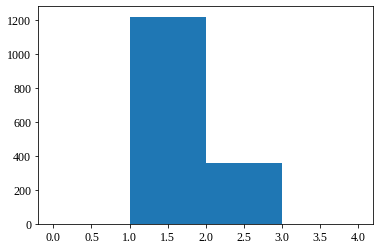

In [113]:
cond_radar = (data_dic_array['radar'] == 17)
plt.hist(data_dic_array['pope_regime'][cond_res & cond_radar], bins=np.arange(0,5,1))

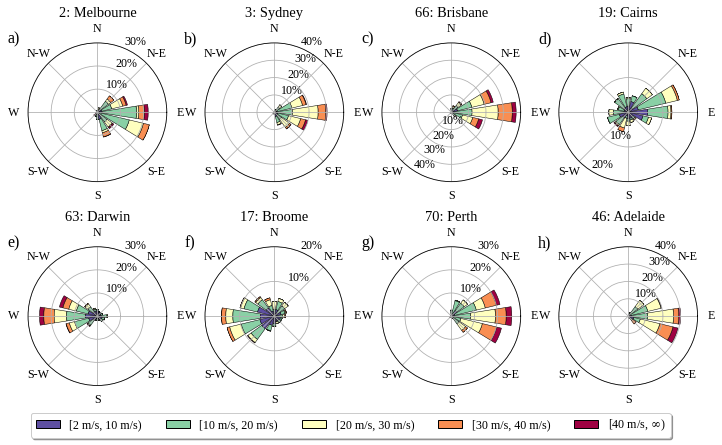

In [99]:
fig = plt.figure(figsize=(12, 7.5))

rose_radars = [2, 3, 66, 19, 63, 17, 70, 46]
radar_labels = [
    '2: Melbourne', '3: Sydney', '66: Brisbane', '19: Cairns',
    '63: Darwin', '17: Broome', '70: Perth', '46: Adelaide']
y_max = [
    35, 45, 45, 25, 
    35, 25, 35, 45]
r_pos = [67.5, 67.5, -122.5, -122.5, 67.5, 67.5, 67.5, 67.5]

for i in range(len(rose_radars)):
    r = rose_radars[i]
    ax = fig.add_subplot(2, 4, i+1, projection="windrose")
    cond_radar = (data_dic_array['radar'] == r)
    u_r =  data_dic_array['u_trop_shear'][cond_res & cond_radar]
    v_r =  data_dic_array['v_trop_shear'][cond_res & cond_radar]
    
    distance_r = np.sqrt(u_r**2 + v_r**2)
    direction_r = (90-np.arctan2(v_r, u_r)*180/np.pi) % 360
    
    cmap = cm.get_cmap('Spectral_r', 5)

    ax.bar(
        direction_r, distance_r, normed=True, 
        opening=0.8, edgecolor='k', linewidth=.5, blowto=False,
        bins=np.array([2,10,20,30,40]), cmap=cmap)
    ax.set_yticks(np.arange(10, y_max[i], step=10))
    tick_labels = np.arange(10, y_max[i], step=10).astype(str)
    tick_labels = [t + '%' for t in tick_labels]
    ax.set_yticklabels(tick_labels)
    ax.set_rlabel_position(r_pos[i])
    ax.set_title(radar_labels[i])

plt.subplots_adjust(hspace=0, wspace=.275)

# ax.set_legend()
leg = plt.legend(
    loc='lower center',
    bbox_to_anchor=(-1.5, -.42),
    ncol=5, fancybox=True, shadow=True, over_label=True)
labels = [
    '[2 m/s, 10 m/s)', '[10 m/s, 20 m/s)', '[20 m/s, 30 m/s)',
    '[30 m/s, 40 m/s)', r'[40 m/s, $\infty$)']
[old.set_text(new) for (old, new) in zip(leg.texts, labels)]

cl.make_subplot_labels(fig.get_axes())

plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/phd/AUS_MCS_paper/trop_shear_rose.png',
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

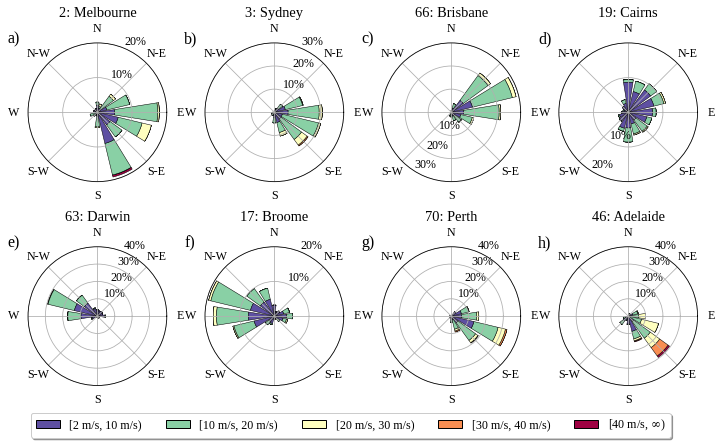

In [104]:
fig = plt.figure(figsize=(12, 7.5))

rose_radars = [2, 3, 66, 19, 63, 17, 70, 46]
radar_labels = [
    '2: Melbourne', '3: Sydney', '66: Brisbane', '19: Cairns',
    '63: Darwin', '17: Broome', '70: Perth', '46: Adelaide']
y_max = [
    25, 35, 35, 25, 
    45, 25, 45, 45]
r_pos = [67.5, 67.5, -122.5, -122.5, 67.5, 67.5, 67.5, 67.5]

for i in range(len(rose_radars)):
    r = rose_radars[i]
    ax = fig.add_subplot(2, 4, i+1, projection="windrose")
    cond_radar = (data_dic_array['radar'] == r)
    u_r =  data_dic_array['u_shear'][cond_res & cond_radar]
    v_r =  data_dic_array['v_shear'][cond_res & cond_radar]
    
    distance_r = np.sqrt(u_r**2 + v_r**2)
    direction_r = (90-np.arctan2(v_r, u_r)*180/np.pi) % 360
    
    cmap = cm.get_cmap('Spectral_r', 5)

    ax.bar(
        direction_r, distance_r, normed=True, 
        opening=0.8, edgecolor='k', linewidth=.5, blowto=False,
        bins=np.array([2,10,20,30,40]), cmap=cmap)
    ax.set_yticks(np.arange(10, y_max[i], step=10))
    tick_labels = np.arange(10, y_max[i], step=10).astype(str)
    tick_labels = [t + '%' for t in tick_labels]
    ax.set_yticklabels(tick_labels)
    ax.set_rlabel_position(r_pos[i])
    ax.set_title(radar_labels[i])

plt.subplots_adjust(hspace=0, wspace=.275)

# ax.set_legend()
leg = plt.legend(
    loc='lower center',
    bbox_to_anchor=(-1.5, -.42),
    ncol=5, fancybox=True, shadow=True, over_label=True)
labels = [
    '[2 m/s, 10 m/s)', '[10 m/s, 20 m/s)', '[20 m/s, 30 m/s)',
    '[30 m/s, 40 m/s)', r'[40 m/s, $\infty$)']
[old.set_text(new) for (old, new) in zip(leg.texts, labels)]

cl.make_subplot_labels(fig.get_axes())

plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/phd/AUS_MCS_paper/low_shear_rose.png',
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

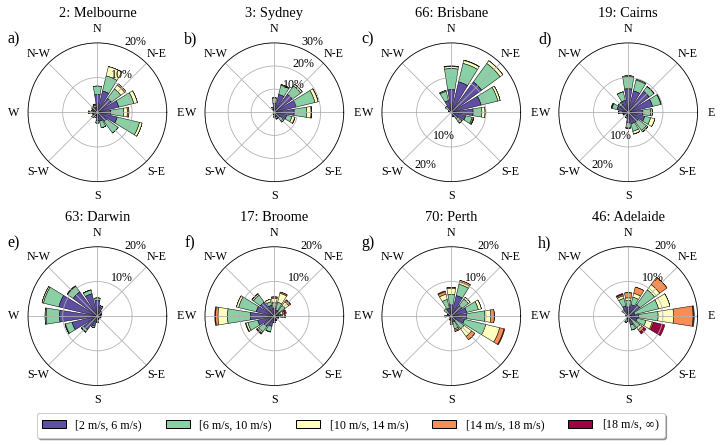

In [84]:
fig = plt.figure(figsize=(12, 7.5))

rose_radars = [2, 3, 66, 19, 63, 17, 70, 46]
radar_labels = [
    '2: Melbourne', '3: Sydney', '66: Brisbane', '19: Cairns',
    '63: Darwin', '17: Broome', '70: Perth', '46: Adelaide']
y_max = [25, 35, 25, 25, 25, 25, 25, 25]
r_pos = [67.5, 67.5, -122.5, -122.5, 67.5, 67.5, 67.5, 67.5]

for i in range(len(rose_radars)):
    r = rose_radars[i]
    ax = fig.add_subplot(2, 4, i+1, projection="windrose")
    cond_radar = (data_dic_array['radar'] == r)
    u_r =  data_dic_array['u_relative'][cond_res & cond_radar]
    v_r =  data_dic_array['v_relative'][cond_res & cond_radar]
    
    distance_r = np.sqrt(u_r**2 + v_r**2)
    direction_r = (90-np.arctan2(v_r, u_r)*180/np.pi) % 360
    
    cmap = cm.get_cmap('Spectral_r', 5)

    ax.bar(
        direction_r, distance_r, normed=True, 
        opening=0.8, edgecolor='k', linewidth=.5, blowto=False,
        bins=np.arange(2, 22, 4), cmap=cmap)
    ax.set_yticks(np.arange(10, y_max[i], step=10))
    tick_labels = np.arange(10, y_max[i], step=10).astype(str)
    tick_labels = [t + '%' for t in tick_labels]
    ax.set_yticklabels(tick_labels)
    ax.set_rlabel_position(r_pos[i])
    ax.set_title(radar_labels[i])

plt.subplots_adjust(hspace=0, wspace=.275)

# ax.set_legend()
leg = plt.legend(
    loc='lower center',
    bbox_to_anchor=(-1.5, -.42),
    ncol=5, fancybox=True, shadow=True, over_label=True)
labels = [
    '[2 m/s, 6 m/s)', '[6 m/s, 10 m/s)', '[10 m/s, 14 m/s)',
    '[14 m/s, 18 m/s)', r'[18 m/s, $\infty$)']
[old.set_text(new) for (old, new) in zip(leg.texts, labels)]

cl.make_subplot_labels(fig.get_axes())

plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/phd/AUS_MCS_paper/wind_rel_rose.png',
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(12, 9))

rose_radars = [2, 71, 66, 63, 17, 70]
radar_labels = [
    '2: Melbourne', '71: Sydney', '66: Brisbane', 
    '63: Darwin', '17: Broome', '70: Perth']
y_max = [35, 35, 35, 35, 35, 55]

for i in range(len(rose_radars)):
    r = rose_radars[i]
    ax = fig.add_subplot(2, 3, i+1, projection="windrose")
    cond_radar = (data_dic_array['radar'] == r)
    u_r =  data_dic_array['u_shift'][cond_res & cond_radar]
    v_r =  data_dic_array['v_shift'][cond_res & cond_radar]
    
    distance_r = np.sqrt(u_r**2 + v_r**2)
    direction_r = (90-np.arctan2(v_r, u_r)*180/np.pi) % 360
    
    cmap = cm.get_cmap('Spectral_r', 5)

    ax.bar(
        direction_r, distance_r, normed=True, 
        opening=0.8, edgecolor='k', linewidth=.5, blowto=False,
        bins=np.arange(5, 35, 5), cmap=cmap)
    ax.set_yticks(np.arange(10, y_max[i], step=10))
    tick_labels = np.arange(10, y_max[i], step=10).astype(str)
    tick_labels = [t + '%' for t in tick_labels]
    ax.set_yticklabels(tick_labels)
    ax.set_rlabel_position(67.5)
    ax.set_title(radar_labels[i])

plt.subplots_adjust(hspace=.18, wspace=.225)

# ax.set_legend()
leg = plt.legend(
    loc='lower center',
    bbox_to_anchor=(-.6, -.3),
    ncol=5, fancybox=True, shadow=True)
labels = [
    '[5 m/s, 10 m/s)', '[10 m/s, 15 m/s)', '[15 m/s, 20 m/s)',
    '[20 m/s, 25 m/s)', r'[25 m/s, 30 m/s)']
[old.set_text(new) for (old, new) in zip(leg.texts, labels)]

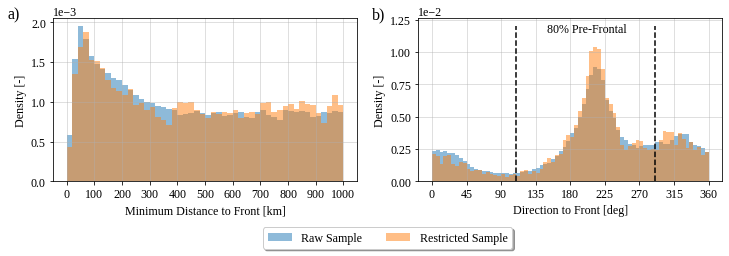

In [197]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

cl.init_fonts()

dbin = 20
axes[0].hist(
    data_dic_array['distance'][cond_raw & cond_front]/1e3, 
    bins = np.arange(0, 1000+dbin, dbin), density=True, alpha=.5, label='Raw Sample')
axes[0].hist(
    data_dic_array['distance'][cond_res & cond_front]/1e3, 
    bins = np.arange(0, 1000+dbin, dbin), density=True, alpha=.5, label='Restricted Sample')

counts_raw = axes[1].hist(
    data_dic_array['direction'][cond_raw & cond_front], 
    bins = np.arange(0, 365, 5), density=True, alpha=.5, label='Raw Sample')
counts_res = axes[1].hist(
    data_dic_array['direction'][cond_res & cond_front], 
    bins = np.arange(0, 365, 5), density=True, alpha=.5, label='Restricted Sample')

axes[0].set_xlabel('Minimum Distance to Front [km]')
axes[0].set_ylabel('Density [-]')

axes[1].set_xlabel('Direction to Front [deg]')
axes[1].set_ylabel('Density [-]')

axes[0].set_xticks(np.arange(0, 1100, 100))
axes[1].set_xticks(np.arange(0, 360+5, 45))

axes[0].ticklabel_format(
    axis='y', style='sci', scilimits=(0, 0))
axes[1].ticklabel_format(
    axis='y', style='sci', scilimits=(0, 0))

axes[0].grid(which='both', alpha=0.5, axis='both')
axes[1].grid(which='both', alpha=0.5, axis='both')

axes[1].plot([110, 110], [0, 1.2e-2], '--k')
axes[1].plot([290, 290], [0, 1.2e-2], '--k')

percent_pf = np.sum(dens[23:23+45])*(bins[2]-bins[1]) 

axes[1].text(150, 1.15e-2, '{:02}% Pre-Frontal'.format(np.round(percent_pf*100).astype(int)))

axes[0].legend(
    loc='lower center', bbox_to_anchor=(1.1, -0.45),
    ncol=2, fancybox=True, shadow=True)

cl.make_subplot_labels(axes.flatten())

In [186]:
dens = counts_raw[0]
bins = counts_raw[1]
np.sum(dens)*(bins[2]-bins[1])

1.0

In [194]:
np.sum(dens[23:23+45])*(bins[2]-bins[1]) + np.sum(dens[:23])*(bins[2]-bins[1]) + np.sum(dens[23+45:])*(bins[2]-bins[1]) 

0.9999999999999999

In [236]:
len(data_dic_array['direction'][cond_front])

1429308

In [235]:
data_dic_array['distance']

array([ 6.66622583,  6.71849199,  6.67319956, ..., 29.25001354,
       29.17293099, 29.25114393])

In [215]:
filename

'/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/national//radar_77/2023//77_2023_05.pkl'

In [27]:
data_dic_array['semi_major'] 

array([40.97357941, 42.57154083, 32.66571045, ..., 22.64796066,
       19.82564926, 20.59614372])

In [28]:
cond_linear = (data_dic_array['semi_major']/data_dic_array['semi_minor'] >= 2)
len(cond_linear[cond_linear])
# len(cond_linear)

891290

In [21]:
len(cond_linear[cond_linear])/len(cond_linear)

0.6235814813881962

In [22]:
cond_rh_1 = (data_dic_array['av_rh_bfl'] < 50)
cond_rh_2 = (data_dic_array['av_rh_bfl'] < 60) & (data_dic_array['av_rh_bfl'] >= 50)
cond_rh_3 = (data_dic_array['av_rh_bfl'] < 70) & (data_dic_array['av_rh_bfl'] >= 60)
cond_rh_4 = (data_dic_array['av_rh_bfl'] < 80) & (data_dic_array['av_rh_bfl'] >= 70)
cond_rh_5 = (data_dic_array['av_rh_bfl'] < 90) & (data_dic_array['av_rh_bfl'] >= 80)
cond_rh_6 = (data_dic_array['av_rh_bfl'] >= 90)

In [23]:
cond_S06_1 = (S06 < 5)
cond_S06_2 = (S06 < 10) & (S06 >= 5)
cond_S06_3 = (S06 < 15) & (S06 >= 10)
cond_S06_4 = (S06 < 20) & (S06 >= 15)
cond_S06_5 = (S06 < 25) & (S06 >= 20)
cond_S06_6 = (S06 >= 25)

NameError: name 'S06' is not defined

In [130]:
matched_IDs = set(data_dic_array['report_ID']) - {''}

In [131]:
matched_IDs

{'24008_3929, ',
 '24008_3929, 24008_6835, ',
 '24008_6835, ',
 '24009_6836, ',
 '24017_6841, ',
 '24019_4827, ',
 '24020_6843, ',
 '24021_6844, ',
 '24023_3933, ',
 '24023_6845, 24023_3932, 24023_4828, ',
 '24026_4830, ',
 '24026_4836, ',
 '24027_6848, ',
 '24027_6849, ',
 '24027_6851, ',
 '24027_6852, ',
 '24028_4832, ',
 '24028_4833, ',
 '24028_4834, ',
 '24028_4835, ',
 '24028_6854, ',
 '24029_4838, ',
 '24030_3934, ',
 '24031_6857, ',
 '24032_6858, ',
 '24034_4839, ',
 '24039_4843, ',
 '24041_4845, ',
 '24041_4846, ',
 '24042_4847, ',
 '24042_6860, ',
 '24043_3936, ',
 '24044_6862, ',
 '24050_4850, ',
 '24053_4852, ',
 '24054_4853, ',
 '24055_4854, ',
 '24057_6864, ',
 '24058_1226, ',
 '24058_1227, ',
 '24058_1228, ',
 '24067_3947, ',
 '24067_3955, ',
 '24069_3948, 24069_4902, ',
 '24069_4903, ',
 '24070_4894, ',
 '24071_4895, ',
 '24071_4895, 24072_3949, ',
 '24072_3949, ',
 '24075_3951, ',
 '24075_3966, ',
 '24075_3967, ',
 '24076_4896, ',
 '24077_7041, ',
 '24083_7045, ',
 '240

In [40]:
matched_IDs[0]

TypeError: 'set' object is not subscriptable

In [25]:
data_dic_array['report']

array(['', '', '', ..., '', '', ''], dtype='<U141')

In [ ]:
matched_IDs

In [146]:
data_dic_array['time'][cond_report][5]

numpy.datetime64('2015-01-03T07:00:00.000000000')

In [161]:
storms[storms.index.duplicated()]

Database    ID           Date/Time     Nearest town State  Latitude  \
Event ID                                                                        
23971         Rain  4217 2012-02-12 10:20:00    COFFS HARBOUR   NSW  -30.3151   
23986     Lighting   323 2012-02-20 06:18:00         TAMWORTH   NSW  -31.0817   
23986         Rain  4227 2012-02-20 06:18:00         TAMWORTH   NSW  -31.0817   
23989         Rain  4230 2012-02-20 15:00:00         CAWONGLA   NSW  -28.5984   
23989         Rain  4231 2012-02-20 15:00:00  DOON DOON CREEK   NSW  -28.4984   
...            ...   ...                 ...              ...   ...       ...   
81639         Rain  5912 2017-12-02 17:30:00           JABIRU    NT  -12.6752   
81640         Rain  5911 2017-12-02 17:30:00       GUNN POINT    NT  -12.1718   
81642         Rain  5916 2017-12-15 04:30:00        KATHERINE    NT  -14.4668   
81649         Rain  5922 2018-02-26 23:15:00        KATHERINE    NT  -14.4668   
81706         Rain  6586 2021-01-06 07:30:00       DALY RIVER    NT  -13.3156   

          Longitude  
Event ID             
23971      153.1345  
23986      150.9345  
23986      150.9345  
23989      153.1011  
23989      153.3011  
...             ...  
81639      132.8337  
81640      130.9943  
81642      132.2668  
81649      132.2668  
81706      130.2516  

[870 rows x 7 columns]

In [30]:
test = np.unique(data_dic_array['report'], return_counts=True)

In [37]:
data_dic_array['report']

array(['', '', '', ..., '', '', ''], dtype='<U141')

In [147]:
data_dic_array['radar'][cond_report][5]

2

In [35]:
len(data_dic_array['report_ID'][cond_report])

1336

In [34]:
len(data_dic_array['time'][cond_report])

1336

In [58]:
storms.loc[32054]

Database    ID           Date/Time       Nearest town State  \
Event ID                                                               
32054        Wind  7366 2015-11-30 08:08:00           LAVERTON   VIC   
32054        Wind  7365 2015-11-30 08:14:00   ESSENDON AIRPORT   VIC   
32054        Wind  7363 2015-11-30 08:15:00        SAINT KILDA   VIC   
32054        Wind  7364 2015-11-30 08:18:00     FAWKNER BEACON   VIC   
32054        Wind  7367 2015-11-30 08:25:00  MOORABBIN AIRPORT   VIC   

          Latitude  Longitude  
Event ID                       
32054     -37.8597   144.7713  
32054     -37.7305   144.9007  
32054     -37.8653   144.9810  
32054     -37.9106   144.9268  
32054     -37.9772   145.0986

In [133]:
ind = 10

print(data_dic_array['report_ID'][matched_cond][ind])
print(data_dic_array['time'][matched_cond][ind])
print(data_dic_array['report'][matched_cond][ind])
print(data_dic_array['radar'][matched_cond][ind])

32054_7366, 32054_7365, 32054_7363, 32054_7364, 
2015-11-30T08:01:00.000000000
Wind, Wind, Wind, Wind, 
2


In [134]:
matched_cond = (data_dic_array['report_ID'] != '')
hail_cond = (data_dic_array['report'] == 'Hail')
rain_cond = (data_dic_array['report'] == 'Rain')
wind_cond = (data_dic_array['report'] == 'Wind')
tornado_cond = (data_dic_array['report'] == 'Tornado')
waterspout_cond = (data_dic_array['report'] == 'Waterspout')

In [135]:
archive_end = storms['Date/Time'].max()

In [136]:
cond_archive = (data_dic_array['time'] <= archive_end)
cond_archive

array([ True,  True,  True, ..., False, False, False])

In [126]:
cond_darwin = (
    (data_dic_array['radar'] == 42) | (data_dic_array['radar'] == 77)
    | (data_dic_array['radar'] == 63) | (data_dic_array['radar'] == 9))

In [127]:
cond_active_monsoon = (data_dic_array['pope_regime'] == 2)
cond_active_monsoon

array([ True,  True,  True, ..., False, False, False])

In [128]:
len(data_dic_array['report_ID'][matched_cond & cond_raw & cond_archive])

990

In [137]:
data_dic_array['report_ID'][matched_cond & cond_raw][38]
data_dic_array['time'][matched_cond & cond_raw][38]
# data_dic_array['radar'][matched_cond & cond_raw][38]

numpy.datetime64('2014-11-05T04:48:00.000000000')

In [75]:
len(storms['ID'])

2223

In [89]:
storms[storms['ID']==4159]

Database    ID           Date/Time Nearest town State  Latitude  \
Event ID                                                                   
24434        Hail  4159 2015-12-01 04:50:00    Rappville   NSW  -29.0817   
31934        Rain  4159 2012-02-09 09:30:00   Pennyroyal   VIC  -38.4210   

          Longitude  
Event ID             
24434      152.9511  
31934      143.8348

In [93]:
storms[storms.index.duplicated()]

Database    ID           Date/Time     Nearest town State  Latitude  \
Event ID                                                                        
23971         Rain  4217 2012-02-12 10:20:00    COFFS HARBOUR   NSW  -30.3151   
23986     Lighting   323 2012-02-20 06:18:00         TAMWORTH   NSW  -31.0817   
23986         Rain  4227 2012-02-20 06:18:00         TAMWORTH   NSW  -31.0817   
23989         Rain  4230 2012-02-20 15:00:00         CAWONGLA   NSW  -28.5984   
23989         Rain  4231 2012-02-20 15:00:00  DOON DOON CREEK   NSW  -28.4984   
...            ...   ...                 ...              ...   ...       ...   
81639         Rain  5912 2017-12-02 17:30:00           JABIRU    NT  -12.6752   
81640         Rain  5911 2017-12-02 17:30:00       GUNN POINT    NT  -12.1718   
81642         Rain  5916 2017-12-15 04:30:00        KATHERINE    NT  -14.4668   
81649         Rain  5922 2018-02-26 23:15:00        KATHERINE    NT  -14.4668   
81706         Rain  6586 2021-01-06 07:30:00       DALY RIVER    NT  -13.3156   

          Longitude  
Event ID             
23971      153.1345  
23986      150.9345  
23986      150.9345  
23989      153.1011  
23989      153.3011  
...             ...  
81639      132.8337  
81640      130.9943  
81642      132.2668  
81649      132.2668  
81706      130.2516  

[870 rows x 7 columns]

# Get Archive Probabilities

In [31]:
def get_ind_list(cond):
    all_IDs = []
    all_supp_IDs = []
    all_types = []
    for i in range(len(data_dic_array['report_ID'][cond])):
    #     import pdb; pdb.set_trace()
        IDs_i = np.array(data_dic_array['report_ID'][cond][i].split(', '))
        IDs_i = list(IDs_i[IDs_i != ''])

        types_i = np.array(data_dic_array['report'][cond][i].split(', '))
        types_i = list(types_i[types_i != ''])

        event_IDs_i = [IDs_i[j].split('_')[0] for j in range(len(IDs_i))]
        supp_IDs_i = [IDs_i[j].split('_')[1] for j in range(len(IDs_i))]
        
        cond_lw = (np.array(types_i) != 'Lightning') & (np.array(types_i) != 'Waterspout')
        event_IDs_i = list(np.array(event_IDs_i)[cond_lw])
        supp_IDs_i = list(np.array(supp_IDs_i)[cond_lw])
        types_i = list(np.array(types_i)[cond_lw])

        all_IDs += event_IDs_i
        all_supp_IDs += supp_IDs_i
        all_types += types_i
    return np.array(all_IDs), np.array(all_supp_IDs), np.array(all_types)

In [32]:
len(all_IDs)

NameError: name 'all_IDs' is not defined

In [74]:
cond = np.zeros(len(storms)).astype(bool)
for hazard in ['Hail', 'Rain', 'Wind', 'Tornado']: 
    cond = cond | (storms['Database'] == hazard)

In [75]:
storms_rest = storms[cond]
storms_rest

Database    ID           Date/Time          Nearest town State  \
Event ID                                                                  
24008        Hail  3929 2012-08-23 07:15:00              NARRABRI   NSW   
24008        Wind  6835 2012-08-23 07:18:00              NARRABRI   NSW   
24009        Wind  6836 2012-08-23 06:03:00           MOUNT BOYCE   NSW   
24010        Hail  3930 2012-10-14 06:50:00              WYRALLAH   NSW   
24011        Wind  6837 2012-10-30 05:07:00       GRAFTON AIRPORT   NSW   
...           ...   ...                 ...                   ...   ...   
81708        Rain  6588 2021-02-05 07:15:00  SEVENTEEN MILE CREEK    NT   
81709        Rain  6589 2021-02-17 05:30:00          HOWARD RIVER    NT   
81710        Rain  6590 2021-02-22 11:30:00            MAUD CREEK    NT   
81711        Rain  6591 2021-02-23 06:30:00        ADELAIDE RIVER    NT   
81714        Wind  8293 2021-03-29 06:14:00           DARWIN CITY    NT   

          Latitude  Longitude  
Event ID                       
24008     -30.3317   149.7678  
24008     -30.3317   149.7678  
24009     -33.6151   150.2679  
24010     -28.8817   153.3178  
24011     -29.7484   153.0345  
...            ...        ...  
81708     -14.0500   132.4000  
81709     -12.3621   131.0354  
81710     -14.3774   132.4031  
81711     -13.1775   131.1697  
81714     -12.4626   130.8429  

[2019 rows x 7 columns]

In [35]:
matched_cond = (data_dic_array['report_ID'] != '')
matched_cond_alt = matched_cond & ((data_dic_array['report'] != 'Lightning') & (data_dic_array['report'] != 'Waterspout'))

<BarContainer object of 40 artists>

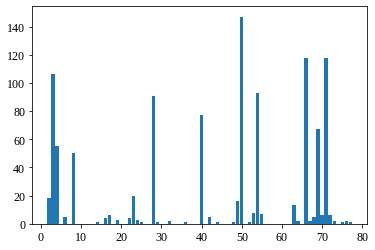

In [37]:
a, b = np.unique(data_dic_array['radar'][matched_cond_alt], return_counts=True)
plt.bar(a,b)

In [38]:
storms_rest['Latitude']

Event ID
24008   -30.3317
24008   -30.3317
24009   -33.6151
24010   -28.8817
24011   -29.7484
          ...   
81708   -14.0500
81709   -12.3621
81710   -14.3774
81711   -13.1775
81714   -12.4626
Name: Latitude, Length: 2019, dtype: float64

(array([ 27.,  19.,  13.,   0.,   0.,   3.,  70.,  39.,  73.,  94., 145.,
        271.,  82., 145.,  93., 104.,  85.,  96., 119., 180.,  65.,  27.,
         43.,  20.,  47.,   3.,  12.,  14.,   7.,  13.,   1.,  18.,   8.,
          1.,   1.,  17.,   5.,   9.,  46.,   4.]),
 array([-43.148    , -42.3463825, -41.544765 , -40.7431475, -39.94153  ,
        -39.1399125, -38.338295 , -37.5366775, -36.73506  , -35.9334425,
        -35.131825 , -34.3302075, -33.52859  , -32.7269725, -31.925355 ,
        -31.1237375, -30.32212  , -29.5205025, -28.718885 , -27.9172675,
        -27.11565  , -26.3140325, -25.512415 , -24.7107975, -23.90918  ,
        -23.1075625, -22.305945 , -21.5043275, -20.70271  , -19.9010925,
        -19.099475 , -18.2978575, -17.49624  , -16.6946225, -15.893005 ,
        -15.0913875, -14.28977  , -13.4881525, -12.686535 , -11.8849175,
        -11.0833   ]),
 <BarContainer object of 40 artists>)

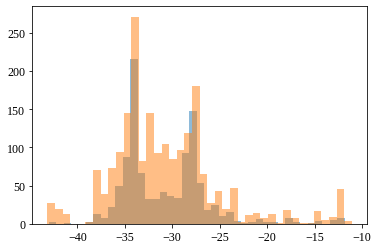

In [39]:
plt.hist(data_dic_array['MCS_lat'][matched_cond_alt], bins=40, alpha=.5)
plt.hist(storms_rest['Latitude'], bins=40, alpha=.5)

In [78]:
all_IDs
all_supp_IDs

unmatched_event_ID = []
unmatched_ID = []
for i in range(len(storms_rest)):
    storm = storms_rest.iloc[i]
#     import pdb; pdb.set_trace()
    cond = (storm.name == np.array(all_IDs).astype(int)) & (storm['ID'] == np.array(all_supp_IDs).astype(int))
    if not np.any(cond):
        unmatched_event_ID.append(storm.name)
        unmatched_ID.append(storm['ID'])

In [94]:
storms_rest.loc[unmatched_event_ID[9]]

Database                       Rain
ID                             4826
Date/Time       2012-11-25 05:20:00
Nearest town             WOLLOMOMBI
State                           NSW
Latitude                   -30.5151
Longitude                  152.0511
Name: 24018, dtype: object

(array([ 152.,   32.,   18.,    4.,   83.,   29.,   78.,  114.,  292.,
        1248.]),
 array([113.5964 , 117.60376, 121.61112, 125.61848, 129.62584, 133.6332 ,
        137.64056, 141.64792, 145.65528, 149.66264, 153.67   ]),
 <BarContainer object of 10 artists>)

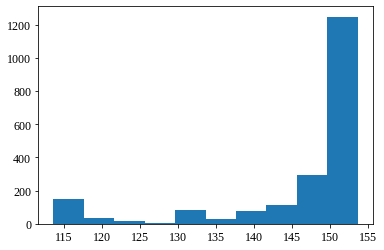

In [121]:
plt.hist(storms['Longitude'])

In [122]:
lons = storms['Longitude']

len(lons[lons>145])/len(lons)

0.771219512195122

(array([ 59., 112., 583., 424., 480., 155.,  76.,  39.,  27.,  64.]),
 array([-43.148  , -39.94153, -36.73506, -33.52859, -30.32212, -27.11565,
        -23.90918, -20.70271, -17.49624, -14.28977, -11.0833 ]),
 <BarContainer object of 10 artists>)

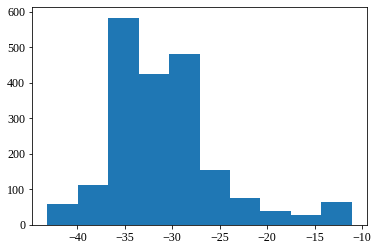

In [96]:
plt.hist(storms_rest['Latitude'])

In [82]:
unmatched_event_ID[0] in np.array(all_IDs).astype(int)

False

In [59]:
unmatched_event_ID

[24010,
 24011,
 24011,
 24012,
 24013,
 24015,
 24016,
 24017,
 24017,
 24018,
 24025,
 24027,
 24028,
 24030,
 24031,
 24031,
 24034,
 24038,
 24045,
 24056,
 24060,
 24061,
 24064,
 24065,
 24069,
 24074,
 24078,
 24081,
 24084,
 24086,
 24086,
 24086,
 24086,
 24088,
 24089,
 24089,
 24090,
 24091,
 24093,
 24096,
 24101,
 24104,
 24111,
 24114,
 24116,
 24117,
 24118,
 24119,
 24120,
 24121,
 24126,
 24128,
 24132,
 24133,
 24134,
 24137,
 24138,
 24142,
 24145,
 24149,
 24152,
 24153,
 24154,
 24156,
 24156,
 24162,
 24164,
 24166,
 24177,
 24183,
 24184,
 24187,
 24194,
 24195,
 24201,
 24203,
 24203,
 24204,
 24209,
 24210,
 24212,
 24214,
 24214,
 24215,
 24216,
 24216,
 24218,
 24226,
 24229,
 24231,
 24232,
 24234,
 24236,
 24237,
 24239,
 24240,
 24249,
 24250,
 24252,
 24254,
 24255,
 24257,
 24259,
 24259,
 24259,
 24259,
 24261,
 24266,
 24266,
 24267,
 24268,
 24269,
 24270,
 24272,
 24273,
 24274,
 24275,
 24275,
 24275,
 24279,
 24280,
 24284,
 24285,
 24286,
 24287,


In [41]:
# What fraction of storm reports were matched?
print('All')
all_IDs, all_supp_IDs, all_types = get_ind_list((matched_cond_alt & cond_raw))

arch_tot = len(storms_rest)
print('Total in archive: {}'.format(arch_tot))
print('Total matched: {}'.format(len(all_IDs)))
print('Fraction matched: {}'.format(len(all_IDs)/len(storms_rest)))

for hazard in ['Hail', 'Rain', 'Wind', 'Tornado']:
    print(hazard)
    print('Total in Archive: {}'.format(len(storms_rest[storms_rest['Database'] == hazard])))
    print('Archive Fraction: {}'.format(len(storms_rest[storms_rest['Database'] == hazard])/len(storms_rest)))  
    print('Sub Fraction: {}'.format(len(all_types[all_types == hazard])/len(all_types)))
    print('Total matched: {}'.format(len(all_types[all_types == hazard])))
    print('Fraction matched:')
    print(len(all_types[all_types == hazard])/len(storms_rest[storms_rest['Database'] == hazard]))

All
Total in archive: 2019
Total matched: 1170
Fraction matched: 0.5794947994056464
Hail
Total in Archive: 415
Archive Fraction: 0.2055473006438831
Sub Fraction: 0.20512820512820512
Total matched: 240
Fraction matched:
0.5783132530120482
Rain
Total in Archive: 767
Archive Fraction: 0.3798910351659237
Sub Fraction: 0.4811965811965812
Total matched: 563
Fraction matched:
0.7340286831812256
Wind
Total in Archive: 753
Archive Fraction: 0.37295690936106984
Sub Fraction: 0.2692307692307692
Total matched: 315
Fraction matched:
0.41832669322709165
Tornado
Total in Archive: 84
Archive Fraction: 0.041604754829123326
Sub Fraction: 0.04188034188034188
Total matched: 49
Fraction matched:
0.5833333333333334


In [197]:
# What fraction of storm reports were matched?
print('All')
all_IDs, all_supp_IDs, all_types = get_ind_list((matched_cond_alt & cond_res))

arch_tot = len(storms_rest)
print('Total in archive: {}'.format(arch_tot))
print('Total matched: {}'.format(len(all_IDs)))
print('Fraction matched: {}'.format(len(all_IDs)/len(storms_rest)))

for hazard in ['Hail', 'Rain', 'Wind', 'Tornado']:
    print(hazard)
    print('Total in Archive: {}'.format(len(storms_rest[storms_rest['Database'] == hazard])))
    print('Archive Fraction: {}'.format(len(storms_rest[storms_rest['Database'] == hazard])/len(storms_rest)))  
    print('Sub Fraction: {}'.format(len(all_types[all_types == hazard])/len(all_types)))
    print('Total matched: {}'.format(len(all_types[all_types == hazard])))
    print('Fraction matched:')
    print(len(all_types[all_types == hazard])/len(storms_rest[storms_rest['Database'] == hazard]))

All
Total in archive: 2019
Total matched: 173
Fraction matched: 0.08568598315998019
Hail
Total in Archive: 415
Archive Fraction: 0.2055473006438831
Sub Fraction: 0.3236994219653179
Total matched: 56
Fraction matched:
0.13493975903614458
Rain
Total in Archive: 767
Archive Fraction: 0.3798910351659237
Sub Fraction: 0.4277456647398844
Total matched: 74
Fraction matched:
0.09647979139504563
Wind
Total in Archive: 753
Archive Fraction: 0.37295690936106984
Sub Fraction: 0.23699421965317918
Total matched: 41
Fraction matched:
0.05444887118193891
Tornado
Total in Archive: 84
Archive Fraction: 0.041604754829123326
Sub Fraction: 0.011560693641618497
Total matched: 2
Fraction matched:
0.023809523809523808


In [198]:
# What fraction of storm reports were matched?
print('All')
all_IDs, all_supp_IDs, all_types = get_ind_list((matched_cond_alt & cond_res & cond_rrs))

arch_tot = len(storms_rest)
print('Total in archive: {}'.format(arch_tot))
print('Total matched: {}'.format(len(all_IDs)))
print('Fraction matched: {}'.format(len(all_IDs)/len(storms_rest)))

for hazard in ['Hail', 'Rain', 'Wind', 'Tornado']:
    print(hazard)
    print('Total in Archive: {}'.format(len(storms_rest[storms_rest['Database'] == hazard])))
    print('Archive Fraction: {}'.format(len(storms_rest[storms_rest['Database'] == hazard])/len(storms_rest)))  
    print('Sub Fraction: {}'.format(len(all_types[all_types == hazard])/len(all_types)))
    print('Total matched: {}'.format(len(all_types[all_types == hazard])))
    print('Fraction matched:')
    print(len(all_types[all_types == hazard])/len(storms_rest[storms_rest['Database'] == hazard]))

All
Total in archive: 2019
Total matched: 70
Fraction matched: 0.03467062902426944
Hail
Total in Archive: 415
Archive Fraction: 0.2055473006438831
Sub Fraction: 0.4714285714285714
Total matched: 33
Fraction matched:
0.07951807228915662
Rain
Total in Archive: 767
Archive Fraction: 0.3798910351659237
Sub Fraction: 0.37142857142857144
Total matched: 26
Fraction matched:
0.03389830508474576
Wind
Total in Archive: 753
Archive Fraction: 0.37295690936106984
Sub Fraction: 0.14285714285714285
Total matched: 10
Fraction matched:
0.013280212483399735
Tornado
Total in Archive: 84
Archive Fraction: 0.041604754829123326
Sub Fraction: 0.014285714285714285
Total matched: 1
Fraction matched:
0.011904761904761904


In [199]:
# What fraction of storm reports were matched?
print('All')
all_IDs, all_supp_IDs, all_types = get_ind_list((matched_cond_alt & cond_res & cond_rls))

arch_tot = len(storms_rest)
print('Total in archive: {}'.format(arch_tot))
print('Total matched: {}'.format(len(all_IDs)))
print('Fraction matched: {}'.format(len(all_IDs)/len(storms_rest)))

for hazard in ['Hail', 'Rain', 'Wind', 'Tornado']:
    print(hazard)
    print('Total in Archive: {}'.format(len(storms_rest[storms_rest['Database'] == hazard])))
    print('Archive Fraction: {}'.format(len(storms_rest[storms_rest['Database'] == hazard])/len(storms_rest)))  
    print('Sub Fraction: {}'.format(len(all_types[all_types == hazard])/len(all_types)))
    print('Total matched: {}'.format(len(all_types[all_types == hazard])))
    print('Fraction matched:')
    print(len(all_types[all_types == hazard])/len(storms_rest[storms_rest['Database'] == hazard]))

All
Total in archive: 2019
Total matched: 47
Fraction matched: 0.023278850916295196
Hail
Total in Archive: 415
Archive Fraction: 0.2055473006438831
Sub Fraction: 0.23404255319148937
Total matched: 11
Fraction matched:
0.02650602409638554
Rain
Total in Archive: 767
Archive Fraction: 0.3798910351659237
Sub Fraction: 0.44680851063829785
Total matched: 21
Fraction matched:
0.027379400260756193
Wind
Total in Archive: 753
Archive Fraction: 0.37295690936106984
Sub Fraction: 0.3191489361702128
Total matched: 15
Fraction matched:
0.0199203187250996
Tornado
Total in Archive: 84
Archive Fraction: 0.041604754829123326
Sub Fraction: 0.0
Total matched: 0
Fraction matched:
0.0


In [201]:
cond_amb = np.logical_not(cond_rles) & np.logical_not(cond_rrs) & np.logical_not(cond_rts) & np.logical_not(cond_rls) 

# What fraction of storm reports were matched?
print('All')
all_IDs, all_supp_IDs, all_types = get_ind_list((matched_cond_alt & cond_res & cond_amb))

arch_tot = len(storms_rest)
print('Total in archive: {}'.format(arch_tot))
print('Total matched: {}'.format(len(all_IDs)))
print('Fraction matched: {}'.format(len(all_IDs)/len(storms_rest)))

for hazard in ['Hail', 'Rain', 'Wind', 'Tornado']:
    print(hazard)
    print('Total in Archive: {}'.format(len(storms_rest[storms_rest['Database'] == hazard])))
    print('Archive Fraction: {}'.format(len(storms_rest[storms_rest['Database'] == hazard])/len(storms_rest)))  
    print('Sub Fraction: {}'.format(len(all_types[all_types == hazard])/len(all_types)))
    print('Total matched: {}'.format(len(all_types[all_types == hazard])))
    print('Fraction matched:')
    print(len(all_types[all_types == hazard])/len(storms_rest[storms_rest['Database'] == hazard]))

All
Total in archive: 2019
Total matched: 46
Fraction matched: 0.022783556215948488
Hail
Total in Archive: 415
Archive Fraction: 0.2055473006438831
Sub Fraction: 0.2608695652173913
Total matched: 12
Fraction matched:
0.02891566265060241
Rain
Total in Archive: 767
Archive Fraction: 0.3798910351659237
Sub Fraction: 0.5
Total matched: 23
Fraction matched:
0.02998696219035202
Wind
Total in Archive: 753
Archive Fraction: 0.37295690936106984
Sub Fraction: 0.21739130434782608
Total matched: 10
Fraction matched:
0.013280212483399735
Tornado
Total in Archive: 84
Archive Fraction: 0.041604754829123326
Sub Fraction: 0.021739130434782608
Total matched: 1
Fraction matched:
0.011904761904761904


In [374]:
# What fraction of storm reports were matched?
cond_amb = np.logical_not(cond_rles) & np.logical_not(cond_rrs) & np.logical_not(cond_rts) & np.logical_not(cond_rls) 

print('All')
all_IDs, all_supp_IDs, all_types = get_ind_list((matched_cond & cond_res & cond_amb))
print('Total in archive: {}'.format(len(storms)))
print('Total matched: {}'.format(len(all_IDs)))
print('Fraction matched: {}'.format(len(all_IDs)/len(storms)))

for hazard in ['Hail', 'Rain', 'Wind', 'Tornado', 'Waterspout', 'Lighting']:

    print(hazard)
    print('Total in Archive: {}'.format(len(storms[storms['Database'] == hazard])))
    print('Total matched: {}'.format(len(all_types[all_types == hazard])))
    print('Fraction matched:')
    print(len(all_types[all_types == hazard])/len(storms[storms['Database'] == hazard]))

All
Total in archive: 2050
Total matched: 46
Fraction matched: 0.0224390243902439
Hail
Total in Archive: 415
Total matched: 12
Fraction matched:
0.02891566265060241
Rain
Total in Archive: 767
Total matched: 23
Fraction matched:
0.02998696219035202
Wind
Total in Archive: 753
Total matched: 10
Fraction matched:
0.013280212483399735
Tornado
Total in Archive: 84
Total matched: 1
Fraction matched:
0.011904761904761904
Waterspout
Total in Archive: 28
Total matched: 0
Fraction matched:
0.0
Lighting
Total in Archive: 3
Total matched: 0
Fraction matched:
0.0


In [375]:
46/2050

0.0224390243902439

In [172]:
set(storms['Database'])

{'Hail', 'Lighting', 'Rain', 'Tornado', 'Waterspout', 'Wind'}

In [42]:
matched_IDs = data_dic_array['report_ID'][matched_cond & cond_raw].astype(int)
matched_IDs
unmatched = []
for i in range(len(storms)):
#     import pdb; pdb.set_trace()
    if storms['ID'].iloc[i] in matched_IDs:
        unmatched.append(False)
    else:
        unmatched.append(True)

In [283]:
len(list(set(data_dic_array['report_ID'][hail_cond])))

118

In [273]:
len(list(set(storms['ID'][storms['Database']=='Hail'])))

425

In [ ]:
list(set(data_dic_array['report_ID'][hail_cond]

In [284]:
len(storms[storms['Database']=='Hail'])

425

In [271]:
len(hail_cond[hail_cond])

1429308

In [253]:
len(set(storms['ID']))

2173

In [ ]:
560/2173

In [ ]:
len(storms['ID'])

In [26]:
set(data_dic_array['report'][cond_raw & cond_report])

{'Hail', 'Lighting', 'Rain', 'Tornado', 'Waterspout', 'Wind'}

(array([ 7071., 18433., 17437.,  9063.,  3456.,  1370.,   539.,   254.,
          109.]),
 array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5]),
 <BarContainer object of 9 artists>)

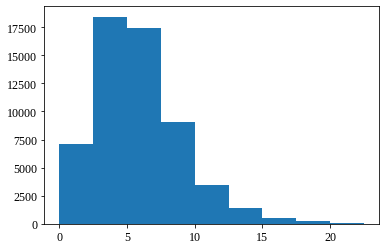

In [27]:
speeds = np.sqrt(data_dic_array['u_relative']**2 + data_dic_array['v_relative']**2)
plt.hist(speeds[cond_res], bins=np.arange(0, 25, 2.5))

In [28]:
pot_energy = data_dic_array['MLCIN100'] + data_dic_array['MLCAPE100']

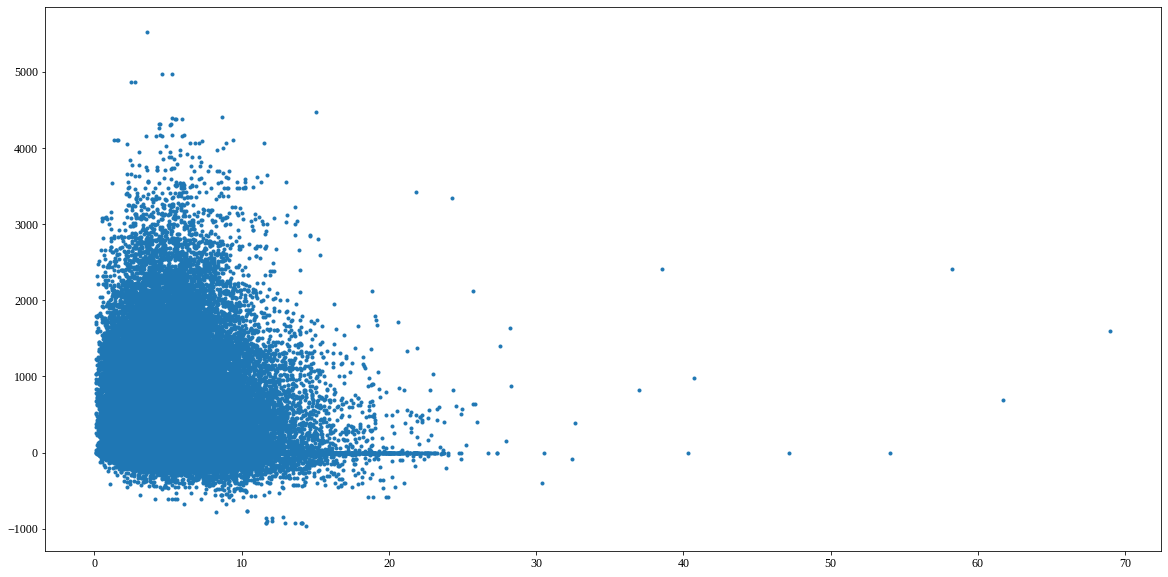

In [29]:
fig, ax = plt.subplots(1,1, figsize=(20, 10))
plt.scatter(speeds[cond_res], pot_energy[cond_res], marker='.')

In [30]:
data_dic_array['radar'][cond_report]

array([ 2,  2,  2, ..., 76, 76, 77])

In [31]:
sorted(data_dic_array['time'][cond_report])

[numpy.datetime64('2012-08-23T06:00:00.000000000'),
 numpy.datetime64('2012-08-23T06:01:00.000000000'),
 numpy.datetime64('2012-08-23T06:24:00.000000000'),
 numpy.datetime64('2012-08-23T07:10:00.000000000'),
 numpy.datetime64('2012-08-23T07:14:00.000000000'),
 numpy.datetime64('2012-08-23T07:20:00.000000000'),
 numpy.datetime64('2012-11-07T05:20:00.000000000'),
 numpy.datetime64('2012-11-08T05:30:00.000000000'),
 numpy.datetime64('2012-11-17T06:41:00.000000000'),
 numpy.datetime64('2012-11-17T07:31:00.000000000'),
 numpy.datetime64('2012-11-17T10:11:00.000000000'),
 numpy.datetime64('2012-11-17T10:12:00.000000000'),
 numpy.datetime64('2012-11-18T03:11:00.000000000'),
 numpy.datetime64('2012-11-18T03:12:00.000000000'),
 numpy.datetime64('2012-11-18T03:36:00.000000000'),
 numpy.datetime64('2012-11-18T03:41:00.000000000'),
 numpy.datetime64('2012-11-18T04:02:00.000000000'),
 numpy.datetime64('2012-11-18T04:21:00.000000000'),
 numpy.datetime64('2012-11-18T04:22:00.000000000'),
 numpy.datet

In [32]:
data_dic_array['report_ID'][cond_report]

array(['6804', '4858', '5163', ..., '5189', '5499', '8284'], dtype='<U10')

In [33]:
matched = []
for i in range(len(storms)):
    if int(storms.iloc[i]['ID']) in data_dic_array['report_ID'][cond_report & cond_raw].astype(int):
        matched.append(True)
    else:
        matched.append(False)

In [34]:
np.any(matched)

True

In [35]:
len(storms[matched])/len(storms)

0.2451641925326136

In [39]:
data_dic_array['time'][cond_report]

array(['2012-04-22T07:12:00.000000000', '2012-12-13T04:48:00.000000000',
       '2013-02-14T06:00:00.000000000', ...,
       '2019-12-27T02:36:00.000000000', '2020-03-08T15:24:00.000000000',
       '2020-03-08T15:36:00.000000000'], dtype='datetime64[ns]')

In [40]:
set(data_dic_array['rel_offset_type'])

{'Ambiguous (Low Relative Velocity)',
 'Ambiguous (On Quadrant Boundary)',
 'Ambiguous (Small Stratiform Offset)',
 'Ambiguous (Small Velocity)',
 'Relative Leading Stratiform',
 'Relative Parallel Stratiform (Left)',
 'Relative Parallel Stratiform (Right)',
 'Relative Trailing Stratiform'}

In [113]:
storms

Database    ID           Date/Time    Nearest town State  Latitude  \
Event ID                                                                      
23953        Rain  4202 2012-01-03 07:11:00        JERANGLE   NSW  -35.8817   
23954        Rain  4203 2012-01-05 06:40:00        MANILDRA   NSW  -33.1817   
23955        Rain  4204 2012-01-05 12:25:00          AVALON   NSW  -33.6317   
23956        Wind  6564 2012-01-08 07:52:00   COONABARABRAN   NSW  -31.2651   
23957        Rain  4205 2012-01-14 04:30:00        BATHURST   NSW  -33.4167   
...           ...   ...                 ...             ...   ...       ...   
81709        Rain  6589 2021-02-17 05:30:00    HOWARD RIVER    NT  -12.3621   
81710        Rain  6590 2021-02-22 11:30:00      MAUD CREEK    NT  -14.3774   
81711        Rain  6591 2021-02-23 06:30:00  ADELAIDE RIVER    NT  -13.1775   
81712        Wind  8292 2021-03-12 05:02:00         TI TREE    NT  -22.1333   
81714        Wind  8293 2021-03-29 06:14:00     DARWIN CITY    NT  -12.4626   

          Longitude  
Event ID             
23953      149.3679  
23954      148.6846  
23955      151.3179  
23956      149.2679  
23957      149.5807  
...             ...  
81709      131.0354  
81710      132.4031  
81711      131.1697  
81712      133.2667  
81714      130.8429  

[3059 rows x 7 columns]

In [385]:
cat, counts = np.unique(storms['Database'], return_counts=True)

In [387]:
print(cat)
counts


['Hail' 'Lighting' 'Rain' 'Tornado' 'Waterspout' 'Wind']


array([425,   4, 887,  92,  28, 787])

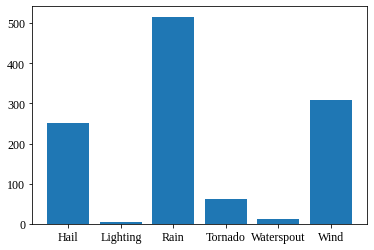

In [200]:
unique, counts = np.unique(data_dic_array['report'][np.logical_and(cond_report, cond_raw)], return_counts=True)
plt.bar(unique, counts)
plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/phd/AURA_analysis/reports_raw.png', 
    dpi=200, facecolor='w', edgecolor='white',
    bbox_inches='tight')

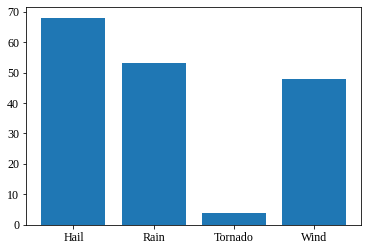

In [201]:
unique, counts = np.unique(data_dic_array['report'][np.logical_and(cond_report, cond_res)], return_counts=True)
plt.bar(unique, counts)
plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/phd/AURA_analysis/reports_res.png', 
    dpi=200, facecolor='w', edgecolor='white',
    bbox_inches='tight')

In [142]:
delUsqrd = np.array(data_dic_array['u_trop_shear'])**2 + np.array(data_dic_array['v_trop_shear'])**2
R = np.array(data_dic_array['CAPE'])/(.5*delUsqrd)
av_rh = np.array(data_dic_array['av_rh'])
av_rh_bfl = np.array(data_dic_array['av_rh_bfl'])
CAPE = np.array(data_dic_array['CAPE'])
MLCAPE100 = np.array(data_dic_array['MLCAPE100'])
u06 = np.array(data_dic_array['u06'])
v06 = np.array(data_dic_array['v06'])
S06 = np.sqrt(u06**2+v06**2)
u_shear = np.array(data_dic_array['u_shear'])
v_shear = np.array(data_dic_array['v_shear'])
shear_mag = np.sqrt(u_shear**2+v_shear**2)
cond_CAPE = (MLCAPE100 > 0)
# Couple of erroneous delUsqrds which through off means - clearly an issue with the ERA5 data 
AKE_cond = (.5*delUsqrd < 5000)

In [143]:
def get_smallest_angle_with_orientation(u, v, orientation):
    uv_angle = np.arctan2(v, u)
    uv_angle = np.rad2deg(uv_angle)

    uv_angle = np.mod(uv_angle, 360)
    orientation = np.mod(orientation, 360)

    cosines_1 = np.cos(np.deg2rad(uv_angle-orientation))
    angles_1 = np.arccos(cosines_1) * 180 / np.pi

    cosines_2 = np.cos(np.deg2rad(uv_angle-(orientation+180)))
    angles_2 = np.arccos(cosines_2) * 180 / np.pi
    
    angles = np.minimum(angles_1, angles_2)
    return angles

In [144]:
def get_angles(u1, v1, u2, v2):
    u1v1_angle = np.arctan2(v1, u1)
    u1v1_angle = np.rad2deg(u1v1_angle)

    u1v1_angle = np.mod(u1v1_angle, 360)
    
    u2v2_angle = np.arctan2(v2, u2)
    u2v2_angle = np.rad2deg(u2v2_angle)

    u2v2_angle = np.mod(u2v2_angle, 360)
#     orientation = np.mod(orientation, 360)

    cosines = np.cos(np.deg2rad(u1v1_angle-u2v2_angle))
    angles = np.arccos(cosines) * 180 / np.pi

    return angles

In [246]:
shear_vel = get_angles(data_dic_array['u_shear'], data_dic_array['v_shear'], data_dic_array['u_shift'], data_dic_array['v_shift'])

In [253]:
training_angles = get_smallest_angle_with_orientation(
    data_dic_array['u_shift'], 
    data_dic_array['v_shift'], 
    data_dic_array['orientation'])

(array([0.00862763, 0.00751079, 0.00770623, 0.00873932, 0.00868347,
        0.01150351, 0.01317878, 0.01404433, 0.01440731, 0.01672476]),
 array([ 0.        ,  8.99878315, 17.99756629, 26.99634944, 35.99513258,
        44.99391573, 53.99269887, 62.99148202, 71.99026517, 80.98904831,
        89.98783146]),
 <BarContainer object of 10 artists>)

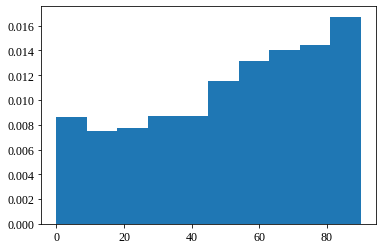

In [320]:
plt.hist(training_angles[cond_res & AKE_cond & cond_rts & cond_ust], density=True)

(array([0.01080569, 0.01063172, 0.01041908, 0.00997448, 0.01057373,
        0.01057373, 0.01206217, 0.01179154, 0.01225547, 0.01202351]),
 array([ 0.,  9., 18., 27., 36., 45., 54., 63., 72., 81., 90.]),
 <BarContainer object of 10 artists>)

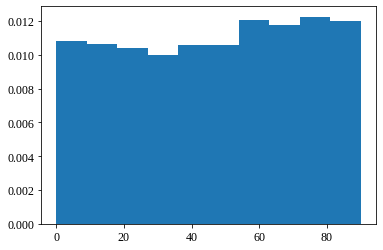

In [321]:
plt.hist(training_angles[cond_res & AKE_cond & cond_rls & cond_dst], density=True)

(array([0.0078574 , 0.00846342, 0.00945953, 0.01081089, 0.011194  ,
        0.01173733, 0.01306083, 0.01279613, 0.01254536, 0.01318622]),
 array([ 0.,  9., 18., 27., 36., 45., 54., 63., 72., 81., 90.]),
 <BarContainer object of 10 artists>)

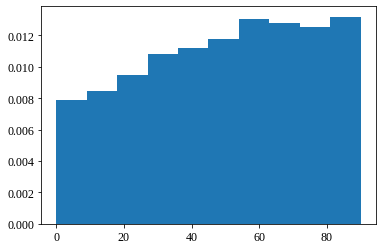

In [376]:
plt.hist(training_angles[cond_res & AKE_cond & cond_rrs], density=True)

In [374]:
test = training_angles[cond_res & AKE_cond & (data_dic_array['radar']==22)]
print(len(test[test<45])/len(test))
print(len(test[test>=45])/len(test))

0.46300448430493274
0.5369955156950673


(array([0.00872619, 0.00928166, 0.01001631, 0.01023132, 0.00953251,
        0.01123475, 0.01134226, 0.01232776, 0.01401208, 0.01440628]),
 array([ 0.,  9., 18., 27., 36., 45., 54., 63., 72., 81., 90.]),
 <BarContainer object of 10 artists>)

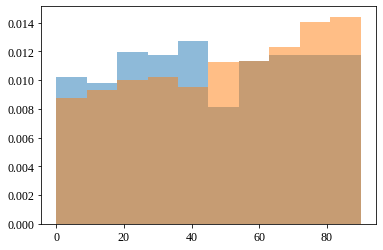

In [335]:
plt.hist(training_angles[cond_res & AKE_cond & (data_dic_array['radar']==64)], density=True, alpha=.5)
plt.hist(training_angles[cond_res & AKE_cond & (data_dic_array['radar']==63)], density=True, alpha=.5)

In [ ]:
plt.hist(training_angles[cond_res & AKE_cond & cond_darwin])

In [264]:
cond_darwin = (
    (data_dic_array['radar'] == 42) | (data_dic_array['radar'] == 77)
    | (data_dic_array['radar'] == 63) | (data_dic_array['radar'] == 9))

In [266]:
cond_melb = (
    (data_dic_array['radar'] == 14) | (data_dic_array['radar'] == 2)
    | (data_dic_array['radar'] == 68) | (data_dic_array['radar'] == 49))

In [268]:
cond_syd = (
    (data_dic_array['radar'] == 3) | (data_dic_array['radar'] == 54)
    | (data_dic_array['radar'] == 4) | (data_dic_array['radar'] == 69))

(array([1028.,  967., 1026., 1025., 1033.,  974., 1113., 1125., 1192.,
        1095.]),
 array([ 0.,  9., 18., 27., 36., 45., 54., 63., 72., 81., 90.]),
 <BarContainer object of 10 artists>)

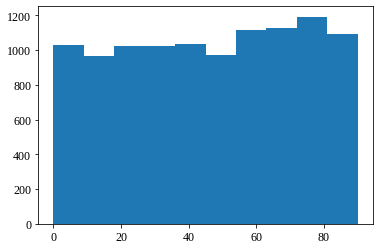

In [262]:

plt.hist(training_angles[cond_res & AKE_cond & ])

(array([21321., 15121.,  9079.,  4888.,  2597.,  1535.,  1107.,   771.,
          561.,   554.]),
 array([9.19542359e-06, 1.79984447e+01, 3.59968803e+01, 5.39953158e+01,
        7.19937513e+01, 8.99921868e+01, 1.07990622e+02, 1.25989058e+02,
        1.43987493e+02, 1.61985929e+02, 1.79984365e+02]),
 <BarContainer object of 10 artists>)

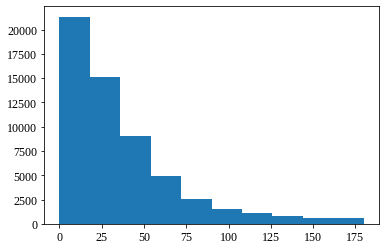

In [252]:
plt.hist(shear_vel[cond_res & AKE_cond])

In [235]:
angles = get_smallest_angle_with_orientation(
    data_dic_array['u_shear'], data_dic_array['v_shear'],
    data_dic_array['orientation'])

In [236]:
deep_angles = get_smallest_angle_with_orientation(
    data_dic_array['u_trop_shear'], data_dic_array['v_trop_shear'],
    data_dic_array['orientation'])

In [95]:
from scipy import stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import ticker

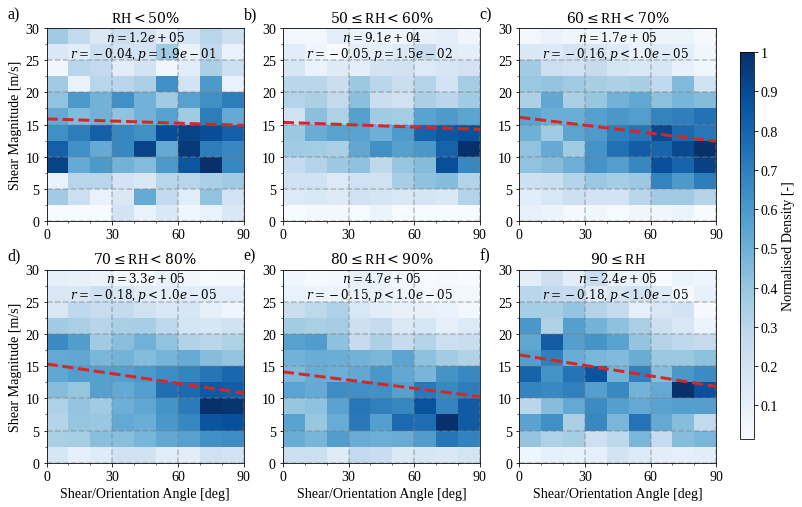

In [29]:
cl.init_fonts(fontsize=14)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

shear_bins = np.arange(0, 32.5, 2.5)
angles_bins = np.arange(0, 100, 10)

conds = [
    cond_rh_1, cond_rh_2, cond_rh_3, 
    cond_rh_4, cond_rh_5, cond_rh_6]
titles = [
    r'RH$<50\%$', r'$50\leq$RH$<60\%$', r'$60\leq$RH$<70\%$',
    r'$70\leq$RH$<80\%$', r'$80\leq$RH$<90\%$', r'$90\leq$RH']

maxes = []

for i in range(len(conds)):
    cond = conds[i]
    title = titles[i]
    ax = axes.flatten()[i]
    
    n = len(cond[cond])
    
    y = S06[cond_res & cond & cond_linear]
    x = angles[cond_res & cond & cond_linear]

    x_reg = np.array([0, 90])
    a, b = np.polyfit(x, y, 1)

    coeff = stats.pearsonr(y, x)

    hist = ax.hist2d(
        x, y, density=True, cmap='Blues', bins=[angles_bins, shear_bins])
    ax.plot(x_reg, a*x_reg+b, linewidth=3, linestyle='--', color='tab:red')

    maxes.append(hist[0].max())
    
    fs = 12
    ax.text(27, 28, r'$n={:.1e}$'.format(n), fontsize=fs)
    if coeff[1] < 1e-5:
        lab = r'$r=' + r'{:.2f}'.format(coeff[0]) + r'$, $p<' + r'{:.1e}'.format(1e-5) + r'$'
    else:
        lab = r'$r=' + r'{:.2f}'.format(coeff[0]) + r'$, $p=' + r'{:.1e}'.format(coeff[1]) + r'$'
    txt = ax.text(10.5, 25.5, lab, fontsize=fs)
    ax.set_title(title, fontsize=14)
    ax.grid(linestyle='--', linewidth=1.5, color='grey', alpha=.5)
#     ax.grid(linestyle='--', linewidth=1.5, color='grey', alpha=.3, which=True)
#     txt.set_bbox(dict(facecolor='w', alpha=0.5, edgecolor='no'))

[axes[1,i].set_xlabel(r'Shear/Orientation Angle [deg]') for i in range(3)]
[axes.flatten()[i].set_xticks(np.arange(0, 90+30, 30)) for i in range(6)]
[axes.flatten()[i].set_xticks(np.arange(0, 90+10, 10), minor=True) for i in range(6)]
[axes.flatten()[i].set_yticks(np.arange(0, 35, 5)) for i in range(6)]
[axes.flatten()[i].set_yticks(np.arange(0, 32.5, 2.5), minor=True) for i in range(6)]
[axes[i,0].set_ylabel(r'Shear Magnitude [m/s]') for i in range(2)]

axins = inset_axes(
    axes[1,2], width='7%', height='200%', loc='lower left',
    bbox_to_anchor=(1.12, 0.125, 1, 1), bbox_transform=axes[1,2].transAxes,
    borderpad=0)

# fig.colorbar(im, cax=axins, ticks=[1, 2, 3])

sfmt = ticker.ScalarFormatter() 
sfmt.set_powerlimits((0, 0))

cbar = plt.colorbar(hist[3], cax=axins, orientation='vertical', format=sfmt)
cbar.set_label('Normalised Density [-]')
cbar.set_ticks(np.arange(0, maxes[-1]+maxes[-1]/10, maxes[-1]/10))
cbar.ax.set_yticklabels([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

# cbar.ax.set_yticklabels(["{:.1e}".format(i) for i in cbar.get_ticks()]) # set ticks of your format

plt.subplots_adjust(hspace=.25)

cl.make_subplot_labels(axes.flatten(), x_shift=-.2, y_shift=.05)

plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/phd/AUS_MCS_paper/emanual_plots.png', 
    dpi=200, facecolor='w', edgecolor='white',
    bbox_inches='tight')

In [30]:
mid_lat_cond = (
    (data_dic_array['radar'] != 42) & (data_dic_array['radar'] != 77)
    & (data_dic_array['radar'] != 63) & (data_dic_array['radar'] != 9)
    & (data_dic_array['radar'] != 36) & (data_dic_array['radar'] != 19)
    & (data_dic_array['radar'] != 41) & (data_dic_array['radar'] != 17)
    & (data_dic_array['radar'] != 16))

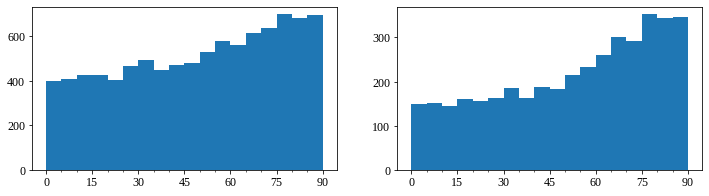

In [233]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
ax = axes[0]
ax.hist(angles[cond_res & cond_rts], bins=np.arange(0, 95, 5))
ax.set_xticks(np.arange(0, 95, 15))
ax.set_xticks(np.arange(0, 95, 5), minor=True)

ax = axes[1]
ax.hist(angles[cond_res & cond_rts & cond_ust], bins=np.arange(0, 95, 5))
ax.set_xticks(np.arange(0, 95, 15))
ax.set_xticks(np.arange(0, 95, 5), minor=True)

# ax = axes[1, 0]
# ax.hist(angles[cond_res & cond_rls], bins=np.arange(0, 95, 5))
# ax.set_xticks(np.arange(0, 95, 15))
# ax.set_xticks(np.arange(0, 95, 5), minor=True)

# ax = axes[1, 1]
# ax.hist(angles[cond_res & cond_rls & cond_ust], bins=np.arange(0, 95, 5))
# ax.set_xticks(np.arange(0, 95, 15))
# ax.set_xticks(np.arange(0, 95, 5), minor=True)

In [237]:
training_angles = get_smallest_angle_with_orientation(
    data_dic_array['u_shift'], 
    data_dic_array['v_shift'], 
    data_dic_array['orientation'])

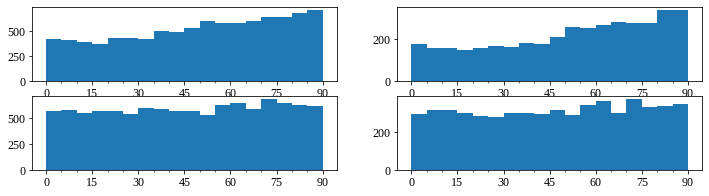

In [238]:
fig, axes = plt.subplots(2, 2, figsize=(12, 3))
ax = axes[0, 0]
ax.hist(training_angles[cond_res & cond_rts], bins=np.arange(0, 95, 5))
ax.set_xticks(np.arange(0, 95, 15))
ax.set_xticks(np.arange(0, 95, 5), minor=True)

ax = axes[0, 1]
ax.hist(training_angles[cond_res & cond_rts & cond_ust], bins=np.arange(0, 95, 5))
ax.set_xticks(np.arange(0, 95, 15))
ax.set_xticks(np.arange(0, 95, 5), minor=True)

ax = axes[1, 0]
ax.hist(training_angles[cond_res & cond_rls], bins=np.arange(0, 95, 5))
ax.set_xticks(np.arange(0, 95, 15))
ax.set_xticks(np.arange(0, 95, 5), minor=True)

ax = axes[1, 1]
ax.hist(training_angles[cond_res & cond_rls & cond_dst], bins=np.arange(0, 95, 5))
ax.set_xticks(np.arange(0, 95, 15))
ax.set_xticks(np.arange(0, 95, 5), minor=True)

In [44]:
cond_ee = (data_dic_array['av_ee_bfl'] != -9999)
data_dic_array['av_ee_bfl'][cond_ee]

array([0.03802092, 0.04378412, 0.03853187, ..., 0.14452369, 0.16011691,
       0.14929262])

In [45]:
data_dic_array['av_ee_bfl'][data_dic_array['av_ee_bfl']!= -9999].mean()

0.5716705559776154

In [46]:
plt.hist(data_dic_array['av_rh'][cond_res & cond_rts & cond_ee & cond_darwin], bins=50, alpha=.5, label='RTS', density=True)
plt.hist(data_dic_array['av_rh'][cond_res & cond_rls & cond_ee & cond_darwin], bins=50, alpha=.5, label='RLS', density=True)
plt.legend()

NameError: name 'cond_darwin' is not defined

In [138]:
data_dic_array['av_rh_bfl'][cond_res & cond_rts & cond_ust & cond_ee].mean()

72.29570373404536

In [140]:
data_dic_array['av_rh_bfl'][cond_res & cond_rls & cond_dst & cond_ee].mean()

73.61313432768195

In [91]:
raw_severe = (np.log10(MLCAPE100[cond_raw & cond_CAPE]) >= np.log10(25000) - 1.67*np.log10(S06[cond_raw & cond_CAPE]))
raw_sig_severe = (np.log10(MLCAPE100[cond_raw & cond_CAPE]) >= np.log10(68000) - 1.67*np.log10(S06[cond_raw & cond_CAPE]))

res_severe = (np.log10(MLCAPE100[cond_res & cond_CAPE]) >= np.log10(25000) - 1.67*np.log10(S06[cond_res & cond_CAPE]))
res_sig_severe = (np.log10(MLCAPE100[cond_res & cond_CAPE]) >= np.log10(68000) - 1.67*np.log10(S06[cond_res & cond_CAPE]))

rts_not_severe = (np.log10(MLCAPE100[cond_res & cond_rts & cond_CAPE]) < np.log10(25000) - 1.67*np.log10(S06[cond_res & cond_rts & cond_CAPE]))
rts_severe = (np.log10(MLCAPE100[cond_res & cond_rts & cond_CAPE]) >= np.log10(25000) - 1.67*np.log10(S06[cond_res & cond_rts & cond_CAPE]))
rts_sig_severe = (np.log10(MLCAPE100[cond_res & cond_rts & cond_CAPE]) >= np.log10(68000) - 1.67*np.log10(S06[cond_res & cond_rts & cond_CAPE]))
rts_high_CAPE = (np.log10(MLCAPE100[cond_res & cond_rts & cond_CAPE])  >= (2*np.log10(S06[cond_res & cond_rts & cond_CAPE])+1))

def get_conds(sample_cond):
#     not_severe = (np.log10(MLCAPE100[sample_cond]) < np.log10(25000) - 1.67*np.log10(S06[sample_cond]))
    severe = (np.log10(MLCAPE100[sample_cond]) >= np.log10(25000) - 1.67*np.log10(S06[sample_cond]))
    sig_severe = (np.log10(MLCAPE100[sample_cond]) >= np.log10(68000) - 1.67*np.log10(S06[sample_cond]))
    high_CAPE = (np.log10(MLCAPE100[sample_cond])  >= (2*np.log10(S06[sample_cond])+1))
    all_conds = [severe, sig_severe, high_CAPE]
    return all_conds

# rts_ust_severe = (np.log10(MLCAPE100[cond_res & cond_rts & cond_ust & cond_CAPE]) >= np.log10(25000) - 1.67*np.log10(S06[cond_res & cond_rts & cond_ust & cond_CAPE]))
# rts_ust_sig_severe = (np.log10(MLCAPE100[cond_res & cond_rts & cond_ust & cond_CAPE]) >= np.log10(68000) - 1.67*np.log10(S06[cond_res & cond_rts & cond_ust & cond_CAPE]))
# rts_ust_high_CAPE = (np.log10(MLCAPE100[cond_res & cond_rts & cond_ust & cond_CAPE])  >= (2*np.log10(S06[cond_res & cond_rts & cond_ust & cond_CAPE])+1))

101
100
101
99


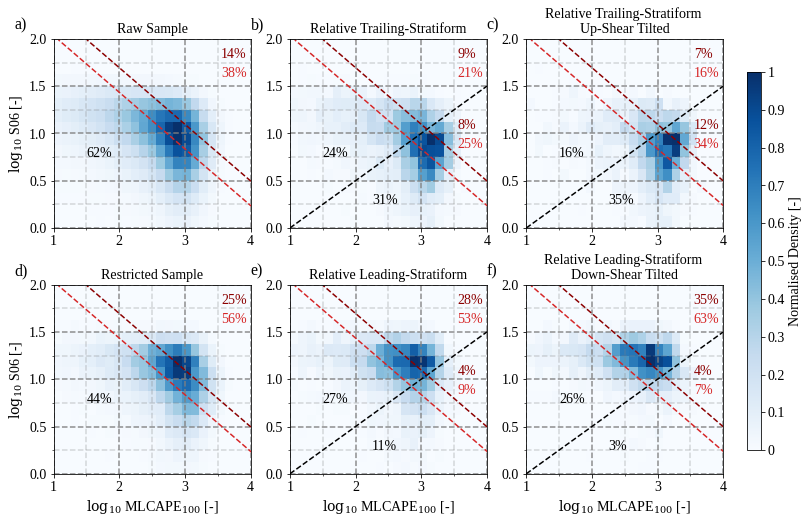

In [99]:
cl.init_fonts(fontsize=14)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

y = np.arange(0, 2, 0.01)
xR = 2*y+1

xS = np.log10(25000)-1.67*y
xSS = np.log10(68000)-1.67*y

x_space = np.linspace(1, 4, 24)
y_space = np.linspace(0, 2, 17)

ax = axes[0, 0]

maxes = []

vmin = 0
vmax = 2.6

pct_xpos1 = 3.55

pct_raw_s = int(np.round(len(raw_severe[raw_severe])/len(raw_severe)*100))
pct_raw_ss = int(np.round(len(raw_sig_severe[raw_sig_severe])/len(raw_sig_severe)*100))

pct_res_s = int(np.round(len(res_severe[res_severe])/len(res_severe)*100))
pct_res_ss = int(np.round(len(res_sig_severe[res_sig_severe])/len(res_sig_severe)*100))

# import pdb; pdb.set_trace()

# pct_rts_s_high_CAPE = int(np.round(len(res_severe[res_severe])/len(res_severe)*100))
# pct_rts_ss_high_CAPE = int(np.round(len(res_sig_severe[res_sig_severe])/len(res_sig_severe)*100))

fs = 14

hist_cmap = 'Blues'
s_col = 'tab:red'
ss_col = 'darkred'

con = ax.hist2d(
    np.log10(MLCAPE100[cond_raw & cond_CAPE]), np.log10(S06[cond_raw & cond_CAPE]), bins=[x_space, y_space], 
    cmap=hist_cmap, density=True)
# ax.set_xlabel(r'$\log_{10}$ MLCAPE$_{100}$ [-]')
ax.set_ylabel(r'$\log_{10}$ S06 [-]')
ax.plot(xS, y, '--', color=s_col)
ax.plot(xSS, y, '--', color=ss_col)
ax.set_title('Raw Sample', fontsize=14)
ax.text(1.5, .75, '{:d}%'.format(100-pct_raw_s), color='k', fontsize=fs)
ax.text(pct_xpos1, 1.6, '{:d}%'.format(pct_raw_s), color=s_col, fontsize=fs)
ax.text(pct_xpos1, 1.8, '{:d}%'.format(pct_raw_ss), color=ss_col, fontsize=fs)
# fig.colorbar(con0[3], ax=ax.flatten()[0], label='Density [-]')
maxes.append(con[0].max())

ax = axes[1, 0]

con = ax.hist2d(
    np.log10(MLCAPE100[cond_res & cond_CAPE]), np.log10(S06[cond_res & cond_CAPE]), bins=[x_space, y_space], 
    cmap=hist_cmap, density=True)
ax.set_xlabel(r'$\log_{10}$ MLCAPE$_{100}$ [-]')
ax.set_ylabel(r'$\log_{10}$ S06 [-]')
ax.plot(xS, y, '--', color=s_col)
ax.plot(xSS, y, '--', color=ss_col)
ax.set_title('Restricted Sample', fontsize=14)
ax.text(1.5, .75, '{:d}%'.format(100-pct_res_s), color='k', fontsize=fs)
ax.text(pct_xpos1, 1.6, '{:d}%'.format(pct_res_s), color=s_col, fontsize=fs)
ax.text(pct_xpos1, 1.8, '{:d}%'.format(pct_res_ss), color=ss_col, fontsize=fs)
# fig.colorbar(con1[3], ax=ax.flatten()[1], label='Density [-]')
maxes.append(np.max(con[0]))

ax = axes[0, 1]

def get_percents(severe, sig_severe, high_CAPE):
    
    pct_not_s_high_CAPE = int(
        np.round(len(severe[np.logical_not(severe) & high_CAPE])/len(severe)*100))
    pct_not_s_low_CAPE = int(
        np.round(len(severe[np.logical_not(severe) & np.logical_not(high_CAPE)])/len(severe)*100))

    pct_s_high_CAPE = int(
        np.round(len(severe[severe & high_CAPE])/len(severe)*100))
    pct_s_low_CAPE = int(
        np.round(len(severe[severe & np.logical_not(high_CAPE)])/len(severe)*100))

    pct_ss_high_CAPE = int(
        np.round(len(sig_severe[sig_severe & high_CAPE])/len(sig_severe)*100))
    pct_ss_low_CAPE = int(
        np.round(len(sig_severe[sig_severe & np.logical_not(high_CAPE)])/len(sig_severe)*100))
    
    all_pcts = [
        pct_not_s_high_CAPE, pct_not_s_low_CAPE, pct_s_high_CAPE, 
        pct_s_low_CAPE, pct_ss_high_CAPE, pct_ss_low_CAPE]
    
    return all_pcts

all_pcts = get_percents(rts_severe, rts_sig_severe, rts_high_CAPE)

con = ax.hist2d(
    np.log10(MLCAPE100[cond_res & cond_rts & cond_CAPE]), 
    np.log10(S06[cond_res & cond_rts & cond_CAPE]),
    bins=[x_space, y_space], cmap=hist_cmap, density=True)
ax.plot(xR, y, '--k')
ax.plot(xS, y, '--', color=s_col)
ax.plot(xSS, y, '--', color=ss_col)
# ax.set_xlabel(r'$\log_{10}$ MLCAPE$_{100}$ [-]')
# ax.set_ylabel(r'$\log_{10}$ S06 [-]')

def plot_percents(ax, all_pcts, pct_xpos1):
    ax.text(2.25, .25, '{:d}%'.format(all_pcts[0]), color='k', fontsize=fs)
    ax.text(1.5, .75, '{:d}%'.format(all_pcts[1]), color='k', fontsize=fs)
    ax.text(pct_xpos1, .85, '{:d}%'.format(all_pcts[2]), color=s_col, fontsize=fs)
    ax.text(pct_xpos1, 1.6, '{:d}%'.format(all_pcts[3]), color=s_col, fontsize=fs)
    ax.text(pct_xpos1, 1.05, '{:d}%'.format(all_pcts[4]), color=ss_col, fontsize=fs)
    ax.text(pct_xpos1, 1.8, '{:d}%'.format(all_pcts[5]), color=ss_col, fontsize=fs)

plot_percents(ax, all_pcts, pct_xpos1)
print(sum(all_pcts[:4]))

ax.set_title('Relative Trailing-Stratiform', fontsize=14)
# fig.colorbar(con2[3], ax=ax.flatten()[2], label='Density [-]')
maxes.append(con[0].max())

ax = axes[1, 1]

# import pdb; pdb.set_trace()

con = ax.hist2d(
    np.log10(MLCAPE100[cond_res & cond_rls & cond_CAPE]), 
    np.log10(S06[cond_res & cond_rls & cond_CAPE]),
    bins=[x_space, y_space], cmap=hist_cmap, density=True)
ax.plot(xR, y, '--k')
ax.plot(xS, y, '--', color=s_col)
ax.plot(xSS, y, '--', color=ss_col)
ax.set_xlabel(r'$\log_{10}$ MLCAPE$_{100}$ [-]')
# ax.set_ylabel(r'$\log_{10}$ S06 [-]')
ax.set_title('Relative Leading-Stratiform', fontsize=14)
# cbar = fig.colorbar(con3[3], ax=ax.flatten()[3], label='Density [-]')
maxes.append(con[0].max())

all_conds = get_conds(cond_res & cond_rls & cond_CAPE)
all_pcts = get_percents(all_conds[0], all_conds[1], all_conds[2])
plot_percents(ax, all_pcts, pct_xpos1)
print(sum(all_pcts[:4]))

ax = axes[0, 2]
con = ax.hist2d(
    np.log10(MLCAPE100[cond_res & cond_rts & cond_ust & cond_CAPE]), 
    np.log10(S06[cond_res & cond_rts & cond_ust & cond_CAPE]), bins=[x_space, y_space], 
    cmap=hist_cmap, density=True)
ax.plot(xR, y, '--k')
ax.plot(xS, y, '--', color=s_col)
ax.plot(xSS, y, '--', color=ss_col)
# ax.set_xlabel(r'$\log_{10}$ MLCAPE$_{100}$ [-]')
# ax.set_ylabel(r'$\log_{10}$ S06 [-]')
ax.set_title('Relative Trailing-Stratiform \nUp-Shear Tilted', fontsize=14)
# fig.colorbar(con4[3], ax=ax.flatten()[4], label='Density [-]')
maxes.append(con[0].max())

all_conds = get_conds(cond_res & cond_rts & cond_ust & cond_CAPE)
all_pcts = get_percents(all_conds[0], all_conds[1], all_conds[2])
plot_percents(ax, all_pcts, pct_xpos1)
print(sum(all_pcts[:4]))

ax = axes[1, 2]

con = ax.hist2d(
    np.log10(MLCAPE100[cond_res & cond_rls & cond_dst & cond_CAPE]), 
    np.log10(S06[cond_res & cond_rls & cond_dst & cond_CAPE]), 
    bins=[x_space, y_space], cmap=hist_cmap, density=True)
ax.plot(xR, y, '--k')
ax.plot(xS, y, '--', color=s_col)
ax.plot(xSS, y, '--', color=ss_col)
ax.set_xlabel(r'$\log_{10}$ MLCAPE$_{100}$ [-]')
# ax.set_ylabel(r'$\log_{10}$ S06 [-]')
ax.set_title('Relative Leading-Stratiform \nDown-Shear Tilted', fontsize=14)
# cbar = fig.colorbar(con5[3], ax=ax.flatten()[5], label='Density [-]')
# plt.xscale('log')
# plt.yscale('log')
plt.subplots_adjust(hspace=.3)
maxes.append(con[0].max())

all_conds = get_conds(cond_res & cond_rls & cond_dst & cond_CAPE)
all_pcts = get_percents(all_conds[0], all_conds[1], all_conds[2])
plot_percents(ax, all_pcts, pct_xpos1)
print(sum(all_pcts[:4]))

[axes.flatten()[i].set_xticks(np.arange(1, 5, 1)) for i in range(6)]
[axes.flatten()[i].set_yticks(np.arange(0, 2.5, .5)) for i in range(6)]
[axes.flatten()[i].set_xticks(np.arange(1, 4.5, .5), minor=True) for i in range(6)]
[axes.flatten()[i].set_yticks(np.arange(0, 2.25, .25), minor=True) for i in range(6)]
[axes.flatten()[i].grid(linestyle='--', linewidth=1.5, color='grey', alpha=.9) for i in range(6)]
[axes.flatten()[i].grid(linestyle='--', linewidth=1.5, color='grey', alpha=.3, which='minor') for i in range(6)]

axins = inset_axes(
    axes[1,2], width='7%', height='200%', loc='lower left',
    bbox_to_anchor=(1.12, 0.125, 1, 1), bbox_transform=axes[1,2].transAxes,
    borderpad=0)

sfmt = ticker.ScalarFormatter()
sfmt.set_powerlimits((0, 0))

cbar = plt.colorbar(con[3], cax=axins, orientation='vertical', format=sfmt)
cbar.set_label('Normalised Density [-]')
cbar.set_ticks(np.arange(0, maxes[-1]+maxes[-1]/10, maxes[-1]/10))

cbar.ax.set_yticklabels([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])
# cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

cl.make_subplot_labels(axes.flatten(), x_shift=-.2, y_shift=.05)

plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/phd/AUS_MCS_paper/allen_plots.png', 
    dpi=200, facecolor='w', edgecolor='white',
    bbox_inches='tight')

In [32]:
AKE = .5*delUsqrd

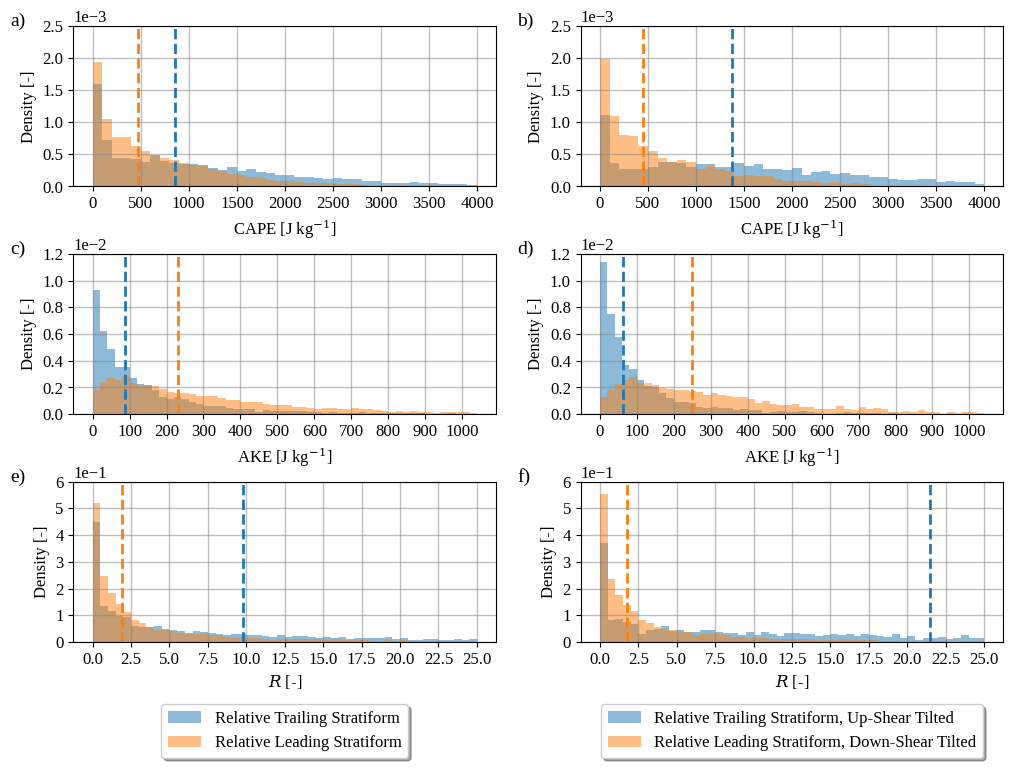

In [524]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
cl.init_fonts()

variables = [
    CAPE, AKE, R]
bins_list = [
    np.arange(0,4.1*1e3,100), np.arange(0,1.05*1e3,20), np.arange(0, 25.5, .5)]
xticks_list = [
    np.arange(0,4.5*1e3,500), np.arange(0,1.05*1e3,100), np.arange(0, 25.5, 2.5)]
titles = [
    'Convective Available Potential Energy (CAPE)', 
    'Available Kinetic Energy (AKE)', r'Bulk Richardson Number ($R$)']
xlabels = [r'CAPE [J kg$^{-1}$]', r'AKE [J kg$^{-1}$]', r'$R$ [-]']
max_dens_list = [2.5e-3, 12e-3, 6e-1]
dens_step = [5e-4, 2e-3, 1e-1]

for i in range(len(variables)):
    
    ax = axes[i,0]
    v = variables[i]
    bins = bins_list[i]
    title = titles[i]
    
    alpha=.5

    hista = ax.hist(
        v[cond_res & cond_rts & AKE_cond], bins=bins, alpha=alpha, density=True, 
        label = 'Relative Trailing Stratiform')
    histb = ax.hist(
        v[cond_res & cond_rls & AKE_cond], bins=bins, alpha=alpha, density=True, 
        label = 'Relative Leading Stratiform')
#     ax.set_title(title, fontsize=12)

    med_blue = np.median(v[cond_res & cond_rts & AKE_cond])
    med_red = np.median(v[cond_res & cond_rls & AKE_cond])

#     max_dens = np.max([np.max(hista[0]), np.max(histb[0])])
    ax.plot([med_blue, med_blue], [0, max_dens_list[i]], '--', color='Tab:blue', linewidth=2)
    ax.plot([med_red, med_red], [0, max_dens_list[i]], '--', color='Tab:orange', linewidth=2)
    ax.set_xlabel(xlabels[i])
    ax.set_ylabel('Density [-]')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
#     import pdb; pdb.set_trace()
    ax.set_yticks(np.arange(0, max_dens_list[i]+dens_step[i], dens_step[i]))
    ax.grid(
        which='major', alpha=.5, axis='both', color='grey', linewidth=1, zorder=2)    
    ax.set_ylim([0, max_dens_list[i]])
    ax.set_xticks(xticks_list[i])
    
    ax = axes[i,1]

    hista = ax.hist(
        v[cond_res & cond_rts & cond_ust & AKE_cond], 
        bins=bins, alpha=alpha, density=True, 
        label='Relative Trailing Stratiform, Up-Shear Tilted')
    histb = ax.hist(
        v[cond_res & cond_rls & cond_dst & AKE_cond], 
        bins=bins, alpha=alpha, density=True, 
        label='Relative Leading Stratiform, Down-Shear Tilted')
#     ax.set_title(title, fontsize=12)
    
    med_blue = np.median(v[cond_res & cond_rts & cond_ust & AKE_cond])
    med_red = np.median(v[cond_res & cond_rls & cond_dst & AKE_cond])

#     max_dens = np.max([np.max(hista[0]), np.max(histb[0])])
    ax.plot([med_blue, med_blue], [0, max_dens_list[i]], '--', color='Tab:blue', linewidth=2)
    ax.plot([med_red, med_red], [0, max_dens_list[i]], '--', color='Tab:orange', linewidth=2)
    ax.set_xlabel(xlabels[i])
    ax.set_ylabel('Density [-]')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    ax.set_yticks(np.arange(0, max_dens_list[i]+dens_step[i], dens_step[i]))
    ax.grid(
        which='major', alpha=.5, axis='both', color='grey', linewidth=1, zorder=2)    
    ax.set_ylim([0, max_dens_list[i]])
    ax.set_xticks(xticks_list[i])

axes[-1, 0].legend(
    loc='lower center',
    bbox_to_anchor=(.5, -0.775),
    ncol=1, fancybox=True, shadow=True)
axes[-1, 1].legend(
    loc='lower center',
    bbox_to_anchor=(.5, -0.775),
    ncol=1, fancybox=True, shadow=True)

plt.subplots_adjust(hspace=.42)
cl.make_subplot_labels(axes.flatten(), size=14)

plt.savefig('/home/student.unimelb.edu.au/shorte1/Documents/phd/AUS_MCS_paper/R_breakdown.png', 
    dpi=200, facecolor='w', edgecolor='white',
    bbox_inches='tight')

In [260]:
np.median(R[cond_res & cond_rrs & AKE_cond])

2.8170636431536376

In [88]:
np.unique(data_dic_array['report_ID'])

array(['', '24008_3929, ', '24008_3929, 24008_6835, ', '24008_6835, ',
       '24009_6836, ', '24017_6841, ', '24019_4827, ', '24020_6843, ',
       '24021_6844, ', '24023_3933, ',
       '24023_6845, 24023_3932, 24023_4828, ', '24026_4830, ',
       '24026_4836, ', '24027_6848, ', '24027_6849, ', '24027_6851, ',
       '24027_6852, ', '24028_4832, ', '24028_4833, ', '24028_4834, ',
       '24028_4835, ', '24028_6854, ', '24029_4838, ', '24030_3934, ',
       '24031_6857, ', '24032_6858, ', '24034_4839, ', '24039_4843, ',
       '24041_4845, ', '24041_4846, ', '24042_4847, ', '24042_6860, ',
       '24043_3936, ', '24044_6862, ', '24050_4850, ', '24053_4852, ',
       '24054_4853, ', '24055_4854, ', '24057_6864, ', '24058_1226, ',
       '24058_1227, ', '24058_1228, ', '24067_3947, ', '24067_3955, ',
       '24069_3948, 24069_4902, ', '24069_4903, ', '24070_4894, ',
       '24071_4895, ', '24071_4895, 24072_3949, ', '24072_3949, ',
       '24075_3951, ', '24075_3966, ', '24075_3967, ',

In [84]:
np.median(R[cond_res & AKE_cond & (data_dic_array['radar'] == 63) & (data_dic_array['pope_regime'] == 2)])

1.7893326775412866

In [74]:
cond_lR = (R < 5)
cond_gR = (R > 5)

In [75]:
len(R[cond_res & cond_rts & cond_ust & AKE_cond & cond_gR])/len(R[cond_res & cond_rts & cond_ust & AKE_cond])

0.7587939698492462

In [76]:
len(R[cond_res & cond_rls & cond_dst & AKE_cond & cond_lR])/len(R[cond_res & cond_rls & cond_dst & AKE_cond])

0.7211203897007655

In [382]:
print(np.median(R[cond_res & cond_rts]))
print(np.median(R[cond_res & cond_rls]))

9.707159359067296
1.8915208279783569


In [383]:
print(np.median(R[cond_res & cond_rts & cond_ust]))
print(np.median(R[cond_res & cond_rls & cond_dst]))

21.444685752315543
1.7858029264958164


In [369]:
R_bins = np.logspace(np.log10(0.1), np.log10(50), 20)
R_bins

array([ 0.1       ,  0.13869189,  0.19235439,  0.26677993,  0.37000212,
        0.51316292,  0.71171532,  0.9870914 ,  1.36901568,  1.89871366,
        2.63336178,  3.65225911,  5.06538703,  7.02528079,  9.7434944 ,
       13.51343612, 18.74203937, 25.99368781, 36.05113577, 50.        ])

In [102]:
plt.hist(MLCAPE100[cond_res & cond_rts], bins=np.arange(0,5*1e3,100), alpha=.5, density=True, label = 'Trailing')
plt.hist(MLCAPE100[cond_res & cond_rls], bins=np.arange(0,5*1e3,100), alpha=.5, density=True, label = 'Leading')
plt.title('MLCAPE100')
plt.legend()
plt.savefig('/home/student.unimelb.edu.au/shorte1/Documents/phd/AURA_analysis/MUCAPE.png', 
    dpi=200, facecolor='w', edgecolor='white',
    bbox_inches='tight')

NameError: name 'MLCAPE100' is not defined

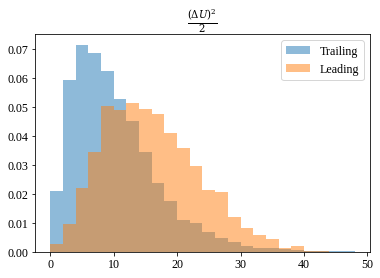

In [66]:
plt.hist(np.sqrt(.5*delUsqrd)[cond_res & cond_rts], bins=np.arange(0,50,2), alpha=.5, density=True, label = 'Trailing')
plt.hist(np.sqrt(.5*delUsqrd)[cond_res & cond_rls], bins=np.arange(0,50,2), alpha=.5, density=True, label = 'Leading')
# plt.hist(np.sqrt(delUsqrd)[rps_cond], bins=np.arange(0,50,2), alpha=.5, density=True, label = 'Parallel')
plt.title(r'$\frac{(\Delta U)^2}{2}$')
plt.legend()
plt.savefig('/home/student.unimelb.edu.au/shorte1/Documents/phd/AURA_analysis/AKE.png', 
    dpi=200, facecolor='w', edgecolor='white',
    bbox_inches='tight')

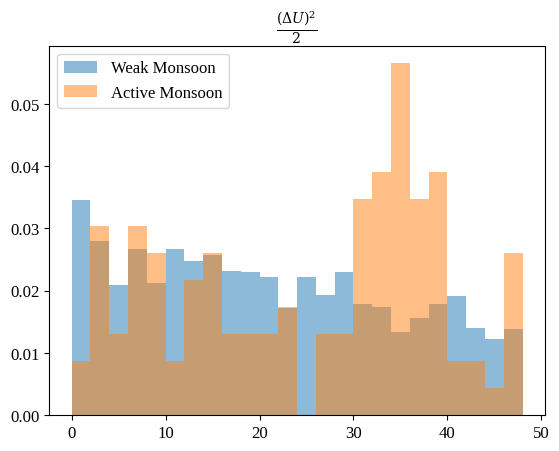

In [450]:
plt.hist(.5*delUsqrd[cond_res & cond_darwin & (cond_active_monsoon==False)], bins=np.arange(0,50,2), alpha=.5, density=True, label = 'Weak Monsoon')
plt.hist(.5*delUsqrd[cond_res & cond_darwin & cond_active_monsoon], bins=np.arange(0,50,2), alpha=.5, density=True, label = 'Active Monsoon')
# plt.hist(np.sqrt(delUsqrd)[rps_cond], bins=np.arange(0,50,2), alpha=.5, density=True, label = 'Parallel')
plt.title(r'$\frac{(\Delta U)^2}{2}$')
plt.legend()
plt.savefig('/home/student.unimelb.edu.au/shorte1/Documents/phd/AURA_analysis/AKE.png', 
    dpi=200, facecolor='w', edgecolor='white',
    bbox_inches='tight')

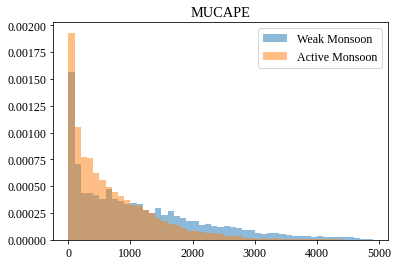

In [194]:
plt.hist(CAPE[cond_res & cond_rts], bins=np.arange(0,5*1e3,100), alpha=.5, density=True, label='Trailing')
plt.hist(CAPE[cond_res & cond_rls], bins=np.arange(0,5*1e3,100), alpha=.5, density=True, label='Leading')
plt.title('MUCAPE')
plt.legend()
plt.savefig('/home/student.unimelb.edu.au/shorte1/Documents/phd/AURA_analysis/MUCAPE.png', 
    dpi=200, facecolor='w', edgecolor='white',
    bbox_inches='tight')

In [159]:
np.any(delUsqrd == 0)

False

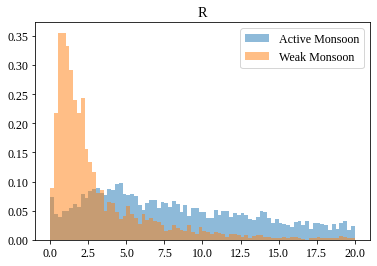

In [196]:
db = .25
plt.hist(
    R[cond_res & cond_darwin & (cond_active_monsoon==False)], 
    bins=np.arange(0,20+db,db), alpha=.5, density=True, label = 'Active Monsoon')
plt.hist(
    R[cond_res & cond_darwin & cond_active_monsoon], 
    bins=np.arange(0,20+db,db), alpha=.5, density=True, label = 'Weak Monsoon')
plt.title('R')
plt.legend()
plt.savefig('/home/student.unimelb.edu.au/shorte1/Documents/phd/AURA_analysis/R.png', 
    dpi=200, facecolor='w', edgecolor='white',
    bbox_inches='tight')

In [197]:
R[cond_res & cond_darwin & (cond_active_monsoon==False)].mean()

213.72901869573326

In [198]:
R[cond_res & cond_darwin & cond_active_monsoon].mean()

4.603062204219139

In [63]:
R[cond_res & cond_rts].mean()

115.33457028622001

In [64]:
R[cond_res & cond_rls].mean()

19.763595269468777

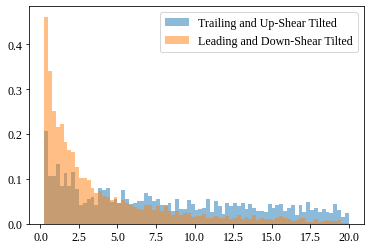

In [218]:
db = .25
plt.hist(R[cond_res & cond_rts & cond_ust], bins=np.arange(db,20+db,db), alpha=.5, density=True, label = 'Trailing and Up-Shear Tilted')
plt.hist(R[cond_res & cond_rls & cond_dst], bins=np.arange(db,20+db,db), alpha=.5, density=True, label = 'Leading and Down-Shear Tilted')
# plt.hist(R[rps_cond], bins=np.arange(db,10+db,db), alpha=.25, density=True, label = 'Parallel')
# plt.gca().set_xscale("log")
plt.legend()
plt.savefig('/home/student.unimelb.edu.au/shorte1/Documents/phd/AURA_analysis/R_more.png', 
    dpi=200, facecolor='w', edgecolor='white',
    bbox_inches='tight')

In [59]:
R[cond_res & cond_rts & cond_ust].mean()

181.65864070249611

In [60]:
R[cond_res & cond_rls & cond_dst].mean()

15.382018086722466

In [ ]:
d

In [243]:
print(np.median(R[rls_cond]))
print(np.median(R[rts_cond]))
print(np.median(R[rps_cond]))

print(np.median(R[dst_cond]))
print(np.median(R[ust_cond]))

print(np.median(R[np.logical_and(dst_cond, rls_cond)]))
print(np.median(R[np.logical_and(ust_cond, rts_cond)]))

1.9199341894510518
11.234040838591564
2.857990174774171
2.208745732343901
14.640997479634098
1.9264213600860398
24.225392338667


In [10]:
cl.create_oper_radar_counts(
    save_dir, tracks_dir, class_thresh=None, excl_thresh=None,
    exclusions=None, non_linear_conds=False, morning_only=False)

Getting classes for radar 2, year 2012.
Processing year 2012, month 1, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 2, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 3, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 4, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 5, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 6, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 7, radar, 2
No tracks. Skipping
Processing year 2012, month 8, radar, 2
No

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 3, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 4, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 5, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 6, radar, 2
No tracks. Skipping
Processing year 2017, month 7, radar, 2
No tracks. Skipping
Processing year 2017, month 8, radar, 2
No tracks. Skipping
Processing year 2017, month 9, radar, 2
No tracks file. Skipping
Processing year 2017, month 10, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 11, radar, 2
Getting new exclu

Adding Pope monsoon regime.
Processing year 2021, month 12, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 2, year 2022.
Processing year 2022, month 1, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 2, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 3, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 4, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 5, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 6, radar, 2
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Pr

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 11, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 12, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 3, year 2016.
Processing year 2016, month 1, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 2, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 3, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 4, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 5, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
N

No tracks satisfying conditions. Skipping year.
Processing year 2020, month 9, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 10, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 11, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 12, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 3, year 2021.
Processing year 2021, month 1, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 2, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 3, radar, 3
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 4, radar, 3
Getting new exclusions.
Calculating 

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 9, radar, 4
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 10, radar, 4
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2014, month 11, radar, 4
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2014, month 12, radar, 4
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 4, year 2015.
Processing year 2015, month 1, radar, 4
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 2, radar, 4
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 3, radar, 4
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.


Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 9, radar, 4
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 10, radar, 4
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 11, radar, 4
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 12, radar, 4
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 4, year 2020.
Processing year 2020, month 1, radar, 4
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 2, radar, 4
Getting new exclusions.
Calculating system tracks.


Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 5, year 2014.
Processing year 2014, month 1, radar, 5
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 2, radar, 5
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 3, radar, 5
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2014, month 4, radar, 5
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 5, radar, 5
No tracks. Skipping
Processing year 2014, month 6, radar, 5
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 7, radar,

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 5, year 2019.
Processing year 2019, month 1, radar, 5
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 2, radar, 5
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 3, radar, 5
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 4, radar, 5
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 5, radar, 5
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 6, radar, 5
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, mont

Adding Pope monsoon regime.
Processing year 2012, month 6, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 7, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 8, radar, 6
No tracks. Skipping
Processing year 2012, month 9, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 10, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 11, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 12, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Get

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 6, year 2017.
Processing year 2017, month 1, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 2, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 3, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 4, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 5, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 6, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, mont

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 12, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 6, year 2022.
Processing year 2022, month 1, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 2, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 3, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 4, radar, 6
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 5, radar, 6
Getting new exclusions.
Calculating system tracks.
Addin

Adding Pope monsoon regime.
Processing year 2015, month 12, radar, 8
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 8, year 2016.
Processing year 2016, month 1, radar, 8
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 2, radar, 8
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 3, radar, 8
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 4, radar, 8
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 5, radar, 8
No tracks. Skipping
Processing year 2016, month 6, radar, 8
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks sat

Adding Pope monsoon regime.
Processing year 2021, month 4, radar, 8
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 5, radar, 8
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 6, radar, 8
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 7, radar, 8
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 8, radar, 8
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 9, radar, 8
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 20

Processing year 2015, month 2, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 3, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 4, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 5, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 6, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 7, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 8, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, m

Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 11, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 12, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 9, year 2021.
Processing year 2021, month 1, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 2, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 3, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 4, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 5, radar, 9
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime

No tracks satisfying conditions. Skipping year.
Processing year 2014, month 9, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 10, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 11, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 12, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 14, year 2015.
Processing year 2015, month 1, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 2, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 3, radar, 14
Get

Adding Pope monsoon regime.
Processing year 2019, month 5, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 6, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 7, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 8, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 9, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 10, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 11, radar, 14
Getting new exclusions.
Calculating system tracks.
Adding Pope mo

Adding Pope monsoon regime.
Getting classes for radar 16, year 2013.
Processing year 2013, month 1, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 2, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 3, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 4, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 5, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 6, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 7, radar, 16
No tracks. Skipping
Processing year 2013, month 8, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pop

Adding Pope monsoon regime.
Processing year 2017, month 12, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 16, year 2018.
Processing year 2018, month 1, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 2, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 3, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 4, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 5, radar, 16
No tracks. Skipping
Processing year 2018, month 6, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 7, radar, 16
No tracks. S

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 12, radar, 16
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 17, year 2012.
Processing year 2012, month 1, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 2, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 3, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 4, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 5, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 20

No tracks satisfying conditions. Skipping year.
Processing year 2016, month 7, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 8, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 9, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 10, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 11, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 12, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 17, year 20

Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 17, year 2022.
Processing year 2022, month 1, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 2, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 3, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 4, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 5, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 6, radar, 17
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 

No tracks satisfying conditions. Skipping year.
Processing year 2016, month 12, radar, 19
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 19, year 2017.
Processing year 2017, month 1, radar, 19
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 2, radar, 19
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 3, radar, 19
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 4, radar, 19
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 5, radar, 19
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 6, radar, 19
Getti

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 8, radar, 19
No tracks. Skipping
Processing year 2022, month 9, radar, 19
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 10, radar, 19
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 11, radar, 19
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 12, radar, 19
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 22, year 2012.
Processing year 2012, month 1, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 2, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Pro

Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 10, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 11, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 12, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 22, year 2017.
Processing year 2017, month 1, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 2, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 3, radar,

Adding Pope monsoon regime.
Processing year 2021, month 12, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 22, year 2022.
Processing year 2022, month 1, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 2, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 3, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 4, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 5, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 6, radar, 22
No tracks. Skipping
Processing year 2022, month 7, radar, 22
Getting new exclusions.
Calculating system tracks.
Adding Po

Processing year 2015, month 11, radar, 23
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 12, radar, 23
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 23, year 2016.
Processing year 2016, month 1, radar, 23
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 2, radar, 23
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 3, radar, 23
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 4, radar, 23
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 5, radar, 23
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying 

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 9, radar, 23
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 10, radar, 23
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 11, radar, 23
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 12, radar, 23
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 23, year 2021.
Processing year 2021, month 1, radar, 23
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 2, radar, 23
Getting new exclusions.
Calculating system trac

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 12, radar, 24
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 24, year 2015.
Processing year 2015, month 1, radar, 24
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 2, radar, 24
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 3, radar, 24
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 4, radar, 24
No tracks. Skipping
Processing year 2015, month 5, radar, 24
No tracks. Skipping
Processing year 2015, month 6, radar, 24
No tracks. Skipping
Processing year 2015, month 7, radar, 24
No tracks. Skipping
Processing year 2015, month 8, radar, 24
No tracks. Skipping
Processing year 2015, month 9, radar, 24
No track

No tracks. Skipping
Processing year 2020, month 7, radar, 24
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 8, radar, 24
No tracks. Skipping
Processing year 2020, month 9, radar, 24
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 10, radar, 24
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 11, radar, 24
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 12, radar, 24
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 24, year 2021.
Processing year 2021, month 1, radar, 24
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 2, radar, 24
Getting new exclus

Getting classes for radar 25, year 2015.
Processing year 2015, month 1, radar, 25
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 2, radar, 25
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 3, radar, 25
No tracks. Skipping
Processing year 2015, month 4, radar, 25
No tracks. Skipping
Processing year 2015, month 5, radar, 25
No tracks. Skipping
Processing year 2015, month 6, radar, 25
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 7, radar, 25
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 8, radar, 25
No tracks. Skipping
Processing year 2015, month 9, radar, 25
No tracks. Skipping
Processing year 2015, month 10, radar, 25
No tracks. Skipping
Processing year 

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 3, radar, 25
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 4, radar, 25
No tracks. Skipping
Processing year 2021, month 5, radar, 25
No tracks. Skipping
Processing year 2021, month 6, radar, 25
No tracks. Skipping
Processing year 2021, month 7, radar, 25
No tracks. Skipping
Processing year 2021, month 8, radar, 25
No tracks. Skipping
Processing year 2021, month 9, radar, 25
No tracks. Skipping
Processing year 2021, month 10, radar, 25
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 11, radar, 25
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 12, radar, 25
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 2

Processing year 2015, month 5, radar, 27
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 6, radar, 27
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 7, radar, 27
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 8, radar, 27
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 9, radar, 27
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 10, radar, 27
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 11, radar, 27
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing yea

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 27, year 2020.
Processing year 2020, month 1, radar, 27
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 2, radar, 27
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 3, radar, 27
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 4, radar, 27
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 5, radar, 27
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 6, radar, 27
Ge

Adding Pope monsoon regime.
Processing year 2013, month 10, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 11, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 12, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 28, year 2014.
Processing year 2014, month 1, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 2, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 3, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2014, month 4, radar, 28
Getting new exclusions.

Processing year 2018, month 11, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 12, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 28, year 2019.
Processing year 2019, month 1, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 2, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 3, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 4, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 5, radar, 28
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019,

Adding Pope monsoon regime.
Getting classes for radar 29, year 2013.
Processing year 2013, month 1, radar, 29
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 2, radar, 29
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 3, radar, 29
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 4, radar, 29
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 5, radar, 29
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 6, radar, 29
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 7, radar, 29
No tracks. Skipping
Processing year 2013, month 8, radar, 29
No tracks. Sk

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 11, radar, 29
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 12, radar, 29
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 29, year 2018.
Processing year 2018, month 1, radar, 29
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 2, radar, 29
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 3, radar, 29
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 4, radar, 29
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 3, radar, 31
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 4, radar, 31
No tracks. Skipping
Processing year 2012, month 5, radar, 31
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 6, radar, 31
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 7, radar, 31
No tracks. Skipping
Processing year 2012, month 8, radar, 31
No tracks. Skipping
Processing year 2012, month 9, radar, 31
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 10, radar, 31
No tracks. Skipping
Processing year 2012, month 11, radar, 31
No tracks. Sk

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 12, radar, 31
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 31, year 2019.
Processing year 2019, month 1, radar, 31
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 2, radar, 31
No tracks. Skipping
Processing year 2019, month 3, radar, 31
No tracks file. Skipping
Processing year 2019, month 4, radar, 31
No tracks file. Skipping
Processing year 2019, month 5, radar, 31
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 6, radar, 31
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 7, radar, 31
Getting new exclusions.


Adding Pope monsoon regime.
Getting classes for radar 32, year 2013.
Processing year 2013, month 1, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 2, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 3, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 4, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 5, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 6, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 7, radar, 32
Getting new exclusions.
Ca

Adding Pope monsoon regime.
Processing year 2017, month 10, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 11, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 12, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 32, year 2018.
Processing year 2018, month 1, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 2, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 3, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 

Processing year 2022, month 7, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 8, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 9, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 10, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 11, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 12, radar, 32
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 33, year 2012.
Processing year 2012, month 1, radar, 33
Get

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 2, radar, 33
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 3, radar, 33
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 4, radar, 33
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 5, radar, 33
No tracks. Skipping
Processing year 2017, month 6, radar, 33
No tracks. Skipping
Processing year 2017, month 7, radar, 33
No tracks. Skipping
Processing year 2017, month 8, radar, 33
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 9, radar, 33
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regim

Adding Pope monsoon regime.
Processing year 2022, month 10, radar, 33
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 11, radar, 33
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 12, radar, 33
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 36, year 2012.
Processing year 2012, month 1, radar, 36
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 2, radar, 36
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 3, radar, 36
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 4, radar, 36
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 5, radar, 36

Processing year 2017, month 11, radar, 36
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 12, radar, 36
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 36, year 2018.
Processing year 2018, month 1, radar, 36
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 2, radar, 36
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 3, radar, 36
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 4, radar, 36
No tracks. Skipping
Processing year 2018, month 5, radar, 36
No tracks. Skipping
Processing year 2018, month 6, radar, 36
No tracks. Skipping
Processing year 2018, month 7, radar, 36
No tracks. Skipping
Processing year 2

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 3, radar, 37
No tracks. Skipping
Processing year 2014, month 4, radar, 37
No tracks. Skipping
Processing year 2014, month 5, radar, 37
No tracks. Skipping
Processing year 2014, month 6, radar, 37
No tracks. Skipping
Processing year 2014, month 7, radar, 37
No tracks. Skipping
Processing year 2014, month 8, radar, 37
No tracks. Skipping
Processing year 2014, month 9, radar, 37
No tracks. Skipping
Processing year 2014, month 10, radar, 37
No tracks. Skipping
Processing year 2014, month 11, radar, 37
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 12, radar, 37
No tracks. Skipping
Getting classes for radar 37, year 2015.
Processing year 2015, month 1, radar, 37
No tracks. Skipping
Processing year 2015, month 2, radar, 37
No tracks. Skipping
Processing year 2015, month 3, radar, 37


Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 11, radar, 37
No tracks. Skipping
Processing year 2022, month 12, radar, 37
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 40, year 2012.
Processing year 2012, month 1, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 2, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 3, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 4, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 5, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
N

No tracks satisfying conditions. Skipping year.
Processing year 2016, month 6, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 7, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 8, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 9, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 10, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 11, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoo

Adding Pope monsoon regime.
Getting classes for radar 40, year 2021.
Processing year 2021, month 1, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 2, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 3, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 4, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 5, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 6, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 7, radar, 40
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon reg

Adding Pope monsoon regime.
Getting classes for radar 41, year 2016.
Processing year 2016, month 1, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 2, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 3, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 4, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 5, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 6, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfyin

No tracks. Skipping
Processing year 2021, month 9, radar, 41
No tracks. Skipping
Processing year 2021, month 10, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 11, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 12, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 41, year 2022.
Processing year 2022, month 1, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 2, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 3, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 4, radar, 41
Getting new exclusions.
Calculating system tracks.
Adding Pope mon

Adding Pope monsoon regime.
Processing year 2016, month 3, radar, 42
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 4, radar, 42
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 5, radar, 42
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 6, radar, 42
No tracks. Skipping
Processing year 2016, month 7, radar, 42
No tracks. Skipping
Processing year 2016, month 8, radar, 42
No tracks. Skipping
Processing year 2016, month 9, radar, 42
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 10, radar, 42
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 11, radar, 42
Getting new exclusions.
Calculating system tracks.

Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 11, radar, 42
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 12, radar, 42
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 44, year 2012.
Processing year 2012, month 1, radar, 44
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 2, radar, 44
No tracks. Skipping
Processing year 2012, month 3, radar, 44
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 4, radar, 44
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 5, radar, 44
No tracks. Skipping
Processing y

No tracks satisfying conditions. Skipping year.
Getting classes for radar 44, year 2018.
Processing year 2018, month 1, radar, 44
No tracks. Skipping
Processing year 2018, month 2, radar, 44
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 3, radar, 44
No tracks. Skipping
Processing year 2018, month 4, radar, 44
No tracks. Skipping
Processing year 2018, month 5, radar, 44
No tracks. Skipping
Processing year 2018, month 6, radar, 44
No tracks. Skipping
Processing year 2018, month 7, radar, 44
No tracks file. Skipping
Processing year 2018, month 8, radar, 44
No tracks. Skipping
Processing year 2018, month 9, radar, 44
No tracks. Skipping
Processing year 2018, month 10, radar, 44
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 11, radar, 44
Getting new exclusions.
Calculating sys

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 4, radar, 46
No tracks. Skipping
Processing year 2013, month 5, radar, 46
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 6, radar, 46
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 7, radar, 46
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 8, radar, 46
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 9, radar, 46
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, m

No tracks satisfying conditions. Skipping year.
Processing year 2018, month 7, radar, 46
No tracks. Skipping
Processing year 2018, month 8, radar, 46
No tracks. Skipping
Processing year 2018, month 9, radar, 46
No tracks. Skipping
Processing year 2018, month 10, radar, 46
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 11, radar, 46
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 12, radar, 46
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 46, year 2019.
Processing year 2019, month 1, radar, 46
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 2, radar, 46
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditio

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 2, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 3, radar, 48
No tracks. Skipping
Processing year 2012, month 4, radar, 48
No tracks. Skipping
Processing year 2012, month 5, radar, 48
No tracks. Skipping
Processing year 2012, month 6, radar, 48
No tracks. Skipping
Processing year 2012, month 7, radar, 48
No tracks. Skipping
Processing year 2012, month 8, radar, 48
No tracks. Skipping
Processing year 2012, month 9, radar, 48
No tracks. Skipping
Processing year 2012, month 10, radar, 48
No tracks. Skipping
Processing year 2012, month 11, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 12, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying cond

Adding Pope monsoon regime.
Processing year 2017, month 11, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 12, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 48, year 2018.
Processing year 2018, month 1, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 2, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 3, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 4, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 5, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 6, radar, 48


No tracks satisfying conditions. Skipping year.
Processing year 2022, month 8, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 9, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 10, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 11, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 12, radar, 48
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 49, year 2012.
Processing year 2012, month 1, radar, 49
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regi

Adding Pope monsoon regime.
Processing year 2017, month 4, radar, 49
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 5, radar, 49
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 6, radar, 49
No tracks. Skipping
Processing year 2017, month 7, radar, 49
No tracks. Skipping
Processing year 2017, month 8, radar, 49
No tracks. Skipping
Processing year 2017, month 9, radar, 49
No tracks. Skipping
Processing year 2017, month 10, radar, 49
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 11, radar, 49
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 12, radar, 49
Getting new exclusions.
Calculating system tracks.
Adding Po

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 4, radar, 49
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 5, radar, 49
No tracks. Skipping
Processing year 2022, month 6, radar, 49
No tracks. Skipping
Processing year 2022, month 7, radar, 49
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 8, radar, 49
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 9, radar, 49
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 10, radar, 49
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks

Adding Pope monsoon regime.
Processing year 2015, month 11, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 12, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 50, year 2016.
Processing year 2016, month 1, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 2, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 3, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 4, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 5, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 10, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 11, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 12, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 50, year 2021.
Processing year 2021, month 1, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 2, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 3, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 4, radar, 50
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon 

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 2, radar, 52
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 3, radar, 52
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 4, radar, 52
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 5, radar, 52
No tracks. Skipping
Processing year 2017, month 6, radar, 52
No tracks. Skipping
Processing year 2017, month 7, radar, 52
No tracks. Skipping
Processing year 2017, month 8, radar, 52
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 9, radar, 52
No tracks. Skipping
Processi

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 52, year 2022.
Processing year 2022, month 1, radar, 52
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 2, radar, 52
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 3, radar, 52
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 4, radar, 52
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 5, radar, 52
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 6, radar, 52
Getting new exclusions.
Calculating system tracks.

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 4, radar, 53
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 5, radar, 53
No tracks. Skipping
Processing year 2016, month 6, radar, 53
No tracks. Skipping
Processing year 2016, month 7, radar, 53
No tracks. Skipping
Processing year 2016, month 8, radar, 53
No tracks. Skipping
Processing year 2016, month 9, radar, 53
No tracks. Skipping
Processing year 2016, month 10, radar, 53
No tracks. Skipping
Processing year 2016, month 11, radar, 53
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 12, radar, 53
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 53, year 2017.
Processing year 2017, month 1, radar, 53
Getting new exclu

Adding Pope monsoon regime.
Processing year 2022, month 2, radar, 53
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 3, radar, 53
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 4, radar, 53
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 5, radar, 53
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 6, radar, 53
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 7, radar, 53
No tracks. Skipping
Processing year 2022, month 8, radar, 53
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 9, radar, 53
Getting new exclusions.
Calculating system tracks.
Add

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 9, radar, 54
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 10, radar, 54
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 11, radar, 54
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 12, radar, 54
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 54, year 2017.
Processing year 2017, month 1, radar, 54
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 2, radar, 54
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 3, radar, 54
Getting new exclusions.

Adding Pope monsoon regime.
Processing year 2022, month 2, radar, 54
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 3, radar, 54
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 4, radar, 54
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 5, radar, 54
No tracks. Skipping
Processing year 2022, month 6, radar, 54
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 7, radar, 54
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 8, radar, 54
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 2, radar, 55
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 3, radar, 55
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 4, radar, 55
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 5, radar, 55
No tracks. Skipping
Processing year 2017, month 6, radar, 55
No tracks. Skipping
Processing year 2017, month 7, radar, 55
No tracks. Skipping
Processing year 2017, month 8, radar, 55
No tracks. Skipping
Processing year 2017, month 9, radar, 55
No tracks. Skipping
Processing year 2017, month 10, radar, 55
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping 

Adding Pope monsoon regime.
Processing year 2012, month 2, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 3, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 4, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 5, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 6, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 7, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks sa

Processing year 2017, month 2, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 3, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 4, radar, 56
No tracks. Skipping
Processing year 2017, month 5, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 6, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 7, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 8, radar, 56
No tracks. Skipping
Processing year 2017, month 9, radar, 56
No tracks. Skipping
Processing year 2017, mon

No tracks satisfying conditions. Skipping year.
Processing year 2022, month 5, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 6, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 7, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 8, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 9, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 10, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 11, radar, 56
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing yea

Processing year 2017, month 4, radar, 63
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 5, radar, 63
No tracks. Skipping
Processing year 2017, month 6, radar, 63
No tracks. Skipping
Processing year 2017, month 7, radar, 63
No tracks. Skipping
Processing year 2017, month 8, radar, 63
No tracks. Skipping
Processing year 2017, month 9, radar, 63
No tracks. Skipping
Processing year 2017, month 10, radar, 63
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 11, radar, 63
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 12, radar, 63
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 63, year 2018.
Processing year 2018, month 1, radar, 63
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 2, radar, 63
Getting ne

Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 7, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 8, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 9, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 10, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 11, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 12, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 64, year 2013.
Processing ye

No tracks satisfying conditions. Skipping year.
Processing year 2017, month 3, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 4, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 5, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 6, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 7, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 8, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 9, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 

Adding Pope monsoon regime.
Processing year 2021, month 12, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 64, year 2022.
Processing year 2022, month 1, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 2, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 3, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 4, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 5, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 6, radar, 64
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon re

Processing year 2015, month 11, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 12, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 66, year 2016.
Processing year 2016, month 1, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 2, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 3, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 4, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 5, radar, 66
No tracks. Skipping
Processing year 2016, month 6, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No track

Processing year 2020, month 9, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 10, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 11, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 12, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 66, year 2021.
Processing year 2021, month 1, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 2, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 3, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 4, radar, 66
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regi

Processing year 2014, month 12, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 67, year 2015.
Processing year 2015, month 1, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 2, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 3, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 4, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 5, radar, 67
No tracks. Skipping
Processing year 2015, month 6, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 7, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processin

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 7, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 8, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 9, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 10, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 11, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 12, radar, 67
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting c

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 10, radar, 68
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2014, month 11, radar, 68
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2014, month 12, radar, 68
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 68, year 2015.
Processing year 2015, month 1, radar, 68
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 2, radar, 68
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 3, radar, 68
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 4, radar, 68
Getting new exclusions.

Adding Pope monsoon regime.
Getting classes for radar 68, year 2021.
Processing year 2021, month 1, radar, 68
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 2, radar, 68
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 3, radar, 68
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 4, radar, 68
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 5, radar, 68
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 6, radar, 68
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 7, radar, 68
Getting new exclusions.
Ca

Adding Pope monsoon regime.
Processing year 2014, month 11, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2014, month 12, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 69, year 2015.
Processing year 2015, month 1, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 2, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 3, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 4, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 5, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 6, radar, 69


Adding Pope monsoon regime.
Processing year 2019, month 12, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 69, year 2020.
Processing year 2020, month 1, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 2, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 3, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 4, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 5, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 6, radar, 69
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon re

Getting classes for radar 70, year 2014.
Processing year 2014, month 1, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 2, radar, 70
No tracks. Skipping
Processing year 2014, month 3, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 4, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 5, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2014, month 6, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2014, month 7, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2014, month 8, rad

Processing year 2018, month 11, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 12, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 70, year 2019.
Processing year 2019, month 1, radar, 70
No tracks. Skipping
Processing year 2019, month 2, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 3, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 4, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 5, radar, 70
No tracks. Skipping
Processing year 2019, month 6, radar, 70
Ge

Adding Pope monsoon regime.
Processing year 2013, month 3, radar, 71
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 4, radar, 71
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 5, radar, 71
No tracks. Skipping
Processing year 2013, month 6, radar, 71
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 7, radar, 71
No tracks. Skipping
Processing year 2013, month 8, radar, 71
No tracks. Skipping
Processing year 2013, month 9, radar, 71
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 10, radar, 71
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 11, radar, 71
Ge

Processing year 2018, month 5, radar, 71
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 6, radar, 71
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 7, radar, 71
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 8, radar, 71
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 9, radar, 71
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 10, radar, 71
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 11, radar, 71
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks sati

Processing year 2012, month 4, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 5, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 6, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 7, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 8, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 9, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 10, radar, 7

Adding Pope monsoon regime.
Processing year 2017, month 11, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 12, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 72, year 2018.
Processing year 2018, month 1, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 2, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 3, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 4, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 5, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping

Adding Pope monsoon regime.
Processing year 2022, month 11, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 12, radar, 72
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 73, year 2012.
Processing year 2012, month 1, radar, 73
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 2, radar, 73
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 3, radar, 73
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 4, radar, 73
No tracks. Skipping
Processing year 2012, month 5, radar, 73
No tracks. Skipping
Processing year 2012, month 6, radar, 73
No tracks. Skipping
Processing year 2012, month 7, radar, 73
Getting n

No tracks satisfying conditions. Skipping year.
Processing year 2017, month 10, radar, 73
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 11, radar, 73
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 12, radar, 73
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 73, year 2018.
Processing year 2018, month 1, radar, 73
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 2, radar, 73
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 3, radar, 73
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 4, radar, 73
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying

Adding Pope monsoon regime.
Processing year 2012, month 11, radar, 75
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 12, radar, 75
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 75, year 2013.
Processing year 2013, month 1, radar, 75
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 2, radar, 75
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 3, radar, 75
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 4, radar, 75
No tracks. Skipping
Processing year 2013, month 5, radar, 75
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 6, radar, 75
No tracks. 

Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 12, radar, 75
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 75, year 2019.
Processing year 2019, month 1, radar, 75
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 2, radar, 75
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 3, radar, 75
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 4, radar, 75
No tracks. Skipping
Processing year 2019, month 5, radar, 75
No tracks. Skipping
Processing year 2019, month 6, radar, 75
No tracks. Skipping
Processing year 2019, month 7, radar, 75
No tracks. Skipping
Processing year 2019, month 8, radar, 75
No tracks. Skippin

No tracks satisfying conditions. Skipping year.
Processing year 2014, month 12, radar, 76
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Getting classes for radar 76, year 2015.
Processing year 2015, month 1, radar, 76
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 2, radar, 76
No tracks. Skipping
Processing year 2015, month 3, radar, 76
No tracks. Skipping
Processing year 2015, month 4, radar, 76
No tracks. Skipping
Processing year 2015, month 5, radar, 76
No tracks. Skipping
Processing year 2015, month 6, radar, 76
No tracks. Skipping
Processing year 2015, month 7, radar, 76
No tracks. Skipping
Processing year 2015, month 8, radar, 76
No tracks. Skipping
Processing year 2015, month 9, radar, 76
No tracks. Skipping
Processing year 2015, month 10, radar, 76
No tracks. Skipping
Processing year 2015, mo

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 12, radar, 77
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 77, year 2013.
Processing year 2013, month 1, radar, 77
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 2, radar, 77
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 3, radar, 77
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 4, radar, 77
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 5, radar, 77
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 6, radar, 77
No tracks. Skipping
Processing year 2013, month 7, radar, 77
No tracks. S

Adding Pope monsoon regime.
Processing year 2018, month 12, radar, 77
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Getting classes for radar 77, year 2019.
Processing year 2019, month 1, radar, 77
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 2, radar, 77
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 3, radar, 77
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 4, radar, 77
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 5, radar, 77
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2019, month 6, radar, 77
No tracks. Skipping
Processing year 2019, month 7, radar, 77
No tracks. Skipping
Processing year 2019, month 8, radar, 77
No tracks. Skipping
Processing year 2019, month

In [37]:
radars = [
    2, 3, 4, 5, 6, 8, 9, 14, 16, 17, 19, 22, 23, 24, 25, 27, 28, 29, 31, 32, 
    33, 36, 37, 40, 41, 42, 44, 46, 48, 49, 50, 52, 53, 54, 55, 56, 63, 64, 
    66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77]

radar_dfs = cl.plot_all(
    diurnal=False, 
    radars=radars)

Plotting radar 2.
Plotting radar 3.
Plotting radar 4.
Plotting radar 5.
Plotting radar 6.
Plotting radar 8.
Plotting radar 9.
Plotting radar 14.
Plotting radar 16.
Plotting radar 17.
Plotting radar 19.
Plotting radar 22.
Plotting radar 23.
Plotting radar 24.
Plotting radar 25.
Plotting radar 27.
Plotting radar 28.
Plotting radar 29.
Plotting radar 31.
Plotting radar 32.
Plotting radar 33.
Plotting radar 36.
Plotting radar 37.
Plotting radar 40.
Plotting radar 41.
Plotting radar 42.
Plotting radar 44.
Plotting radar 46.
Plotting radar 48.
Plotting radar 49.
Plotting radar 50.
Plotting radar 52.
Plotting radar 53.
Plotting radar 54.
Plotting radar 55.
Plotting radar 56.
Plotting radar 63.
Plotting radar 64.
Plotting radar 66.
Plotting radar 67.
Plotting radar 68.
Plotting radar 69.
Plotting radar 70.
Plotting radar 71.
Plotting radar 72.
Plotting radar 73.
Plotting radar 75.
Plotting radar 76.
Plotting radar 77.


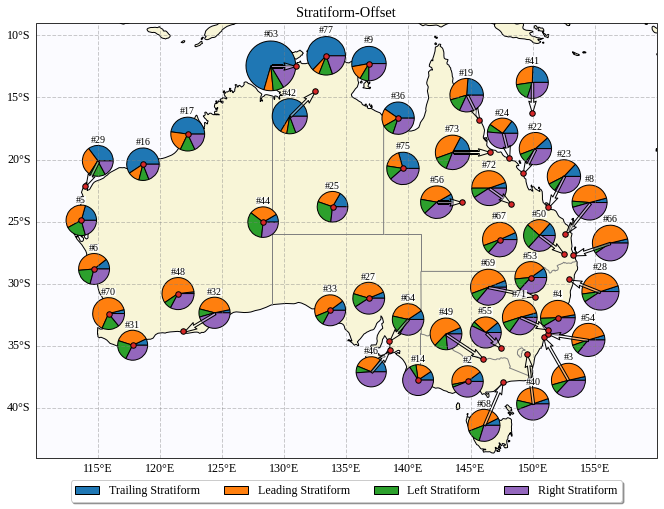

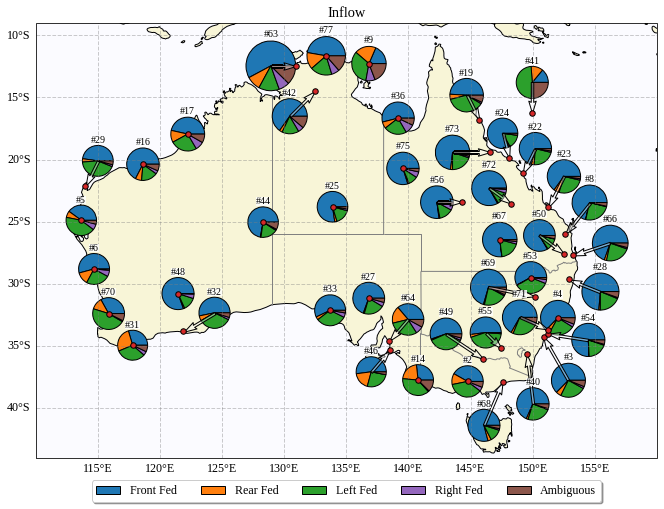

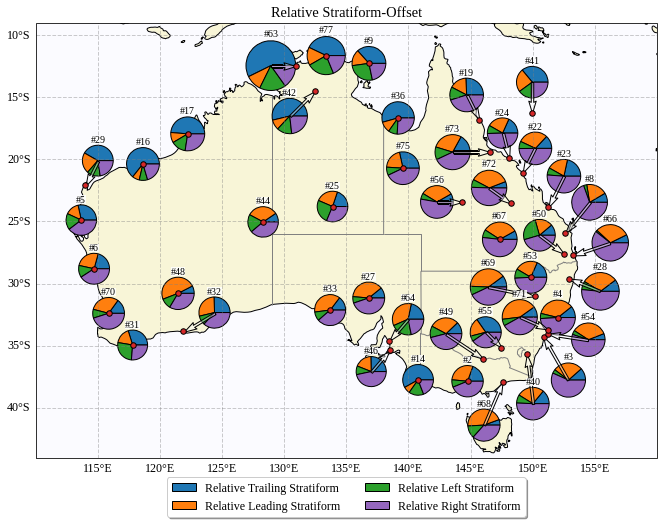

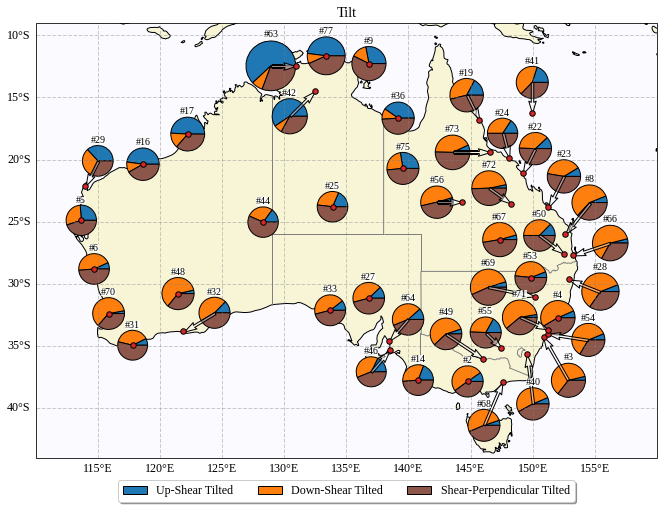

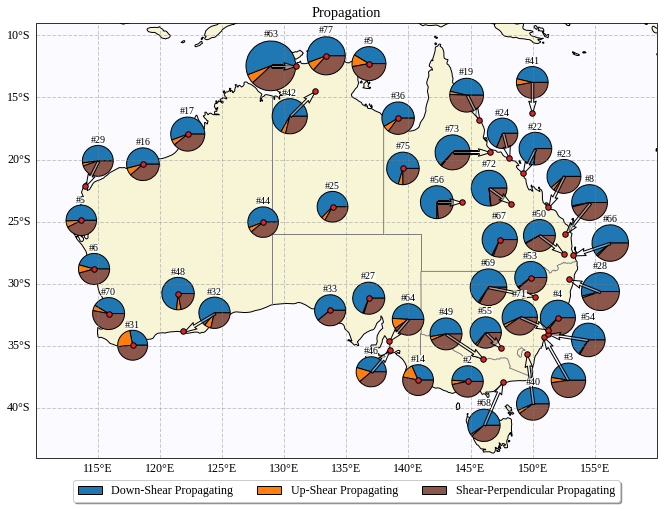

In [38]:
cl.plot_pie_map(radar_dfs)

In [33]:
radar_info = pd.read_csv(
    '~/Documents/phd/AURA_analysis/radar_site_list.csv', index_col=0)

radars = [
    2, 3, 4, 5, 6, 8, 9, 14, 16, 17, 19, 22, 23, 24, 25, 27, 28, 29, 31, 32,
    33, 36, 37, 40, 41, 42, 44, 46, 48, 49, 50, 52, 53, 54, 55, 56, 63, 64,
    66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77]

In [340]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [35]:
good_radar = radar_info.loc[radars]

In [180]:
CAPEs = []
AKEs = []
Rs = []
RHs = []
lats = []
lons = []
for r in radars:
    CAPEs.append(np.median(CAPE[cond_res & (data_dic_array['radar']==r) & AKE_cond]))
    AKEs.append(np.median(AKE[cond_res & (data_dic_array['radar']==r) & AKE_cond]))
    Rs.append(np.median(R[cond_res & (data_dic_array['radar']==r) & AKE_cond]))
    RHs.append(np.median(data_dic_array['av_rh_bfl'][cond_res & (data_dic_array['radar']==r) & AKE_cond]))
#     import pdb; pdb.set_trace()
    lat = good_radar.loc[[r]].iloc[0]['site_lat']
    lon = good_radar.loc[[r]].iloc[0]['site_lon']
    lats.append(lat)
    lons.append(lon)
lons=np.array(lons)
lats=np.array(lats)

(array([24., 25., 25., 26., 25., 25., 27., 19., 31., 25., 36., 34., 28.,
        27., 32., 24., 32., 25., 31., 23., 21., 32., 21., 31., 17., 29.,
        22., 17., 25., 24., 23., 21., 33., 16., 23., 22., 21., 18., 27.,
        30., 21., 26., 27., 15., 35., 32., 21., 20., 22.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
        3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9]),
 <BarContainer object of 49 artists>)

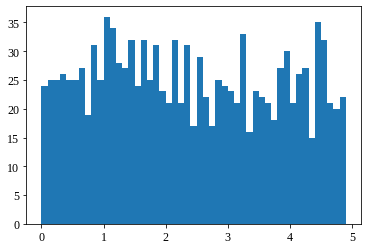

In [165]:
plt.hist(AKE[cond_res & AKE_cond], bins=np.arange(0,5, .1))

In [57]:
offset_array = np.array(list(offset_dic.values()))
lats

array([-37.8553, -34.2625, -32.7298, -24.888 , -28.8047, -25.9574,
       -12.275 , -37.7477, -20.3719, -17.9483, -16.817 , -21.117 ,
       -23.855 , -19.886 , -23.796 , -31.157 , -29.622 , -22.103 ,
       -34.9414, -33.8302, -32.1298, -16.666 , -42.8374, -35.6614,
       -16.2874, -14.513 , -25.0334, -35.3295, -30.7843, -36.0296,
       -27.608 , -41.1791, -29.4903, -34.0148, -35.167 , -23.4278,
       -12.457 , -34.6169, -27.7178, -26.44  , -37.8876, -31.0236,
       -32.3917, -33.7008, -23.5498, -19.4198, -20.7112, -43.1122,
       -11.6485])

In [93]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

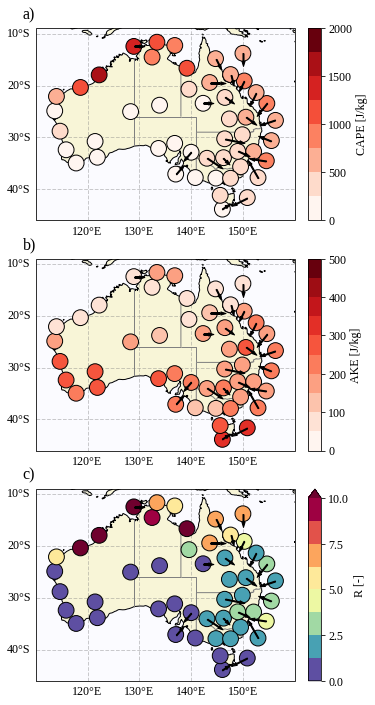

In [227]:
offset_dic = dict(zip(
    radars, [[0, 0] for i in range(len(radars))]))
offset_dic[24] = [-.5, 2]
offset_dic[66] = [3, 1]
offset_dic[50] = [-2, 1.5]
offset_dic[71] = [-2.25, 1]
offset_dic[54] = [3.25, -.5]
offset_dic[3] = [2, -3.5]
offset_dic[76] = [3, 1.5]
offset_dic[37] = [-1.5, -1]
offset_dic[64] = [1.5, 1.75]
offset_dic[46] = [-1.5, -1.75]
offset_dic[49] = [-3, 2]
# offset_dic[68] = [-1.5, -3.5]
offset_dic[55] = [-1.25, 1.25]
offset_dic[69] = [-3.75, .75]
# offset_dic[32] = [2.5, 1.5]
# offset_dic[40] = [.5, -4]
offset_dic[28] = [2.5, -1]
offset_dic[8] = [2, 2.5]
offset_dic[23] = [1.25, 2.5]
offset_dic[41] = [0, 2.5]
offset_dic[19] = [-1, 2]
# offset_dic[29] = [1, 2]
offset_dic[73] = [-3, 0]
offset_dic[22] = [1, 2]
offset_dic[72] = [-1.75, 1.25]
offset_dic[56] = [-2, 0]
offset_dic[63] = [-2, 0]
# offset_dic[42] = [-2, -2]

offset_array = np.array(list(offset_dic.values()))

good_radar = radar_info.loc[radars]

cl.init_fonts(fontsize=12)
fig = plt.figure(figsize=(6, 12))

def init_map(fig, i):
    ax = fig.add_subplot(3, 1, i, projection=ccrs.PlateCarree())
    ax.coastlines(resolution='50m', zorder=1)

    grid = ax.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=True,
        linewidth=1, color='gray', alpha=0.4, linestyle='--')

    grid.xlocator = mticker.FixedLocator(np.arange(110, 160, 10))
    grid.ylocator = mticker.FixedLocator(np.arange(-50, -5, 10))
    grid.xformatter = LONGITUDE_FORMATTER
    grid.yformatter = LATITUDE_FORMATTER

    ax.set_extent([110, 160, -9, -46], crs=ccrs.PlateCarree())

    states_provinces_50m = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces_50m, edgecolor='grey', zorder=1)

    c_land = tuple(np.array([249.0, 246.0, 216.0])/256)
    c_water = tuple(np.array([252.0, 252.0, 256.0])/256)

    land_50m = cfeature.NaturalEarthFeature(
        'physical', 'land', '50m',
        edgecolor='face',
        facecolor=c_land)
    ax.add_feature(land_50m, zorder=0)

    ocean_50m = cfeature.NaturalEarthFeature(
        'physical', 'ocean', '50m',
        edgecolor='face',
        facecolor=c_water)
    ax.add_feature(ocean_50m, zorder=0)

    grid.right_labels = False
    grid.top_labels = False
    return ax

# cmaps = ['Reds', 'Reds', 'Blues', 'Spectral_r']
# labels = ['CAPE [J/kg]', 'AKE [J/kg]', 'RH [%]', 'R [-]']
# min_vars = [0, 0, 60, 0]
# max_vars = [2000, 500, 90, 10]

# cbar_ticks = [
#     np.arange(0,2200,200), np.arange(0, 600, 100), 
#     np.arange(60,100,10), np.arange(0,11,1)]

# variables = [CAPEs, AKEs, RHs, Rs]

cmaps = ['Reds', 'Reds', 'Spectral_r']
cmap_steps = [8, 10, 8]
labels = ['CAPE [J/kg]', 'AKE [J/kg]', 'R [-]']
min_vars = [0, 0, 0]
max_vars = [2000, 500, 10]

cbar_ticks = [
    np.arange(0,2200, 500), np.arange(0, 600, 100), 
    np.arange(0,11,2.5)]

variables = [CAPEs, AKEs, Rs]

for v in range(len(variables)):
    
    ax = init_map(fig, v+1)

    variable = variables[v]
    cmap = cm.get_cmap(cmaps[v], cmap_steps[v])

    if cmaps[v] == 'Spectral_r':
#         import pdb; pdb.set_trace()
        cmap.set_over(.7*np.array(
            [0.6196078431372549, 0.00392156862745098, 0.25882352941176473]))
    
    norm = mpl.colors.Normalize(vmin=min_vars[v], vmax=max_vars[v])

    ax.scatter(
        lons+offset_array[:,0], lats+offset_array[:,1], marker='o', 
        color=cmap((np.array(variable)-min_vars[v])/(max_vars[v]-min_vars[v])), s=250, linewidth=1, 
        edgecolor='k', zorder=3)

    axins = inset_axes(
        ax,
        width="5%",  # width: 50% of parent_bbox width
        height="100%",  # height: 5%
        loc="right",
        bbox_to_anchor=(.125, 0., 1, 1),
        bbox_transform=ax.transAxes)

    if cmaps[v] == 'Spectral_r':
        cb = mpl.colorbar.ColorbarBase(axins, cmap=cmap, norm=norm, extend='max')
    else:
        cb = mpl.colorbar.ColorbarBase(axins, cmap=cmap, norm=norm)
    cb.set_ticks(cbar_ticks[v])
    cb.set_label(labels[v])

    for i in range(len(lons)):
        lon = lons[i]
        lat = lats[i]
        if offset_array[i,:].tolist() != [0,0]:
            ax.quiver(
                lon+offset_array[i,0], lat+offset_array[i,1],
                -offset_array[i,0], -offset_array[i,1],
                edgecolor='black', zorder=3, angles='xy',
                scale_units='xy', scale=1, width=.004,
                facecolor='k',
                linewidth=1)

plt.subplots_adjust(wspace=.4)
cl.make_subplot_labels(plt.gcf().get_axes()[::2], x_shift=-.05, y_shift=.05)
#     plt.legend(
#         patches, list(pie_data.index),
#         loc='lower center',
#         bbox_to_anchor=(.5, offsets[i]),
#         ncol=leg_col[i], fancybox=True, shadow=True)
plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/phd/AUS_MCS_paper/R_geo.png',
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

In [222]:
cmap.N

9

In [221]:
sd = cmap._segmentdata
for i in range(cmap.N)
    for c in ['red', 'green', 'blue', 'alpha']
    

{'red': [(0.0, 0.3686274509803922, 0.3686274509803922),
  (0.09999999999999998, 0.19607843137254902, 0.19607843137254902),
  (0.19999999999999996, 0.4, 0.4),
  (0.29999999999999993, 0.6705882352941176, 0.6705882352941176),
  (0.3999999999999999, 0.9019607843137255, 0.9019607843137255),
  (0.5, 1.0, 1.0),
  (0.6, 0.996078431372549, 0.996078431372549),
  (0.7, 0.9921568627450981, 0.9921568627450981),
  (0.8, 0.9568627450980393, 0.9568627450980393),
  (0.9, 0.8352941176470589, 0.8352941176470589),
  (1.0, 0.6196078431372549, 0.6196078431372549)],
 'green': [(0.0, 0.30980392156862746, 0.30980392156862746),
  (0.09999999999999998, 0.5333333333333333, 0.5333333333333333),
  (0.19999999999999996, 0.7607843137254902, 0.7607843137254902),
  (0.29999999999999993, 0.8666666666666667, 0.8666666666666667),
  (0.3999999999999999, 0.9607843137254902, 0.9607843137254902),
  (0.5, 1.0, 1.0),
  (0.6, 0.8784313725490196, 0.8784313725490196),
  (0.7, 0.6823529411764706, 0.6823529411764706),
  (0.8, 0.4274

In [223]:
cmap.set_over([0.6196078431372549, 0.00392156862745098, 0.25882352941176473])

In [99]:
nice_number(max(CAPEs))

2000.0

# Sensitivity

In [9]:
tracks_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/'

In [10]:
class_thresh_base = {
    'OFFSET_MAG': 10000,  # metres
    'SHEAR_MAG': 2,  # m/s
    'VEL_MAG': 5,  # m/s
    'REL_VEL_MAG': 2,  # m/s
    'ANGLE_BUFFER': 10}

excl_thresh_base = {
    'SMALL_AREA': 500,  # km^2
    'LARGE_AREA': 50000,  # km^2
    'BORD_THRESH': 0.001,  # Ratio border pixels to total pixels
    'MAJOR_AXIS_LENGTH': 25,  # km
    'AXIS_RATIO': 2,
    'DURATION': 30}  # minutes

test_names = [
    'base', 'lower_conv_level', 'higher_conv_level', 
    'four_levels', 'no_steiner', 'lower_ref_thresh',
    'higher_shear_thresh', 'higher_rel_vel_thresh', 
    'higher_theta_e', 'higher_offset_thresh', 'higher_border_thresh',
    'higher_area_thresh', 'linear_50', 'linear_25', 'combined']

tracks_dir = [
    'national', 'national_C2', 'national_C4', 
    'national_4L', 'national_NS', 'national_LR',
    'national', 'national', 
    'national', 'national', 'national',
    'national', 'national', 'national', 'national_C']

[
    class_thresh_S4, class_thresh_RV4, 
    class_thresh_T15, class_thresh_SO15] = [
    copy.deepcopy(class_thresh_base) for i in range(4)]

class_thresh_S4['SHEAR_MAG'] = 4
class_thresh_RV4['REL_VEL_MAG'] = 4
class_thresh_T15['ANGLE_BUFFER'] = 15
class_thresh_SO15['OFFSET_MAG'] = 15000

class_thresh_comb = {
    'OFFSET_MAG': 12500,
    'SHEAR_MAG': 3,
    'VEL_MAG': 5,
    'REL_VEL_MAG': 3,
    'ANGLE_BUFFER': 15}

class_threshes = [
    None, None, None, 
    None, None, None,
    class_thresh_S4, class_thresh_RV4, 
    class_thresh_T15, class_thresh_SO15, None, 
    None, None, None,
    class_thresh_comb]

[
    excl_thresh_B05, excl_thresh_A2000, 
    excl_thresh_L50, excl_thresh_L25] = [
    copy.deepcopy(excl_thresh_base) for i in range(4)]

excl_thresh_B05['BORD_THRESH'] = 0.0005
excl_thresh_A2000['SMALL_AREA'] = 2000
excl_thresh_L50['MAJOR_AXIS_LENGTH'] = 50
excl_thresh_L25['MAJOR_AXIS_LENGTH'] = 25

excl_thresh_comb = {
    'SMALL_AREA': 2000,
    'LARGE_AREA': 50000,
    'BORD_THRESH': 0.001,
    'MAJOR_AXIS_LENGTH': 25,
    'AXIS_RATIO': 2,
    'DURATION': 30}

excl_threshes = [
    None, None, None, 
    None, None, None,
    None, None,
    None, None, excl_thresh_B05, 
    excl_thresh_A2000, excl_thresh_L50, excl_thresh_L25,
    excl_thresh_comb]

non_linear_conds = [
    False, False, False, False, False, False, False, False,
    False, False, False, False, True, True, False]

get_exclusions = [
    False, False, False, False, False, False, True, True,
    True, True, True, True, True, True, False]

In [11]:
radar = 70

for i in range(len(tracks_dir)):
    
    print('Getting classes for test:{}.'.format(test_names[i]))
#     import pdb; pdb.set_trace()
    class_df = cl.get_counts_radar(
        base_dir='/home/student.unimelb.edu.au/shorte1/Documents/CPOL_analysis/',
        tracks_dir=save_dir + tracks_dir[i] + '/radar_{}'.format(radar), 
        class_thresh=class_threshes[i], excl_thresh=excl_threshes[i],
        non_linear=non_linear_conds[i], radar=radar, years=np.arange(2012, 2024))

#     import pdb; pdb.set_trace()
    
    out_file_name = save_dir + '{}_classes.pkl'.format(test_names[i])
    with open(out_file_name, 'wb') as f:
        pickle.dump(class_df, f)

Getting classes for test:base.
Processing year 2012, month 1, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 2, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 3, radar, 70
No tracks. Skipping
Processing year 2012, month 4, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 5, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 6, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 7, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 8, radar, 70
No 

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 5, radar, 70
No tracks. Skipping
Processing year 2017, month 6, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 7, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 8, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 9, radar, 70
No tracks. Skipping
Processing year 2017, month 10, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 11, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processi

Adding Pope monsoon regime.
Processing year 2022, month 6, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 7, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 8, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 9, radar, 70
No tracks file. Skipping
Processing year 2022, month 10, radar, 70
No tracks file. Skipping
Processing year 2022, month 11, radar, 70
No tracks. Skipping
Processing year 2022, month 12, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2023, month 1, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2023, month 2, radar, 70
Getting new exclusions.
Calculating system tracks.
No system tracks. Skipping.
Processi

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 12, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 1, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 2, radar, 70
No tracks. Skipping
Processing year 2016, month 3, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 4, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 5, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 6, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 7, radar, 70
Getti

No tracks satisfying conditions. Skipping year.
Processing year 2020, month 12, radar, 70
No tracks. Skipping
Processing year 2021, month 1, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 2, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 3, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 4, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 5, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 6, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 7, radar, 70
Getting new exclusions.
Calculati

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 9, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 10, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 11, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2014, month 12, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 1, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 2, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processin

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 10, radar, 70
No tracks. Skipping
Processing year 2019, month 11, radar, 70
No tracks. Skipping
Processing year 2019, month 12, radar, 70
No tracks. Skipping
Processing year 2020, month 1, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 2, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 3, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 4, radar, 70
No tracks. Skipping
Processing year 2020, month 5, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 6, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Po

Adding Pope monsoon regime.
Processing year 2013, month 6, radar, 70
No tracks. Skipping
Processing year 2013, month 7, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2013, month 8, radar, 70
No tracks. Skipping
Processing year 2013, month 9, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 10, radar, 70
No tracks. Skipping
Processing year 2013, month 11, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 12, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 1, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping 

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 9, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 10, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 11, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 12, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 1, radar, 70
No tracks. Skipping
Processing year 2019, month 2, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 3, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regi

Processing year 2012, month 5, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 6, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 7, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 8, radar, 70
No tracks. Skipping
Processing year 2012, month 9, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 10, radar, 70
No tracks. Skipping
Processing year 2012, month 11, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 12, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing 

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 2, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 3, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 4, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 5, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 6, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 7, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 8, radar, 70
Getting new exclusi

Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 2, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 3, radar, 70
No tracks. Skipping
Processing year 2012, month 4, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 5, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 6, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 7, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 8, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 9, radar, 70
Getting new exclusions.
Calculating system tracks.


Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 4, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 5, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 6, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 7, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 8, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 9, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2017, month 10, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope 

Processing year 2022, month 4, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 5, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 6, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 7, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 8, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 9, radar, 70
No tracks file. Skipping
Processing year 2022, month 10, radar, 70
No tracks file. Skipping
Processing year 2022, month 11, radar, 70
No tracks. Skipping
Processing year 2022, month 12, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2023, month 1, radar, 70
Getting new exclusions.
Calculating system 

No tracks satisfying conditions. Skipping year.
Processing year 2015, month 11, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 12, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 1, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 2, radar, 70
No tracks. Skipping
Processing year 2016, month 3, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 4, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 5, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, mon

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 2, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 3, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 4, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 5, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 6, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 7, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 8, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 9, radar

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 11, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2014, month 12, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 1, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 2, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 3, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 4, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 5, radar, 70
Getting new exclu

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 11, radar, 70
No tracks. Skipping
Processing year 2019, month 12, radar, 70
No tracks. Skipping
Processing year 2020, month 1, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 2, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 3, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 4, radar, 70
No tracks. Skipping
Processing year 2020, month 5, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 6, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 7, radar, 70
Ge

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 8, radar, 70
No tracks. Skipping
Processing year 2013, month 9, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 10, radar, 70
No tracks. Skipping
Processing year 2013, month 11, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 12, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2014, month 1, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 2, radar, 70
No tracks. Skipping
Processing year 2014, month 3, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon re

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 10, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 11, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 12, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 1, radar, 70
No tracks. Skipping
Processing year 2019, month 2, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 3, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 4, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regi

Adding Pope monsoon regime.
Processing year 2012, month 5, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 6, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 7, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 8, radar, 70
No tracks. Skipping
Processing year 2012, month 9, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 10, radar, 70
No tracks. Skipping
Processing year 2012, month 11, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 12, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 8, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 9, radar, 70
No tracks. Skipping
Processing year 2017, month 10, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 11, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 12, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 1, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018

Adding Pope monsoon regime.
Processing year 2022, month 6, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 7, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 8, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 9, radar, 70
No tracks file. Skipping
Processing year 2022, month 10, radar, 70
No tracks file. Skipping
Processing year 2022, month 11, radar, 70
No tracks. Skipping
Processing year 2022, month 12, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2023, month 1, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2023, month 2, radar, 70
Getting new exclusions.
Calculating sys

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 12, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 1, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 2, radar, 70
No tracks. Skipping
Processing year 2016, month 3, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 4, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 5, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 6, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2016, month 7, radar, 70
Getti

Adding Pope monsoon regime.
Processing year 2021, month 3, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 4, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 5, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 6, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 7, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2021, month 8, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 9, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2021, month 10, rada

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 11, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2014, month 12, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 1, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 2, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 3, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2015, month 4, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2015, month 5, radar, 70
Getting new exclu

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 11, radar, 70
No tracks. Skipping
Processing year 2019, month 12, radar, 70
No tracks. Skipping
Processing year 2020, month 1, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 2, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 3, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 4, radar, 70
No tracks. Skipping
Processing year 2020, month 5, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2020, month 6, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2020, month 7, radar, 70
Ge

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 8, radar, 70
No tracks. Skipping
Processing year 2013, month 9, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 10, radar, 70
No tracks. Skipping
Processing year 2013, month 11, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2013, month 12, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 1, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2014, month 2, radar, 70
No tracks. Skipping
Processing year 2014, month 3, radar, 70
Getting new exclusions.
C

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 8, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 9, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 10, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 11, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2018, month 12, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2019, month 1, radar, 70
No tracks. Skipping
Processing year 2019, month 2, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regi

Processing year 2012, month 2, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 3, radar, 70
No tracks. Skipping
Processing year 2012, month 4, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 5, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2012, month 6, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 7, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2012, month 8, radar, 70
No tracks. Skipping
Processing year 2012, month 9, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks sati

Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 8, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 9, radar, 70
No tracks. Skipping
Processing year 2017, month 10, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 11, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 12, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018, month 1, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2018

Processing year 2022, month 8, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 9, radar, 70
No tracks file. Skipping
Processing year 2022, month 10, radar, 70
No tracks file. Skipping
Processing year 2022, month 11, radar, 70
No tracks. Skipping
Processing year 2022, month 12, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2023, month 1, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2023, month 2, radar, 70
Getting new exclusions.
Calculating system tracks.
No system tracks. Skipping.
Processing year 2023, month 3, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2023, month 4, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope mons

Adding Pope monsoon regime.
Processing year 2016, month 5, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 6, radar, 70
No tracks. Skipping
Processing year 2016, month 7, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2016, month 8, radar, 70
No tracks. Skipping
Processing year 2016, month 9, radar, 70
No tracks. Skipping
Processing year 2016, month 10, radar, 70
No tracks. Skipping
Processing year 2016, month 11, radar, 70
No tracks. Skipping
Processing year 2016, month 12, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2017, month 1, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skippin

Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 3, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 4, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 5, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 6, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
Processing year 2022, month 7, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 8, radar, 70
Getting new exclusions.
Calculating system tracks.
Adding Pope monsoon regime.
No tracks satisfying conditions. Skipping year.
Processing year 2022, month 9, radar, 70
No tracks file. 

In [12]:
r = 70
tracks_dir_base = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/'

years = range(2012, 2024)

raw_sample_list = np.zeros(len(tracks_dir))
res_sample_list = np.zeros(len(tracks_dir))

for i in range(len(tracks_dir)):
    for y in years:
        print('Getting year {}.'.format(y))
        if y == 2023:
            end_month = 6
        else: 
            end_month = 13
        if y == 2012:
            start_month = 6
        else:
            start_month = 1
        for m in range(start_month, end_month):
            
#             import pdb; pdb.set_trace()
            
            dir_ry = tracks_dir_base + tracks_dir[i] + '/radar_{}/{}/'.format(r, y)
                                  
            try:               
                filename = dir_ry + '/{:02}_{:04}_{:02}.pkl'.format(r, y, m)
                with open(filename, 'rb') as f:
                    tracks_obj = pickle.load(f)
            except FileNotFoundError:
                print('File not found.')
                continue

            if len(tracks_obj.tracks) < 4:
                print('Small tracks.')
                continue
                
            print('Getting new exclusions.')
            try:
                tracks_obj = cl.redo_exclusions(
                    tracks_obj, class_threshes[i], excl_threshes[i])
            except KeyError:
                print('No system tracks. Skipping.')
                continue

            exclusions_raw = ['simple_duration_cond']
            try:
                excluded_raw = tracks_obj.exclusions[exclusions_raw]
            except AttributeError:
                print('Attribute error.')
                continue     
            excluded_raw = np.any(excluded_raw, 1)
            raw_sample = np.logical_not(excluded_raw)
            raw_sample = raw_sample.xs(0, level='level').values
            raw_sample = raw_sample[raw_sample]
                
            exclusions = [
                'small_area', 'large_area', 'intersect_border',
                'intersect_border_convective', 'duration_cond',
                'small_velocity', 'small_offset']
            if non_linear_conds[i]:
                exclusions += ['non_linear']
            try:
                excluded = tracks_obj.exclusions[exclusions]
            except AttributeError:
                print('Attribute error.')
                continue                
            excluded = np.any(excluded, 1)
            restricted_sample = np.logical_not(excluded)
            restricted_sample = restricted_sample.xs(0, level='level').values
            restricted_sample = restricted_sample[restricted_sample]
            
#             import pdb; pdb.set_trace()
            
            raw_sample_list[i] += len(raw_sample)
            res_sample_list[i] += len(restricted_sample)

Getting year 2012.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting year 2013.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting year 2014.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system 

Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Small tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting year 2017.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting year 2018.
Getting new

Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting year 2021.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating

Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting year 2013.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting year 2014.
Small tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
No system tracks. Skipping.
Getting new exclusions.
Calculating system tracks.
Getting new exclusio

Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting year 2017.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting year 2018.
Getting new excl

Small tracks.
Small tracks.
Getting year 2020.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting year 2021.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating sys

Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting year 2013.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting year 2014.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
C

Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Small tracks.
Small tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting year 2017.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting year 2018.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new

Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting year 2021.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating

Getting new exclusions.
Calculating system tracks.
Getting year 2013.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting year 2014.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating sys

Small tracks.
Small tracks.
Small tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting year 2017.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting year 2018.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new

Small tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting year 2021.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Small tracks.
Getting year 2022.
Small tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
Calculating system tracks.
Getting new exclusions.
C

In [13]:
sen_dfs = cl.plot_all_oldschool(
    test_names=None, test_dir=None, diurnal=False, fig_style='paper')

Paper style. Using defaults.


In [166]:
path = '/home/student.unimelb.edu.au/shorte1/Documents/phd/AUS_MCS_paper/2_raw_samples.pkl'
with open(path, 'rb') as f:
    raw = pickle.load(f)
    
path = '/home/student.unimelb.edu.au/shorte1/Documents/phd/AUS_MCS_paper/2_res_samples.pkl'
with open(path, 'rb') as f:
    res = pickle.load(f)

In [279]:
ss_df = pd.DataFrame({'Raw Sample': raw_sample_list, 'Restricted Sample': res_sample_list}, index=sen_dfs[0].index)

In [14]:
raw = raw_sample_list
res = res_sample_list

Paper style. Using defaults.


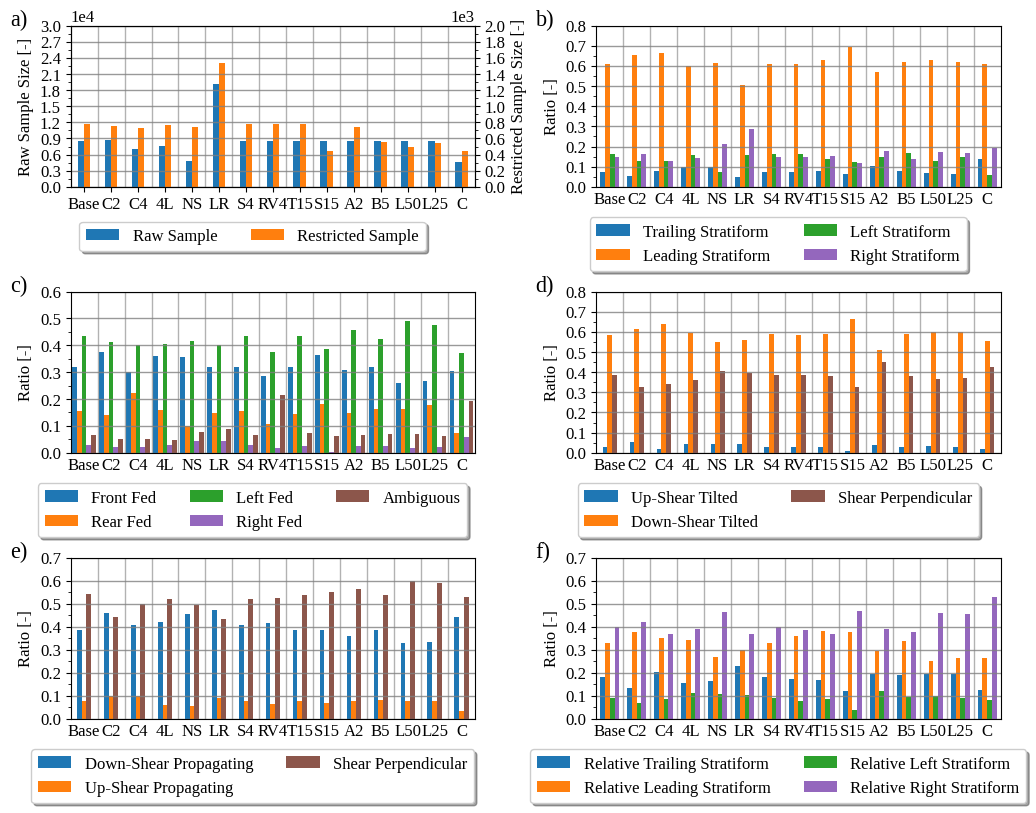

In [15]:
cl.plot_sensitivities_oldschool(
    sen_dfs, test_names, raw, res, name_abvs=None, fig_style='paper', raw_max=30000, res_max=2000, raw_step=3000, res_step=200)